## Preproccessing and Setup

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set(style="white")
import warnings
warnings.filterwarnings('ignore')
import pickle
# import dcor 
# from statsmodels.tsa.seasonal import seasonal_decompose

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization

# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
tf.random.set_seed(13)
np.random.seed(13)
# random.seed(13)
def mean_absolute_percentage_error(y_true, y_pred):
  for i in range(len(y_true)):
    if y_true[i] == 0:
      print('MAPE * Founded')
      y_true[i] = np.mean(y_true)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
data = pd.read_csv('DowDataset.csv', sep=',', date_parser=True)
dataset1 = data.iloc[:343].copy()
dataset2 = data.iloc[396:754].copy()
dataset_test = data.iloc[761:].copy()
full_dataset = pd.concat([dataset1, dataset2, dataset_test], axis=0 , ignore_index=True)
full_dataset = full_dataset.drop(['DATE', 'Flow_to_EQ'], axis=1)

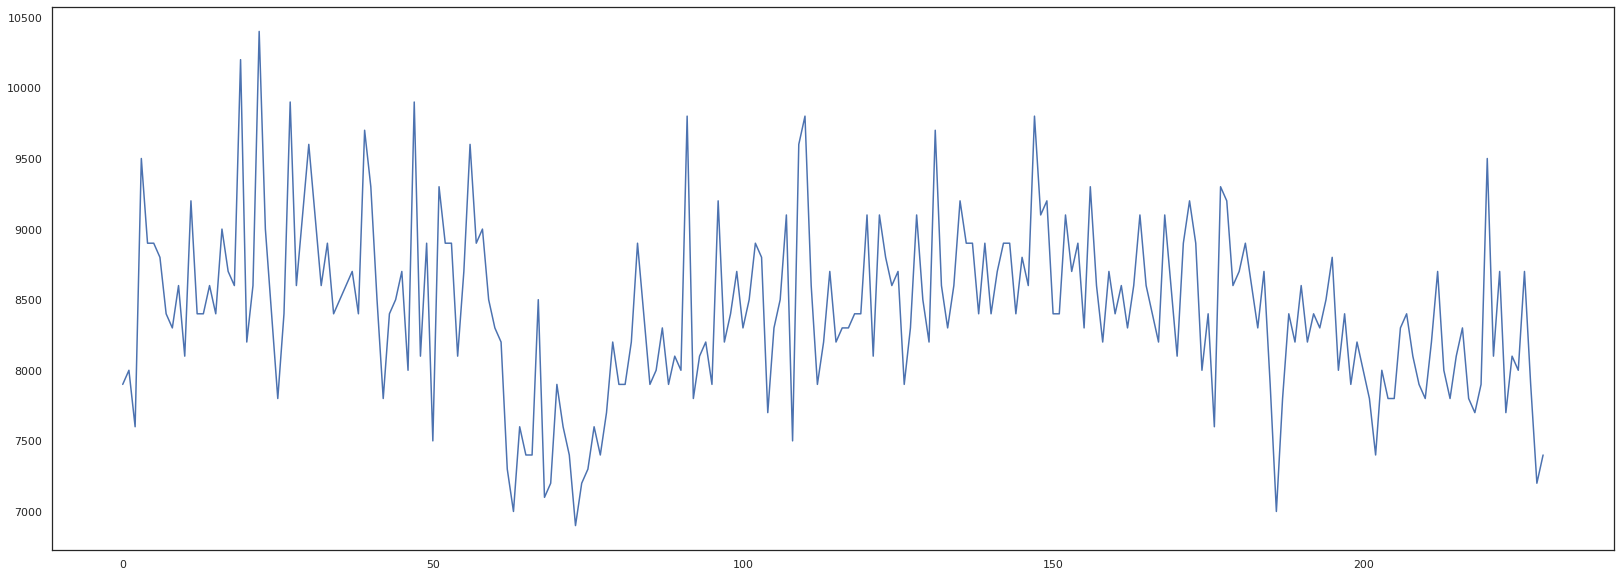

In [74]:
plt.figure(figsize=(28,10))
dataset1['BT_C_MVLSS'][:230].plot()

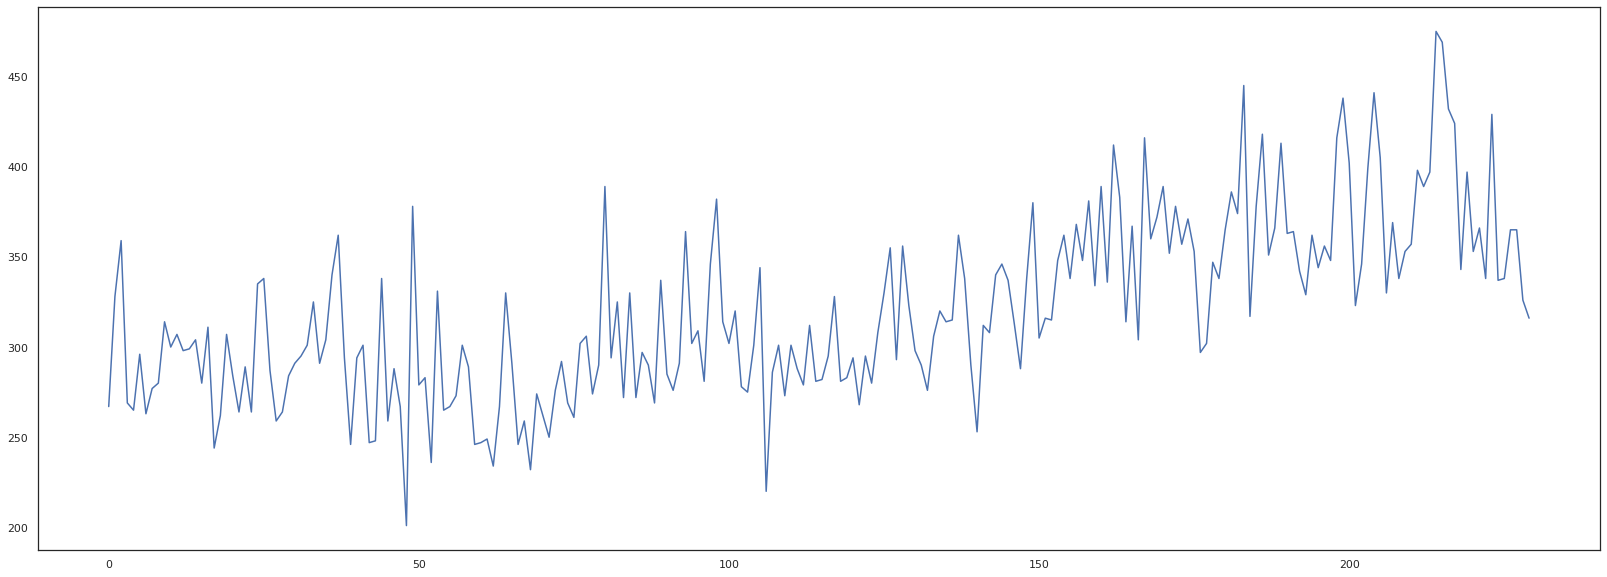

In [75]:
plt.figure(figsize=(28,10))
dataset1['EQ_COD'][:230].plot()

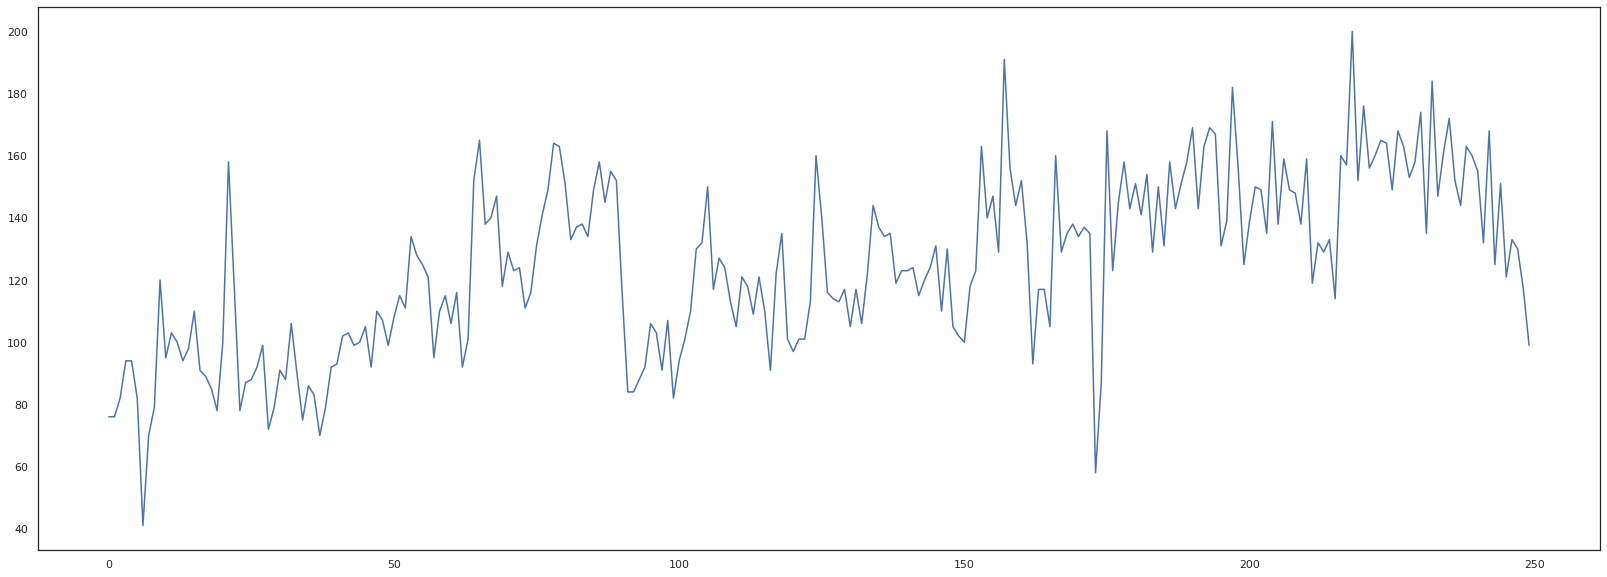

In [77]:
plt.figure(figsize=(28,10))
dataset1['D_COD_ON'][:250].plot()

In [16]:
class approach1:
  def __init__(self, df, goal, window_size = 5):
    self.df = df.copy()
    self.goal = goal
    self.window_size = window_size

    self.df['trend'] = self.df[self.goal].rolling(self.window_size).mean().fillna(method='bfill')
    self.df['residual'] = self.df[self.goal] - self.df['trend']
    self.df['target'] = self.df['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'tanh'
      self.model_layers = 2
      self.model_neurons = [6, 24]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'linear'
      self.model_layers = 2
      self.model_neurons = [10, 18]
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'relu'
      self.model_layers = 2
      self.model_neurons = [14, 22]

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std

    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(self.model_neurons[0], activation = self.model_activation, input_dim= self.X_train.shape[1]))
    self.model.add(BatchNormalization())
    if self.model_layers == 2:
      self.model.add(Dense(self.model_neurons[1], activation = self.model_activation))
    self.model.add(Dense(1))

    self.model.compile(optimizer= self.model_optimizer, loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1, shuffle = False)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach1.h5')

  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    ACTIVATION = ['relu', 'tanh']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100
    for activation in ACTIVATION: 
      for optimizer in OPTIMIZER:
        for num_layer in NUM_LAYER:
          if num_layer == 1:
            for neurons in NUM_UNITS:
              self.model = tf.keras.Sequential()
              self.model.add(Dense(neurons, activation=activation, input_dim= self.X_train.shape[1]))
              self.model.add(Dense(1))
              self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
              history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history_Ann.history['val_loss']))
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history_Ann.history['val_loss']) < min_score:
                min_score = min(history_Ann.history['val_loss'])
                min_score_pos = n
              n+=1
          if num_layer == 2:
            for neurons in NUM_UNITS:
              for neurons2 in NUM_UNITS:
                self.model = tf.keras.Sequential()
                self.model.add(Dense(neurons, activation=activation, input_dim= self.X_train.shape[1]))
                self.model.add(Dense(neurons2, activation=activation))
                self.model.add(Dense(1))
                self.model.compile(optimizer= optimizer, loss='mse', metrics=['MAPE'])    
                history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)   
                # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history_Ann.history['val_loss'])) 
                self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history_Ann.history['val_loss']), 'Epoch':history_Ann.history['val_loss'].index(min(history_Ann.history['val_loss']))}
                print(self.tune_results[f'{n}'])
                if min(history_Ann.history['val_loss']) < min_score:
                  min_score = min(history_Ann.history['val_loss'])
                  min_score_pos = n
                n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}']
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    self.df_test['trend'] = self.df_test[self.goal].rolling(self.window_size).mean().fillna(method='ffill')
    self.df_test = self.df_test.iloc[-self.df_test.shape[0]+self.window_size:]
    self.df_test['residual'] = self.df_test[self.goal] - self.df_test['trend']
    self.df_test['target'] = self.df_test['residual'].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON', 'residual']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD', 'residual']].fillna(method='ffill')

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.prediction = self.prediction*self.y_std + self.y_mean
    self.full_prediction = self.df_test['trend'].reset_index(drop=True) + self.prediction['Prediction']

    print('*** ANN estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()


In [17]:
class approach2:
  def __init__(self, df, goal):
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='ffill')
      self.model_optimizer = 'SGD'
      self.model_activation = 'tanh'
      self.model_layers = 2
      self.model_neurons = [4, 32]
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_activation = 'tanh'
      self.model_layers = 2
      self.model_neurons = [2, 18]
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
      self.model_optimizer = 'adam'
      self.model_activation = 'linear'
      self.model_layers = 2
      self.model_neurons = [4, 10]

    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def series_to_supervised(self, n_in=5, n_out=1, dropnan=True):
    self.n_in = n_in
    self.n_out = n_out

    n_vars = 1 if type(self.X_train) is list else self.X_train.shape[1]
    df = pd.DataFrame(self.X_train)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
        names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
      else:
        names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
      agg.dropna(inplace=True)
    self.supervised = agg
    self.supervised_train = self.supervised.values.reshape((self.supervised.shape[0], 1, self.supervised.shape[1]))
    self.Y_train = self.Y_train.iloc[n_in:]

  def training(self, max_epochs = 50):
    #print(neurons)
    self.model = tf.keras.Sequential()
    self.model.add(LSTM(self.model_neurons[0], activation = self.model_activation, return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
    self.model.add(Dropout(0.1))
    if self.model_layers == 2:
      self.model.add(BatchNormalization())
      self.model.add(LSTM(self.model_neurons[1], activation = self.model_activation))
    self.model.add(Dense(1))
    self.model.compile(loss='mse', optimizer=self.model_optimizer, metrics=['mape'])  
    history = self.model.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('approach2.h5')
  
  def tune(self, max_epochs = 50):
    self.tune_results = {}
    OPTIMIZER = ['SGD', 'adam']
    ACTIVATION = ['relu', 'linear', 'tanh']
    NUM_UNITS = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]
    NUM_LAYER = [1, 2]
    n = 1
    min_score = 100
    for activation in ACTIVATION:
      for optimizer in OPTIMIZER:
        for num_layer in NUM_LAYER:
          if num_layer == 1:
            for neurons in NUM_UNITS:
              self.models = tf.keras.Sequential()
              self.models.add(LSTM(neurons, activation = activation, return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
              self.models.add(Dropout(0.1))
              self.models.add(Dense(1))
              self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
              history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1)
              # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - Score: ', min(history.history['val_loss']))
              self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
              print(self.tune_results[f'{n}'])
              if min(history.history['val_loss']) < min_score:
                min_score = min(history.history['val_loss'])
                min_score_pos = n
              n+=1
          if num_layer == 2:
            for neurons in NUM_UNITS:
              for neurons2 in NUM_UNITS:
                self.models = tf.keras.Sequential()
                self.models.add(LSTM(neurons, activation = activation, return_sequences=True, input_shape=(self.supervised_train.shape[1:])))
                self.models.add(Dropout(0.1))
                self.models.add(BatchNormalization())
                self.models.add(LSTM(neurons2, activation = activation, return_sequences=True))
                self.models.add(Dense(1))
                self.models.compile(loss='mse', optimizer=optimizer, metrics=['mape'])  
                history = self.models.fit(self.supervised_train, self.Y_train, epochs=max_epochs, verbose=0, validation_split=0.1) 
                # print('Optimizer: ', optimizer, ' - Layers: ', num_layer , ' - neurons: ', neurons, ' - ', neurons2, ' - Score: ', min(history.history['val_loss'])) 
                self.tune_results[f'{n}']  = {'Optimizer': optimizer, 'Activation': activation, 'Layers':num_layer , 'Neurons': {neurons, neurons2}, 'Score' : min(history.history['val_loss']), 'Epoch':history.history['val_loss'].index(min(history.history['val_loss']))}
                print(self.tune_results[f'{n}'])
                if min(history.history['val_loss']) < min_score:
                  min_score = min(history.history['val_loss'])
                  min_score_pos = n
                n+=1  
    self.best_tuned = self.tune_results[f'{min_score_pos}'] 

  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    def series_to_supervised_test(X_test, n_in=self.n_in, n_out=self.n_out, dropnan=True):
      n_vars = 1 if type(X_test) is list else X_test.shape[1]
      df = pd.DataFrame(X_test)
      cols, names = list(), list()
      # input sequence (t-n, ... t-1)
      for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (df.columns[j],i)) for j in range(n_vars)]
      # forecast sequence (t, t+1, ... t+n)
      for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
          names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
          names += [('%s(t+%d)' % (df.columns[j], i)) for j in range(n_vars)]
      # put it all together
      agg = pd.concat(cols, axis=1)
      agg.columns = names
      # drop rows with NaN values
      if dropnan:
        agg.dropna(inplace=True)
      supervised = agg
      supervised_test = supervised.values.reshape((supervised.shape[0], 1, supervised.shape[1]))
      return supervised_test
    # self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.Xt = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.Xt = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='ffill')

    # self.Xt = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill')
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill').iloc[self.n_in:]
    self.supervised_test = series_to_supervised_test(self.X_test)
    
    self.prediction = pd.DataFrame(self.model.predict(self.supervised_test).reshape(-1,1), columns=['Prediction'])
    self.full_prediction = self.prediction*self.y_std + self.y_mean
    
    print('*** LSTM estimation ***')
    # print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    # print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction.values))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction.values, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [18]:
class approach3:
  def __init__(self, df, goal):    
    self.df = df.copy()
    self.goal = goal

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    if self.goal == 'D_COD_ON':
      self.X = self.df[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='bfill')
    elif self.goal == 'EQ_COD':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    elif self.goal == 'BT_C_MVLSS':
      self.X = self.df[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill')
    
    # self.X = self.df[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='bfill')
    self.Y = self.df['target'].fillna(method='bfill')
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = self.X
    self.Y_train = self.Y
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
    # self.model.save('approach3.h5')
    pickle.dump(self.model, open('approach3.sav', 'wb'))
  
  def testing(self, df_test):
    self.df_test = df_test.copy()
    
    if self.goal == 'D_COD_ON':
      self.X_test = self.df_test[['D_SS', 'BT_C_N', 'EQ_N', 'BT_C_DO', 'ST_COD', 'EQ_COD', 'D_COD_ON']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'EQ_COD':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_N_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')
    elif self.goal == 'BT_C_MVLSS':
      self.X_test = self.df_test[['BT_C_MVLSS', 'D_SS', 'EQ_N', 'BT_C_N', 'OxT_PH_PM', 'BT_C_DO', 'Clari_DO', 'ST_COD', 'EQ_COD']].fillna(method='bfill').fillna(method='ffill')

    # self.X_test = self.df_test[['BT_C_MLSS','EQ_N', 'BT_C_N', 'D_COD_ON']].fillna(method='ffill').fillna(method='bfill')
    self.X_test = (self.X_test - self.x_mean)/self.x_std
    self.Y_test = self.df_test[self.goal].shift(-1).fillna(method='ffill')
        
    self.prediction = self.model.predict(self.X_test)
    # self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])
    self.amplifier = 10
    full_prediction = self.prediction*self.y_std + self.y_mean

    self.full_prediction = full_prediction
    # self.full_prediction = np.zeros(len(self.prediction))
    # self.full_prediction[0] = self.df_test[self.goal].reset_index(drop=True)[0] + full_prediction[0] 
    # for i in range(1,len(self.prediction)):
    #   self.full_prediction[i] = self.full_prediction[i-1] - full_prediction[i]
    # self.full_prediction = 3*self.prediction
    
    print('*** Delta estimation ***')
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))
    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel(f'{self.goal} (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

# BT_C_MVLSS

In [78]:
active_target = "BT_C_MVLSS"
dataset = dataset1.iloc[:230].copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        230 non-null    object 
 1   Flow_to_EQ  230 non-null    object 
 2   Flow_efl    230 non-null    float64
 3   BT_C_MLSS   230 non-null    float64
 4   BT_C_MVLSS  230 non-null    float64
 5   BT_N_MLSS   230 non-null    float64
 6   BT_N_MVLSS  230 non-null    float64
 7   D_SS        230 non-null    float64
 8   EQ_N        230 non-null    float64
 9   BT_C_N      230 non-null    float64
 10  BT_N_N      230 non-null    float64
 11  D_N         230 non-null    float64
 12  OxT_PH_PM   230 non-null    float64
 13  EQ_PH       230 non-null    float64
 14  BT_N_PH     230 non-null    float64
 15  D_PH        230 non-null    float64
 16  BT_N_DO     230 non-null    float64
 17  BT_C_DO     230 non-null    float64
 18  Clari_DO    230 non-null    float64
 19  F/M         230 non-null    f

In [20]:
# cut_off = 68
# active_targets = ['BT_C_MVLSS', 'EQ_COD', 'D_COD_ON']
# for j in range(0,3):
#   active_target = active_targets[j]
#   print('\n********************************************************************************************\n')
#   print(f'\n************************ {active_target} *****************************\n')
#   print('\n********************************************************************************************\n')
#   for i in range(2,8):
#     print('\n********************************************************************************************')
#     print(f'Trial with {i} day rolling windowning')
#     app1 = approach1(dataset.iloc[:-cut_off], active_target, i)
#     app1.training()
#     app1.testing(dataset.iloc[5:-cut_off])
#     app1.full_prediction.shape

## Approach 1

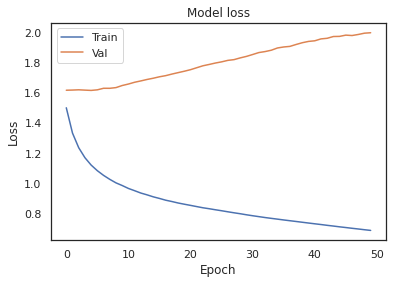

*** ANN estimation ***
MAPE:  4.878949709180153
R2:  0.2069819403533587
RMSE:  551.4162364439575


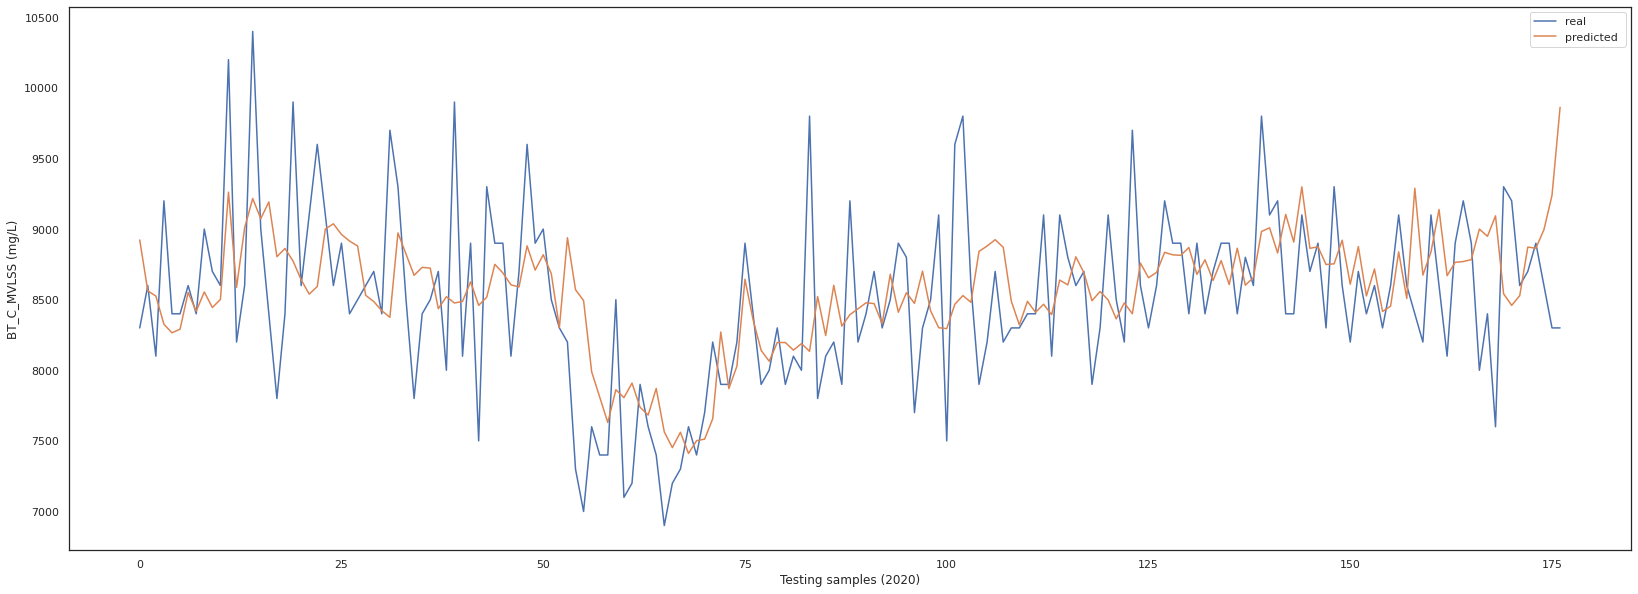

(177,)

In [21]:
cut_off = 46
app1 = approach1(dataset.iloc[:-cut_off], active_target, 5)
app1.training()
app1.testing(dataset.iloc[2:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

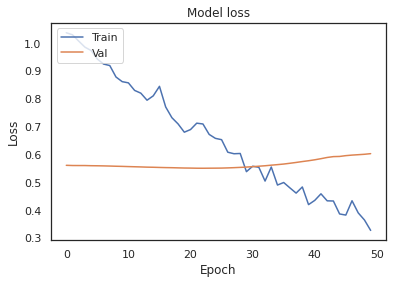

*** LSTM estimation ***
MAPE:  6.460961693642238
R2:  0.5879856905758856
RMSE:  397.4606703116463


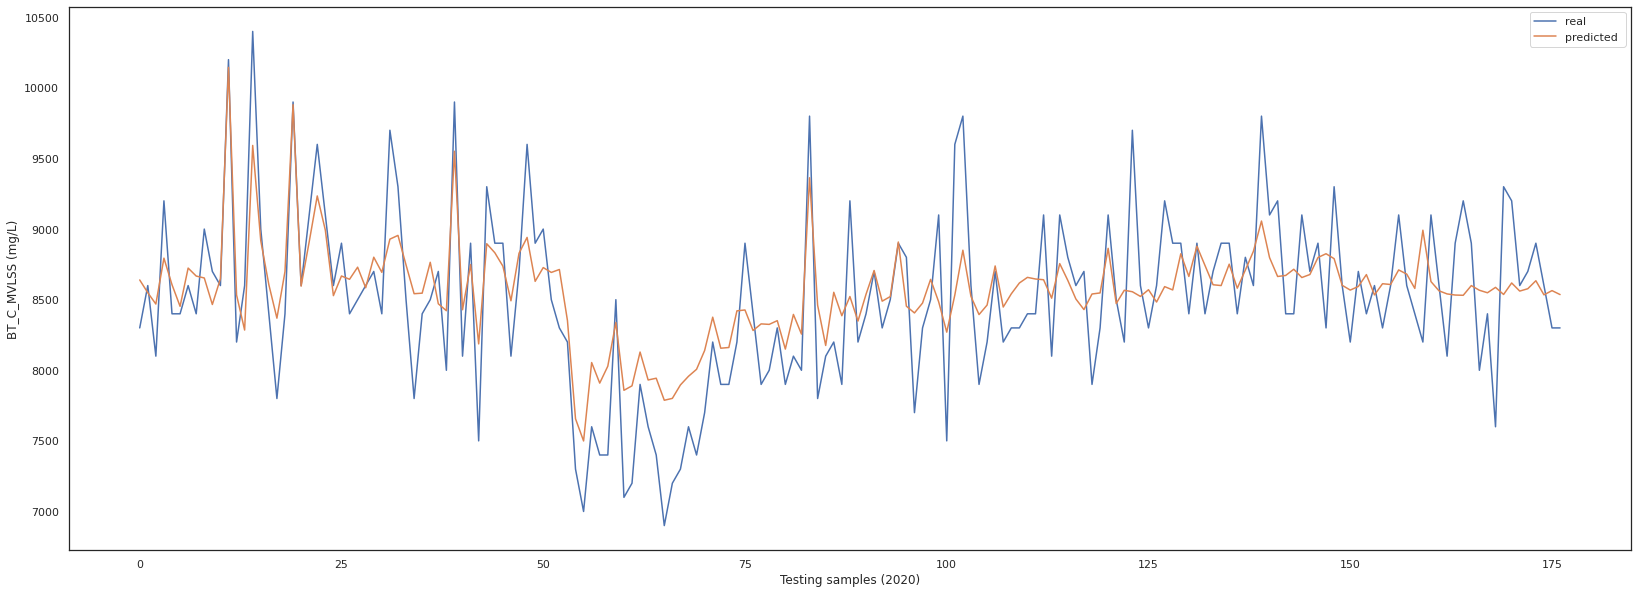

(177, 1)

In [22]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=7)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  4.866228483533504
R2:  0.20588618942369485
RMSE:  551.7970640129585


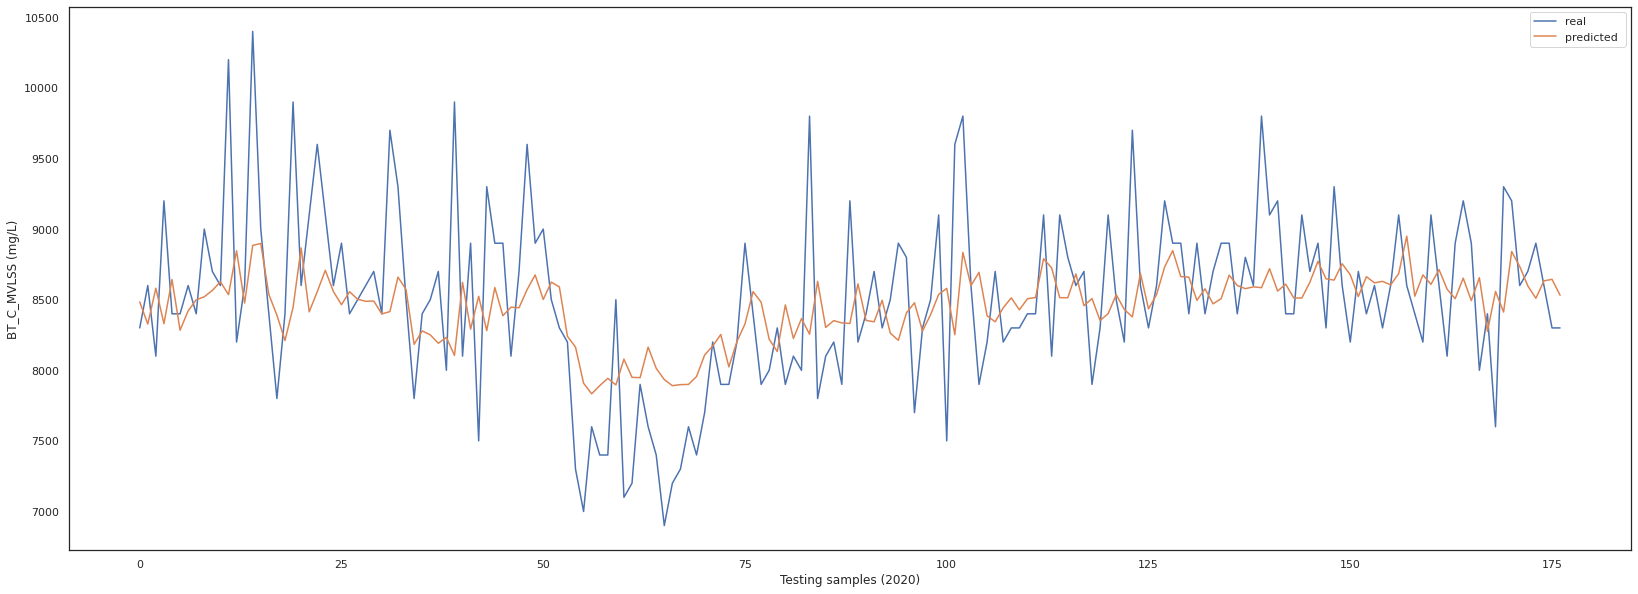

(177,)

In [23]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

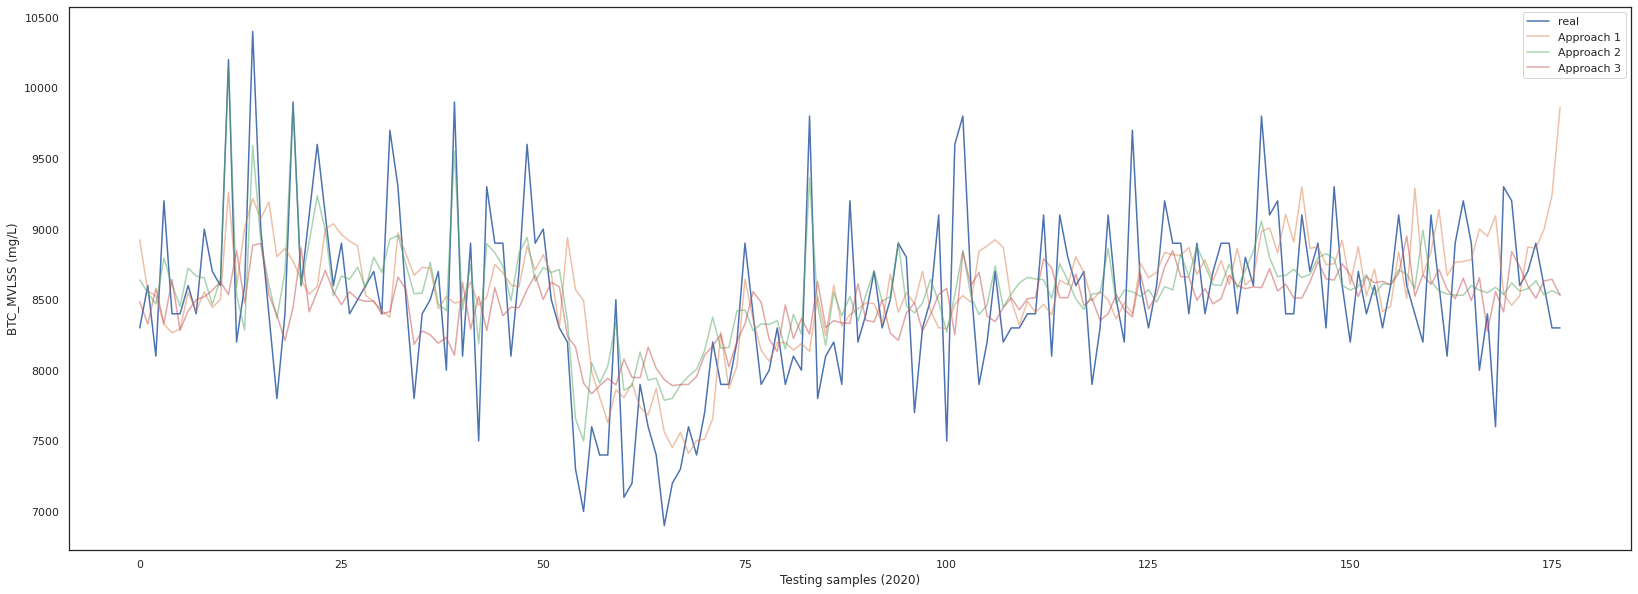

In [24]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [25]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      26047.128233
1      25438.994227
2      25576.148003
3      25449.686823
4      25514.391257
           ...     
172    26047.857147
173    26008.462470
174    26163.193811
175    26447.591323
176    26930.065554
Length: 177, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  4.67702994177467
R2:  0.2713617293635108
RMSE:  528.5596423849418


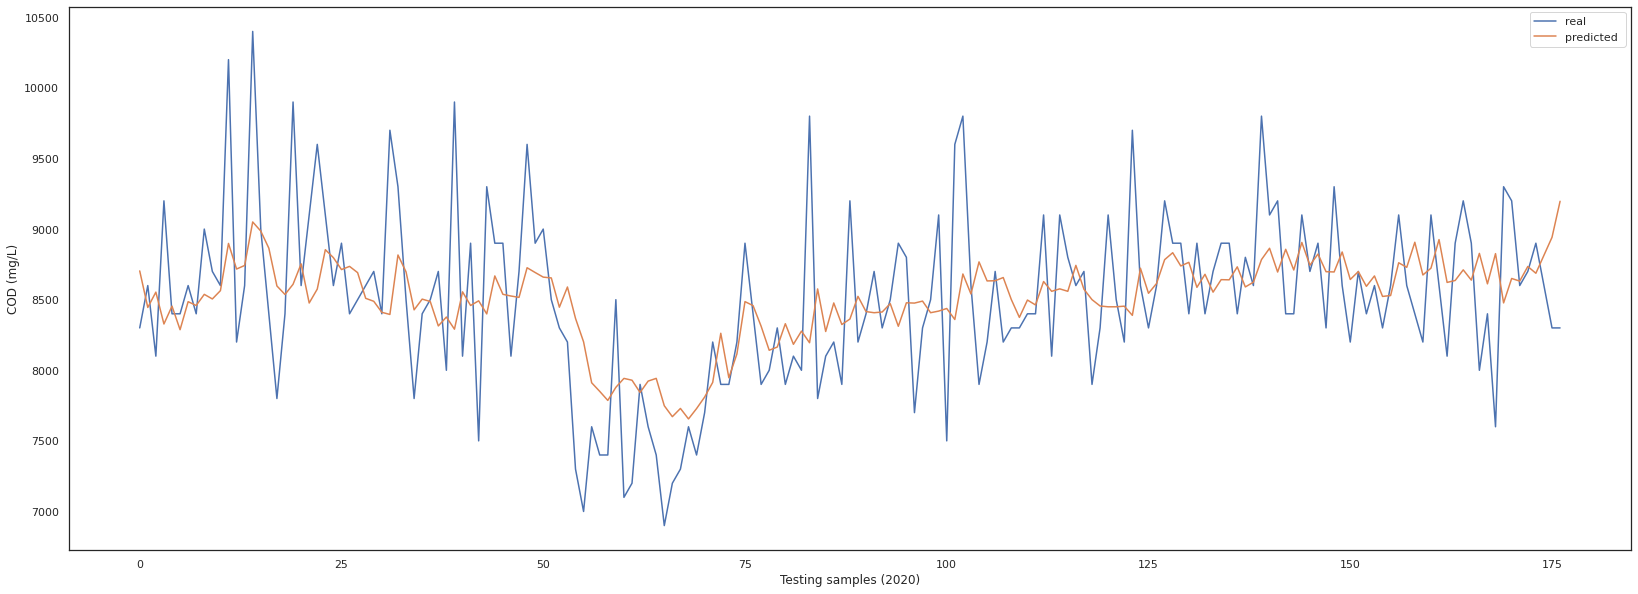

In [26]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  4.298970161345586
R2:  0.4258109459952524
RMSE:  469.20806179947004


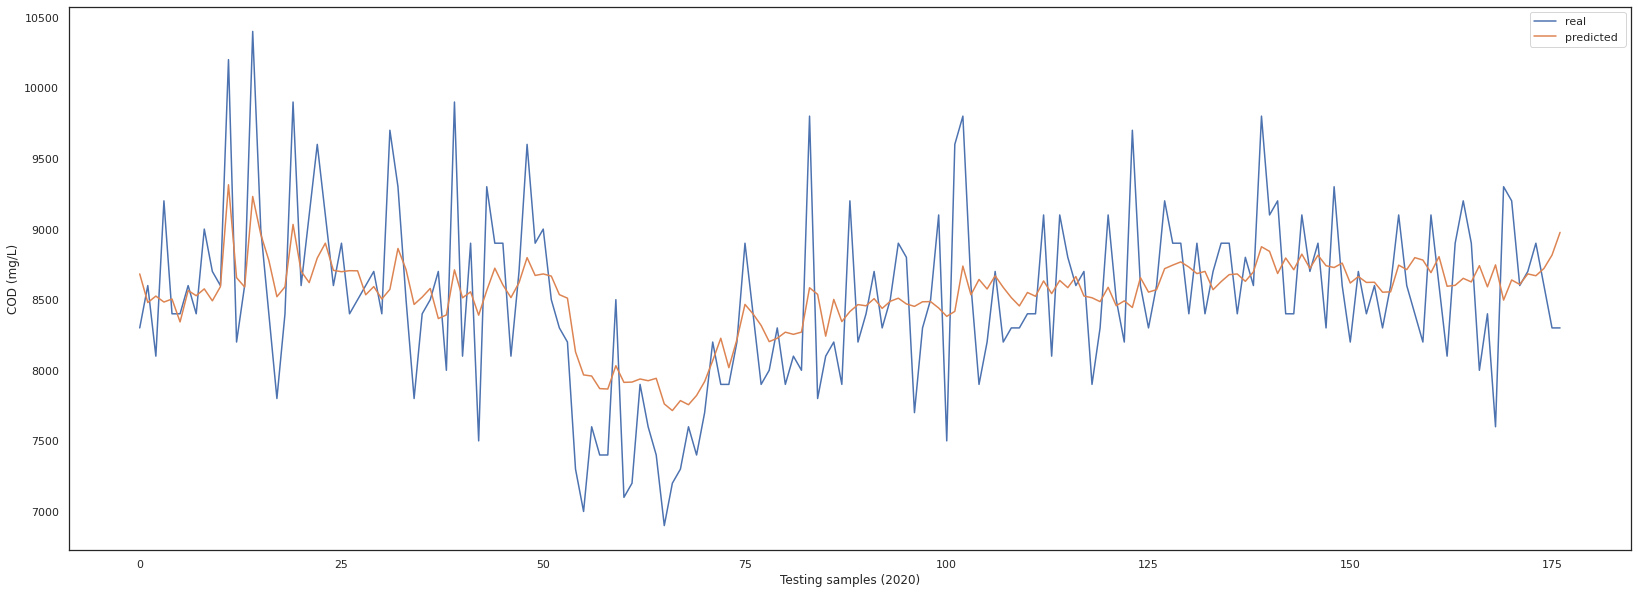

In [27]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

In [28]:
class Ensemble:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[['model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[['model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
5/5 [==============================] - 0s 37ms/step - loss: 1.7178 - MAPE: 235.9151 - val_loss: 0.8439 - val_MAPE: 141.4006
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.6523 - MAPE: 226.2438 - val_loss: 0.8397 - val_MAPE: 143.2436
Epoch 3/50
5/5 [==============================] - 0s 7ms/step - loss: 1.5977 - MAPE: 219.1447 - val_loss: 0.8384 - val_MAPE: 145.0656
Epoch 4/50
5/5 [==============================] - 0s 10ms/step - loss: 1.5364 - MAPE: 212.3590 - val_loss: 0.8387 - val_MAPE: 146.7971
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 1.4864 - MAPE: 208.8184 - val_loss: 0.8400 - val_MAPE: 148.4070
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 1.4362 - MAPE: 202.0167 - val_loss: 0.8432 - val_MAPE: 149.8928
Epoch 7/50
5/5 [==============================] - 0s 12ms/step - loss: 1.3924 - MAPE: 195.8880 - val_loss: 0.8475 - val_MAPE: 151.3111
Epoch 8/50
5/5 [==============================] - 0s 7ms/st

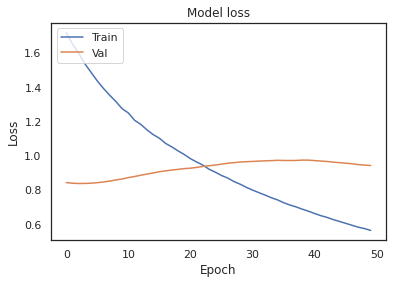

In [29]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 6.4962707  5.66043    5.5965924  5.7499485  5.9173594  5.794497
  6.0245028  5.630801   6.0609975  5.560292   5.670535   5.801976
  5.657173   6.4950175  7.128793   8.42121    7.3696823  5.6690035
  5.727414   5.548302   5.9075813  5.783879   5.66672    7.368918
  7.1312056  6.468729   6.744207   6.4631314  5.8381405  5.7784457
  5.786244   5.6814866  7.2362266  6.9263196  5.64031    5.66934
  5.782455   5.556664   5.5524726  5.6820383  5.552218   5.8449364
  6.987559   6.034267   6.6875844  5.8743234  5.6069264  6.0261497
  6.82244    6.586854   6.4650083  6.7376547  5.544205   5.628949
  9.677371  10.829435   8.652358  11.769167  12.058898   7.13149
 13.5627985 11.582993  10.14925   14.045175  11.614643  15.61088
 16.12225   13.974547  14.4683    13.433673  11.95881    8.984499
  7.911562   9.296798   6.565665   5.559849   6.8403983  7.7765584
  7.3492756  6.3065147  8.697861   6.4853034  7.695572   5.654945
  5.5874696  8.0931225

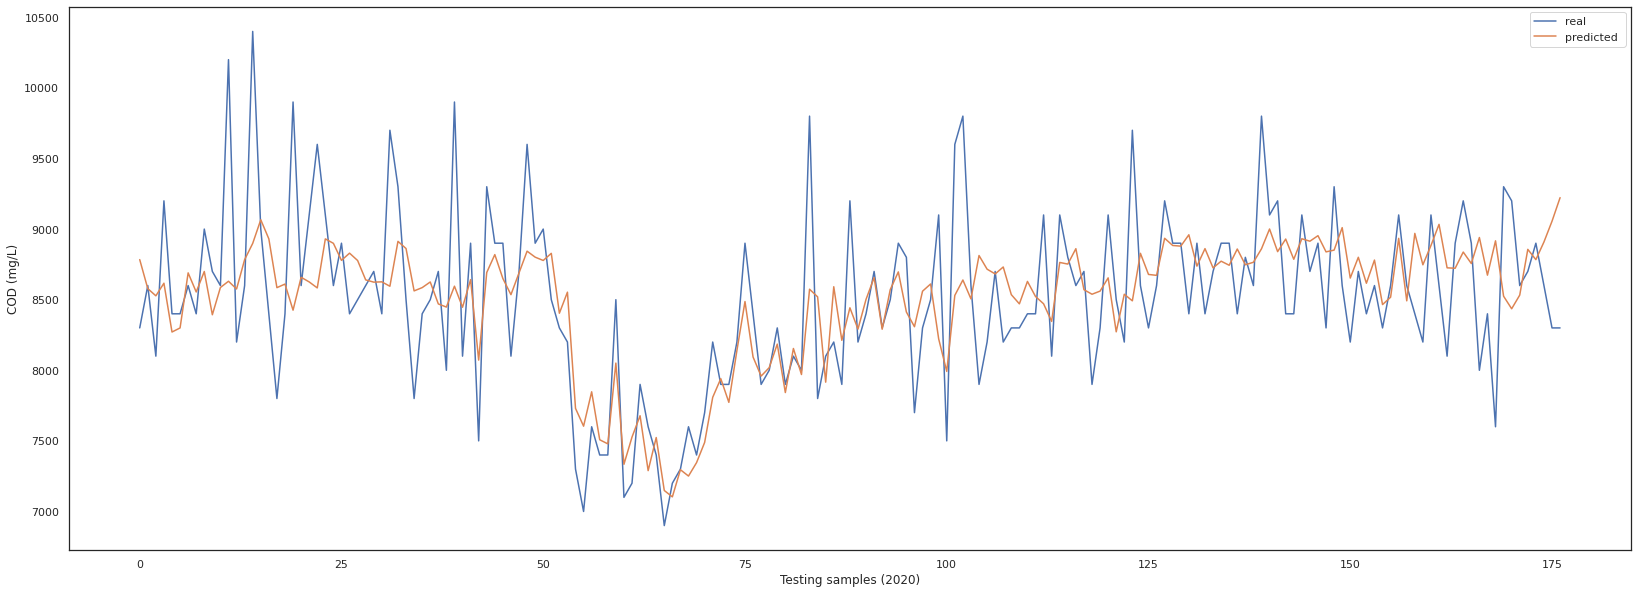

In [30]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


In [31]:
class Ensemble2:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)
    
    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3

    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')

    self.X = self.df[[self.goal, 'model1', 'model2', 'model3']]
    self.Y = self.df['target'] 
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    self.y_mean = self.Y.mean()
    self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)  
  
    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
  
  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons, activation='relu', input_dim= self.X_train.shape[1]))
    self.model.add(Dense(1))

    self.model.compile(optimizer= 'adam', loss='mse', metrics=['MAPE'])    
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')
  
  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')
    
    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target'] 
    # print(self.Xt)
  
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)
    
    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean
    

    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    # print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

Epoch 1/50
5/5 [==============================] - 1s 39ms/step - loss: 0.8430 - MAPE: 258.3536 - val_loss: 0.7217 - val_MAPE: 150.3070
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 0.8085 - MAPE: 250.8738 - val_loss: 0.7123 - val_MAPE: 147.3590
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7803 - MAPE: 247.3590 - val_loss: 0.7051 - val_MAPE: 144.7044
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7513 - MAPE: 243.3030 - val_loss: 0.6982 - val_MAPE: 142.0396
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7247 - MAPE: 241.6304 - val_loss: 0.6912 - val_MAPE: 139.3844
Epoch 6/50
5/5 [==============================] - 0s 7ms/step - loss: 0.7006 - MAPE: 238.3713 - val_loss: 0.6855 - val_MAPE: 136.9060
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.6792 - MAPE: 233.6510 - val_loss: 0.6791 - val_MAPE: 134.2585
Epoch 8/50
5/5 [==============================] - 0s 6ms/step

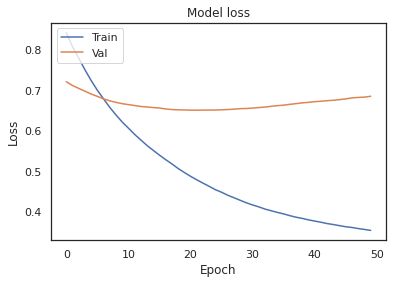

In [32]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[ 5.672962   5.569586   5.5438366  7.4004664  5.8547144  6.0037093
  6.2646465  5.734411   5.936211   5.599293   6.2892714 24.026793
  6.9048777  6.0006356 20.343786   6.973131   5.574907   5.9154196
  6.1762376 22.660868   6.649182   7.005851   8.68119    6.242566
  5.5588636  5.6578093  5.575604   5.9861307  5.5544443  6.582944
  5.6040206  8.812991   5.9977617  5.650465   5.6468015  5.553483
  6.1686683  5.5476804  5.556611  18.1526     6.308524   6.572055
  5.6904964 10.691387   5.681214   5.640484   5.563253   8.431383
  6.810505   5.8782806  5.621433   5.619682   7.0316443  5.7103715
 10.022466  14.335129  12.076286  12.106621  11.370584   7.6541433
  9.779833  13.483116   9.862998  11.853959  11.956198  14.718162
 13.885969  13.190742  12.084392  11.628528   8.340257   6.2460756
  8.107561   9.162173   6.355614   6.0344157  5.624449   6.187959
  7.265108   7.1682086  7.826905   6.681771   7.5125446 18.057636
  6.174033   8.5180

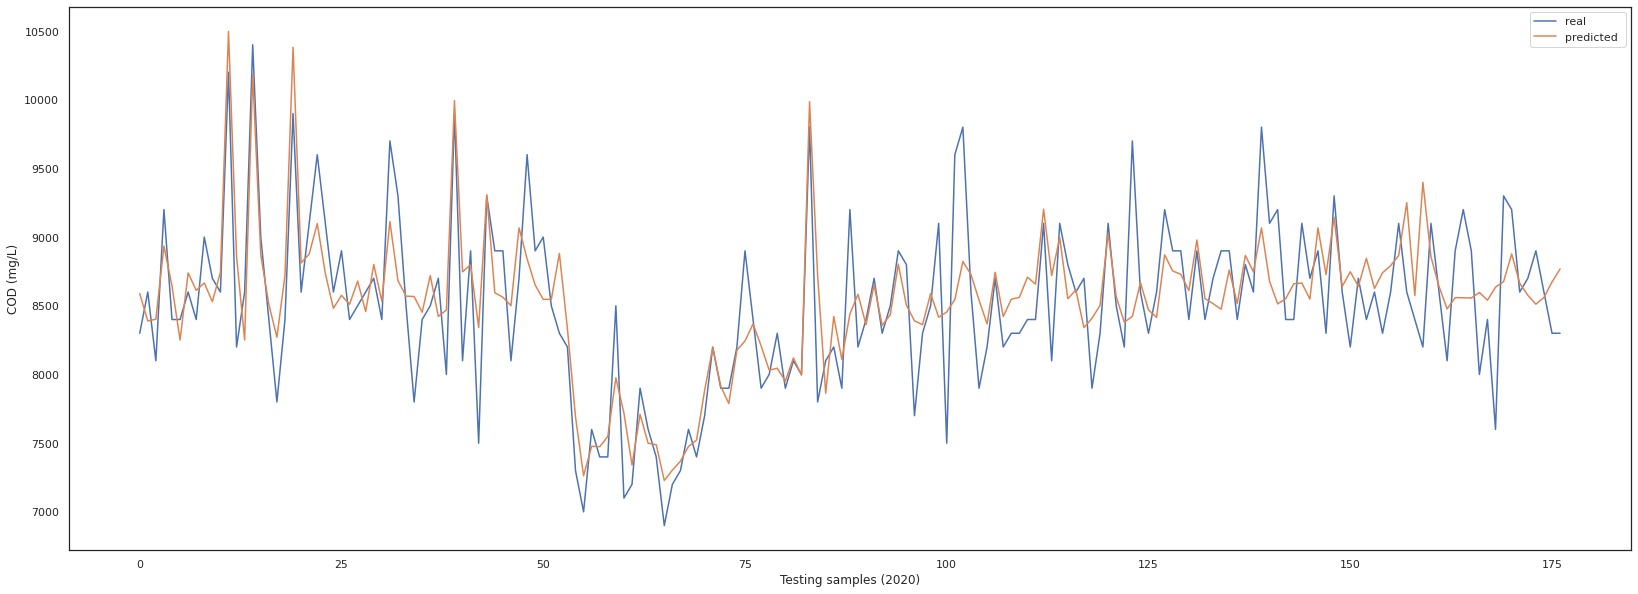

In [33]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

In [34]:
class Ensemble3:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
  

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
 
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 16, max_epochs = 50):
    self.model = tf.keras.Sequential()
    self.model.add(Dense(neurons/2, activation='relu', input_dim = self.X_train.shape[1]))
    self.model.add(Dense(neurons, activation='relu'))
    self.model.add(Dense(3, activation='softmax'))

    print(self.Y_train.shape)
    print(self.X_train.shape)

    self.model.compile(optimizer= 'adam', loss='categorical_crossentropy', metrics=['accuracy'])
    history_Ann = self.model.fit(self.X_train, self.Y_train, epochs=max_epochs, verbose=1, validation_split=0.1)
    # Plot training & validation loss values
    plt.plot(history_Ann.history['loss'])
    plt.plot(history_Ann.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    self.model.save('Ensemble.h5')

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)
    self.df_test[self.goal] = self.df_test[self.goal].fillna(method='ffill')

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal,'model1', 'model2', 'model3']]

    model1 = abs(self.df_test['model1'] - self.df_test['target'])
    model2 = abs(self.df_test['model2'] - self.df_test['target'])
    model3 = abs(self.df_test['model3'] - self.df_test['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Yt = pd.get_dummies(temp)   

    self.Y_test = self.Yt
    self.X_test = (self.Xt - self.x_mean)/self.x_std
    print(self.X_test, self.Y_train)

    self.score = self.model.evaluate(self.X_test, self.Y_test)
    self.prediction = self.model.predict(self.X_test)
    
    self.full_prediction = np.zeros(len(self.prediction))
    self.selection = pd.DataFrame(self.prediction).idxmax(axis=1)

    
    for i in range(len(self.prediction)):
      self.full_prediction[i] = self.df_test[f'model{int(self.selection[i])+1}'][i]
    # print(self.full_prediction)

    self.Ys_test = self.df_test['target']
    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('MAPEsci: ',mean_absolute_error(self.Ys_test, self.full_prediction)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Ys_test, self.full_prediction))
    print ('R2: ',r2_score(self.Ys_test, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Ys_test, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Ys_test, label = 'real ')
    plt.plot(self.full_prediction, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

     0  1  2
0    0  0  1
1    1  0  0
2    0  1  0
3    0  1  0
4    1  0  0
..  .. .. ..
172  0  0  1
173  1  0  0
174  0  0  1
175  0  1  0
176  0  0  1

[177 rows x 3 columns]
(177, 3)
(177, 4)
Epoch 1/50
5/5 [==============================] - 1s 47ms/step - loss: 1.2345 - accuracy: 0.3648 - val_loss: 1.0970 - val_accuracy: 0.3889
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 1.2139 - accuracy: 0.3711 - val_loss: 1.0957 - val_accuracy: 0.5000
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 1.1974 - accuracy: 0.3711 - val_loss: 1.0940 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1784 - accuracy: 0.3522 - val_loss: 1.0927 - val_accuracy: 0.5000
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1648 - accuracy: 0.3459 - val_loss: 1.0935 - val_accuracy: 0.4444
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 1.1503 - accuracy: 0.3333 - val_loss: 1.0

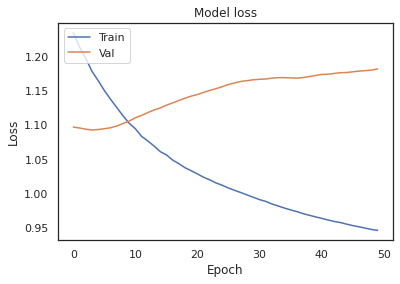

In [35]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

     BT_C_MVLSS    model1    model2    model3
0     -0.176548  0.920528  0.219209  0.127090
1     -0.337625  0.000268 -0.051004 -0.551479
2      0.145606 -0.093342 -0.290678  0.544384
3     -0.659779 -0.604308  0.681007 -0.539857
4      1.112069 -0.757686  0.119217  0.809266
..          ...       ...       ...       ...
172    0.145606  0.791567  0.033651  0.615976
173    0.306683  0.771040  0.202946  0.236389
174    0.628838  1.106304 -0.095823  0.768501
175    0.145606  1.727570 -0.006356  0.816431
176   -0.337625  3.318369 -0.090354  0.330647

[177 rows x 4 columns]      0  1  2
0    0  0  1
1    1  0  0
2    0  1  0
3    0  1  0
4    1  0  0
..  .. .. ..
172  0  0  1
173  1  0  0
174  0  0  1
175  0  1  0
176  0  0  1

[177 rows x 3 columns]
6/6 [==============================] - 0s 2ms/step - loss: 0.9690 - accuracy: 0.4802
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(3.8105813830001827, shape=(), dtype=float64)
MAPEsci:  32088.09625678881
MAPE:  3.810581383000184
R2:  0.538

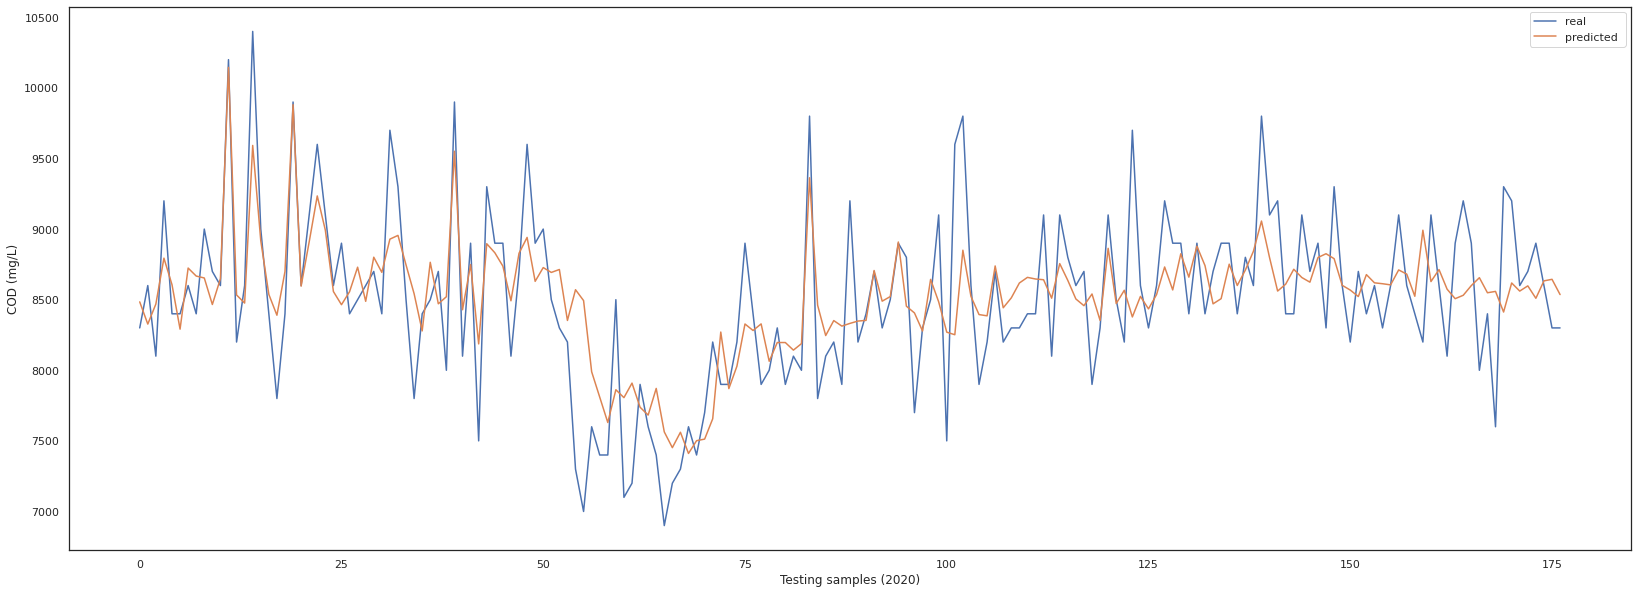

In [36]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [37]:
ensemble_model3.selection.to_list().count(1)

101

## Testing


*** ANN estimation ***
MAPE:  9.403953581796323
R2:  -2.855768965793505
RMSE:  873.4201718325567


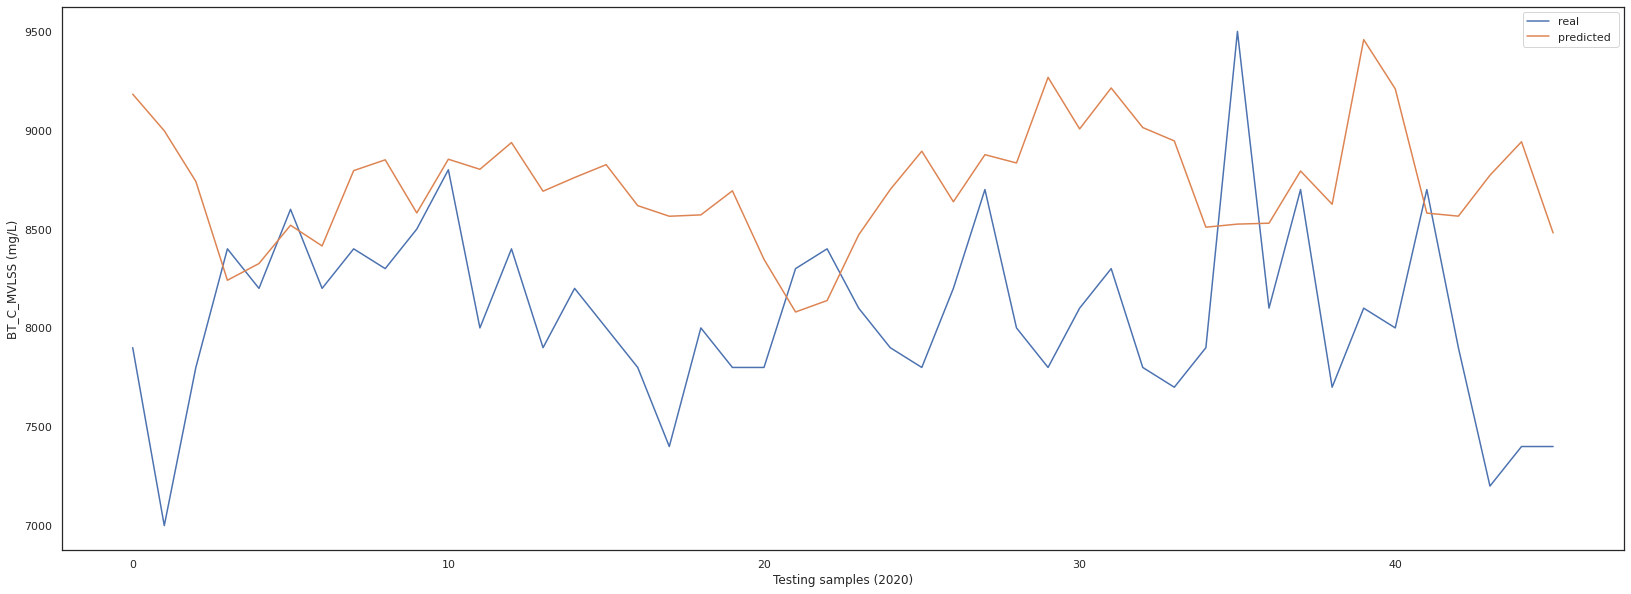

(46,)

In [38]:
app1.testing(dataset.iloc[-(cut_off + 5):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  7.46879584396693
R2:  -1.4007369746610774
RMSE:  689.1916494694503


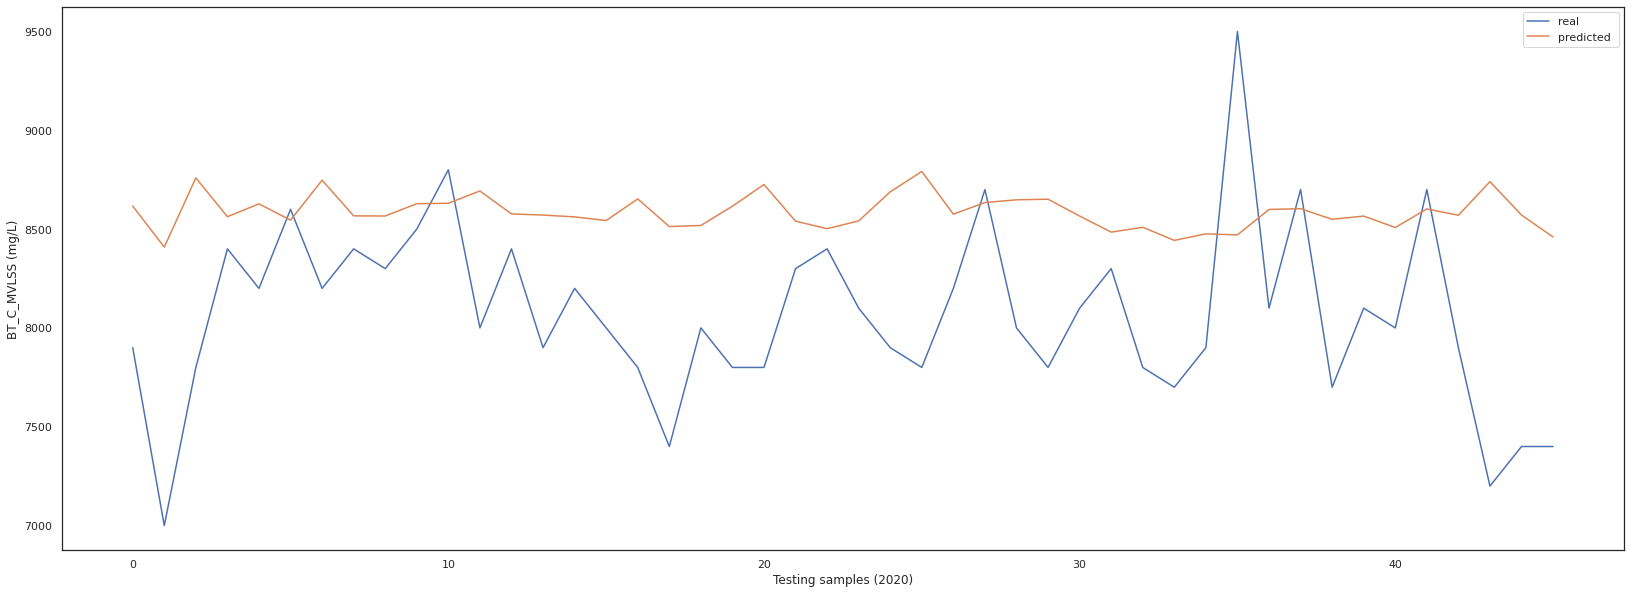

(46, 1)

In [39]:
app2.testing(dataset.iloc[-(cut_off + 7):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  8.301775017423804
R2:  -1.9802749298412499
RMSE:  767.8844638359249


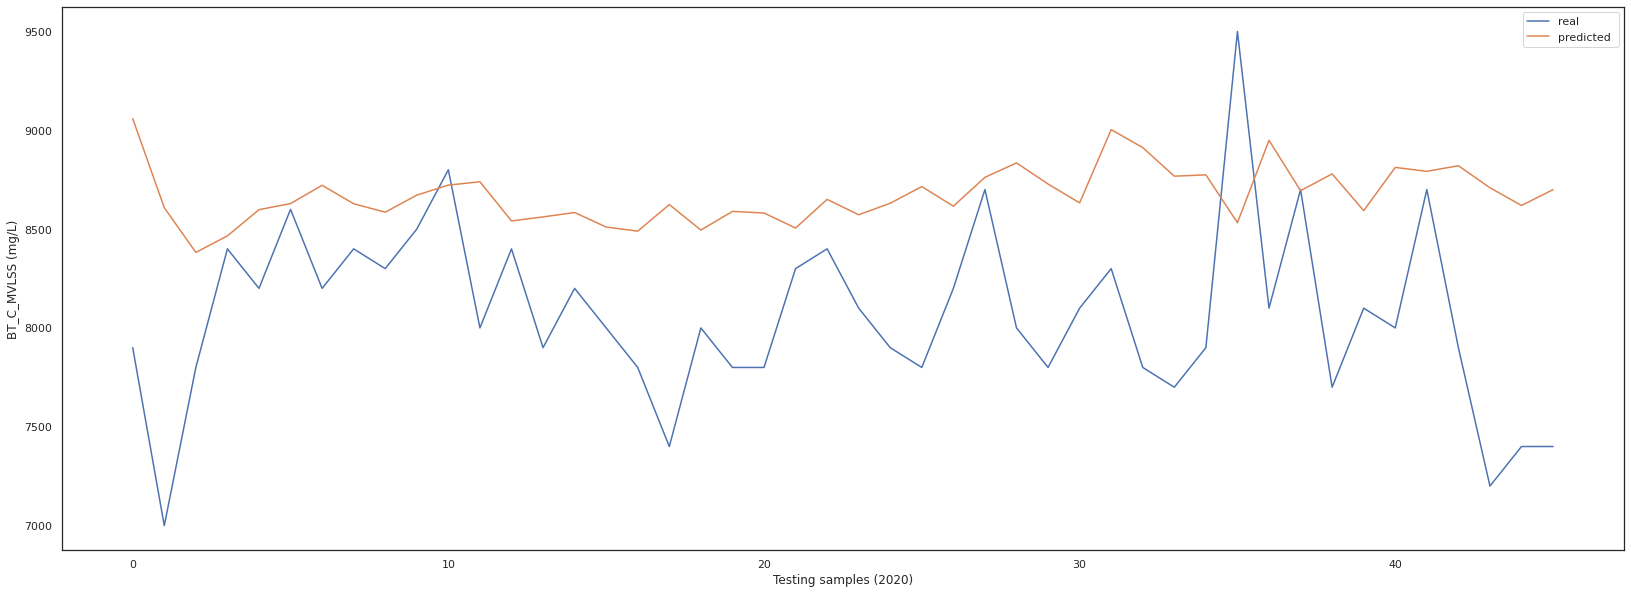

(46,)

In [40]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  8.219418450015052
R2:  -1.953180057578506


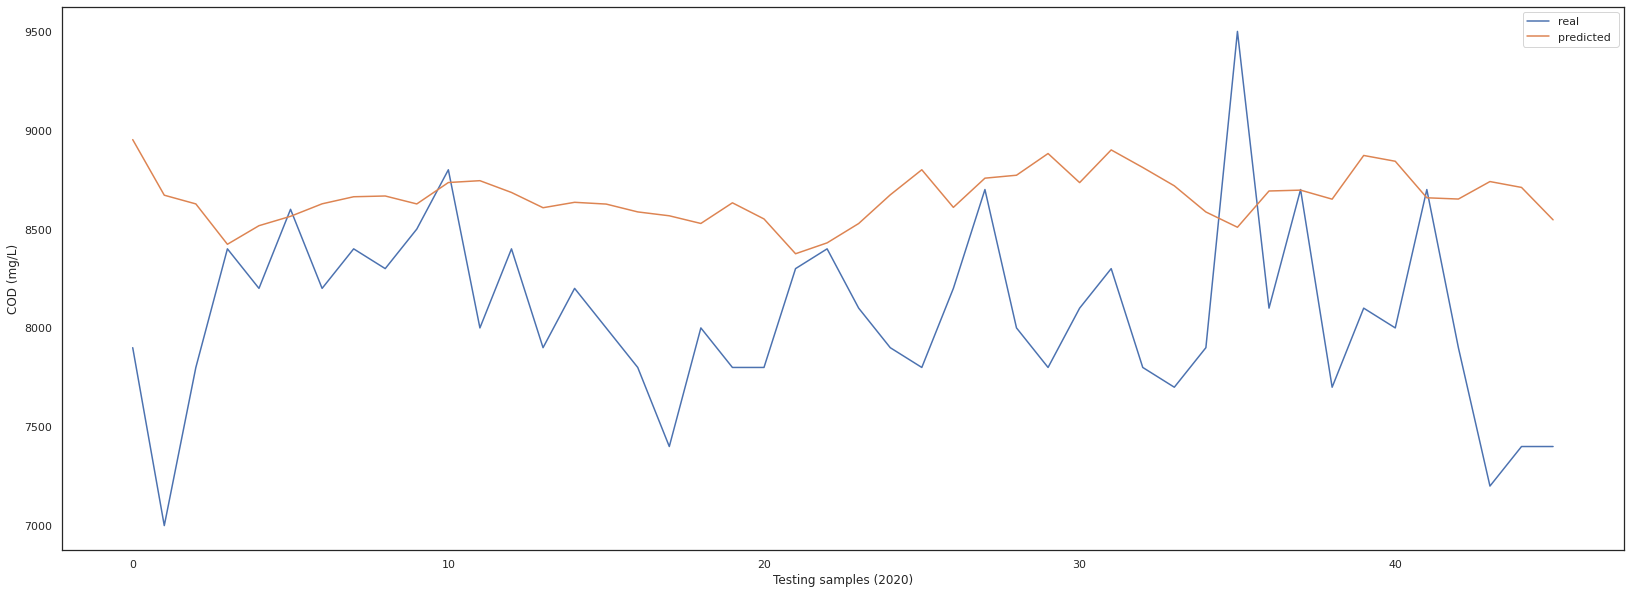

In [41]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[15.21958   10.5195     8.093185   5.08137    5.6020665  7.108255
  6.611482  10.457355  10.125789   8.089509  11.590834  11.201588
 10.259282   9.305622   9.800888   9.261166   9.217943   7.5060883
  7.506237   9.859608   6.338902   4.1888704  4.121264   6.766975
 10.233543  11.475851   8.730563  11.87638   11.303881  13.339378
 11.203437  15.286158  13.246801  11.766368   6.408511   6.7196393
  6.601161  10.859546   8.035505  13.32588   13.519088   7.5767546
  7.237714  10.915316  10.8325405  6.1880136], shape=(46,), dtype=float32)
MAPEsci:  75512.2951341712
MAPE:  9.359030064411874
R2:  -2.8797733019471936
RMSE:  876.1347200433833


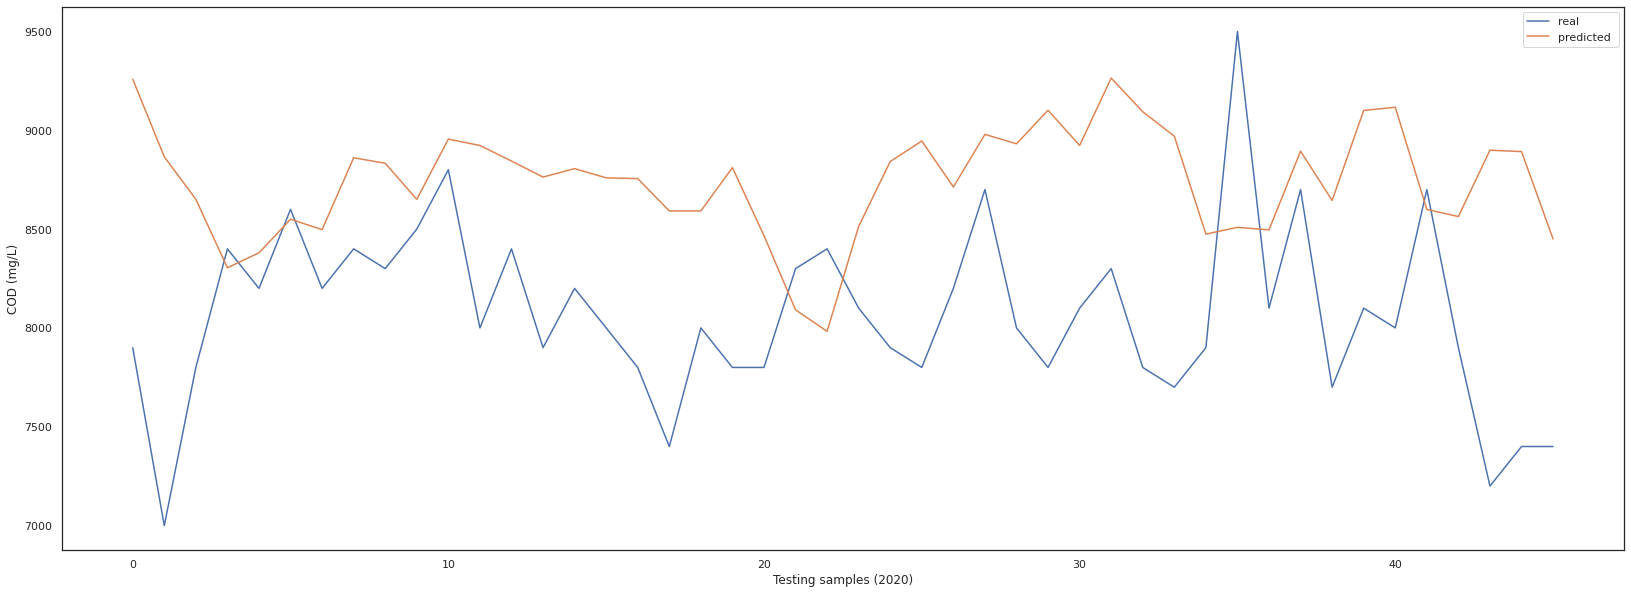

In [42]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[17.53231    7.4729486 16.192606   8.871377   9.591733   9.3820095
 14.095715   9.456986   7.555987  11.578998  11.515297  10.341298
  9.075381   7.3273973 10.294507   6.920911   9.893813  10.741522
 10.702918  11.052273  14.807076   9.245087   9.140512   7.2908425
 12.921645  18.078903  11.946361  14.048258  13.273397  14.334122
 11.857879  17.329943  14.8597355 12.095841  14.048598   7.5750976
 11.622618  12.272605  11.006919  11.3991    12.811178  15.5438
 12.542202  16.864918  15.436116  13.603897 ], shape=(46,), dtype=float32)
MAPE:  11.859839905238799
R2:  -4.758311930349493
RMSE:  1067.3707802952003


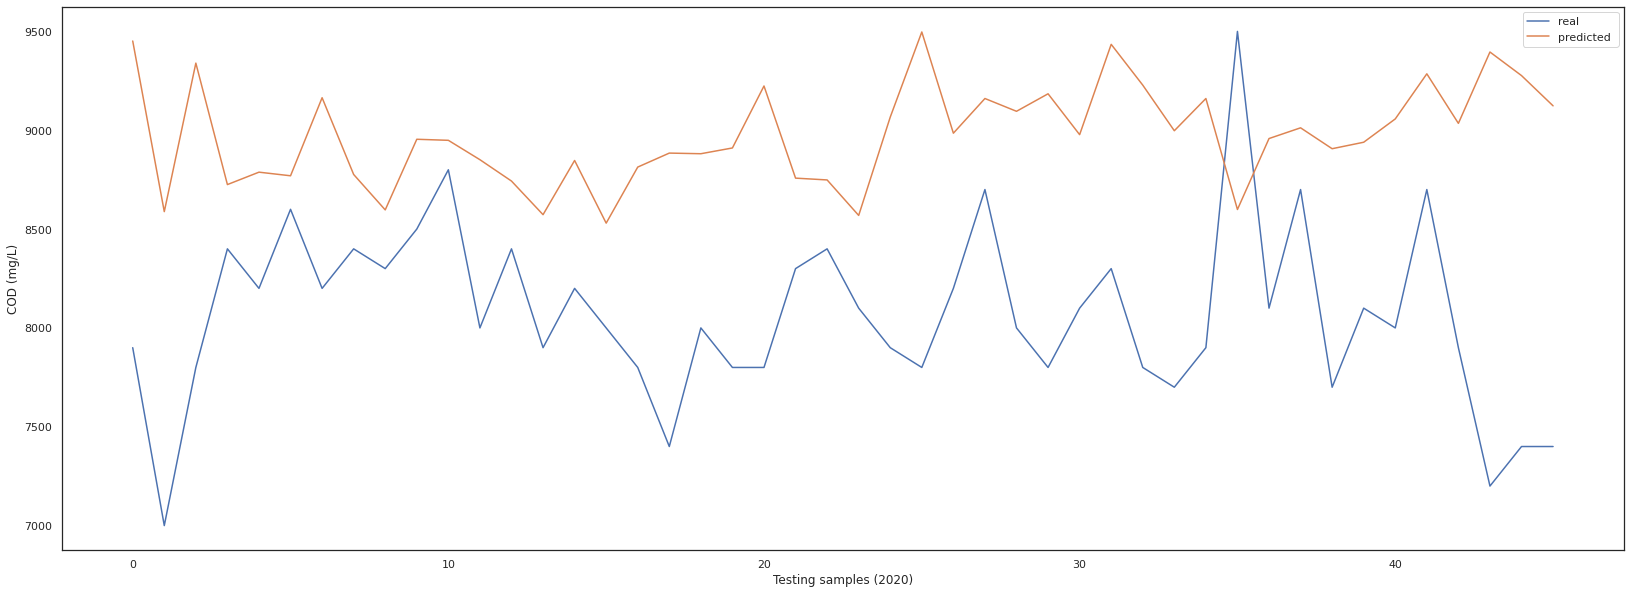

In [43]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

    BT_C_MVLSS    model1    model2    model3
0     0.306683  1.583046  0.149352  2.605679
1    -0.981933  1.110149 -0.470928  0.660069
2    -2.431626  0.456145  0.575277 -0.314610
3    -1.143010 -0.820296 -0.010906  0.045682
4    -0.176548 -0.604169  0.182965  0.617808
5    -0.498702 -0.109833 -0.063065  0.751312
6     0.145606 -0.377150  0.541191  1.149487
7    -0.498702  0.595639  0.001422  0.746986
8    -0.176548  0.735040 -0.000312  0.563252
9    -0.337625  0.049045  0.185360  0.934906
10   -0.015471  0.742700  0.192137  1.154479
11    0.467760  0.612656  0.378276  1.226601
12   -0.820856  0.957769  0.031152  0.372075
13   -0.176548  0.329877  0.013510  0.459988
14   -0.981933  0.506658 -0.013773  0.555363
15   -0.498702  0.672379 -0.069025  0.239209
16   -0.820856  0.143433  0.257658  0.148851
17   -1.143010  0.006399 -0.160059  0.728908
18   -1.787318  0.023851 -0.143483  0.173228
19   -0.820856  0.334903  0.147387  0.580010
20   -1.143010 -0.549735  0.475731  0.545323
21   -1.14

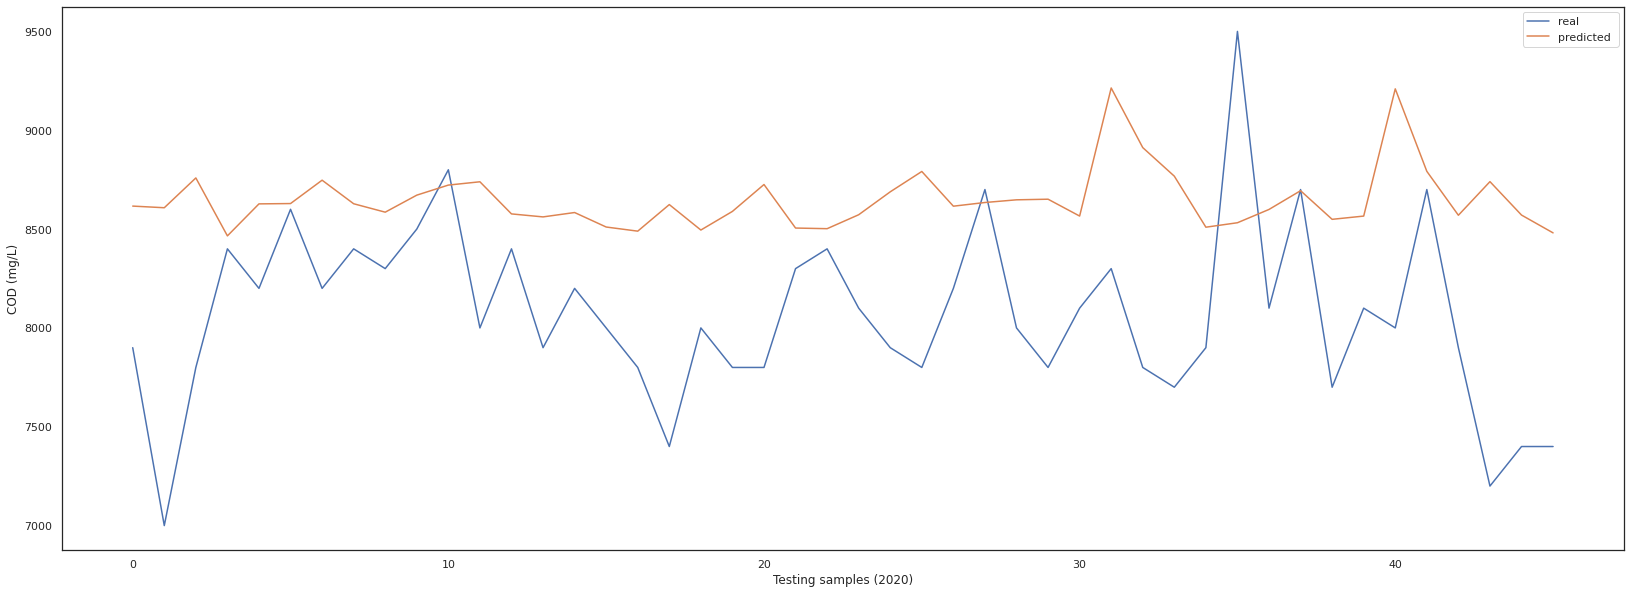

In [44]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [47]:
ensemble_model3.selection.to_list().count(1)

19

# EQ_COD

In [48]:
active_target = "EQ_COD"
# dataset = dataset1.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        230 non-null    object 
 1   Flow_to_EQ  230 non-null    object 
 2   Flow_efl    230 non-null    float64
 3   BT_C_MLSS   230 non-null    float64
 4   BT_C_MVLSS  230 non-null    float64
 5   BT_N_MLSS   230 non-null    float64
 6   BT_N_MVLSS  230 non-null    float64
 7   D_SS        230 non-null    float64
 8   EQ_N        230 non-null    float64
 9   BT_C_N      230 non-null    float64
 10  BT_N_N      230 non-null    float64
 11  D_N         230 non-null    float64
 12  OxT_PH_PM   230 non-null    float64
 13  EQ_PH       230 non-null    float64
 14  BT_N_PH     230 non-null    float64
 15  D_PH        230 non-null    float64
 16  BT_N_DO     230 non-null    float64
 17  BT_C_DO     230 non-null    float64
 18  Clari_DO    230 non-null    float64
 19  F/M         230 non-null    f

## Approach 1

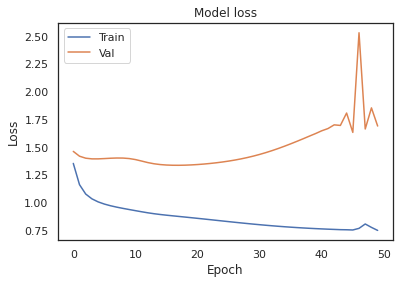

*** ANN estimation ***
MAPE:  8.509959718163604
R2:  0.3972543177572182
RMSE:  33.16679955824795


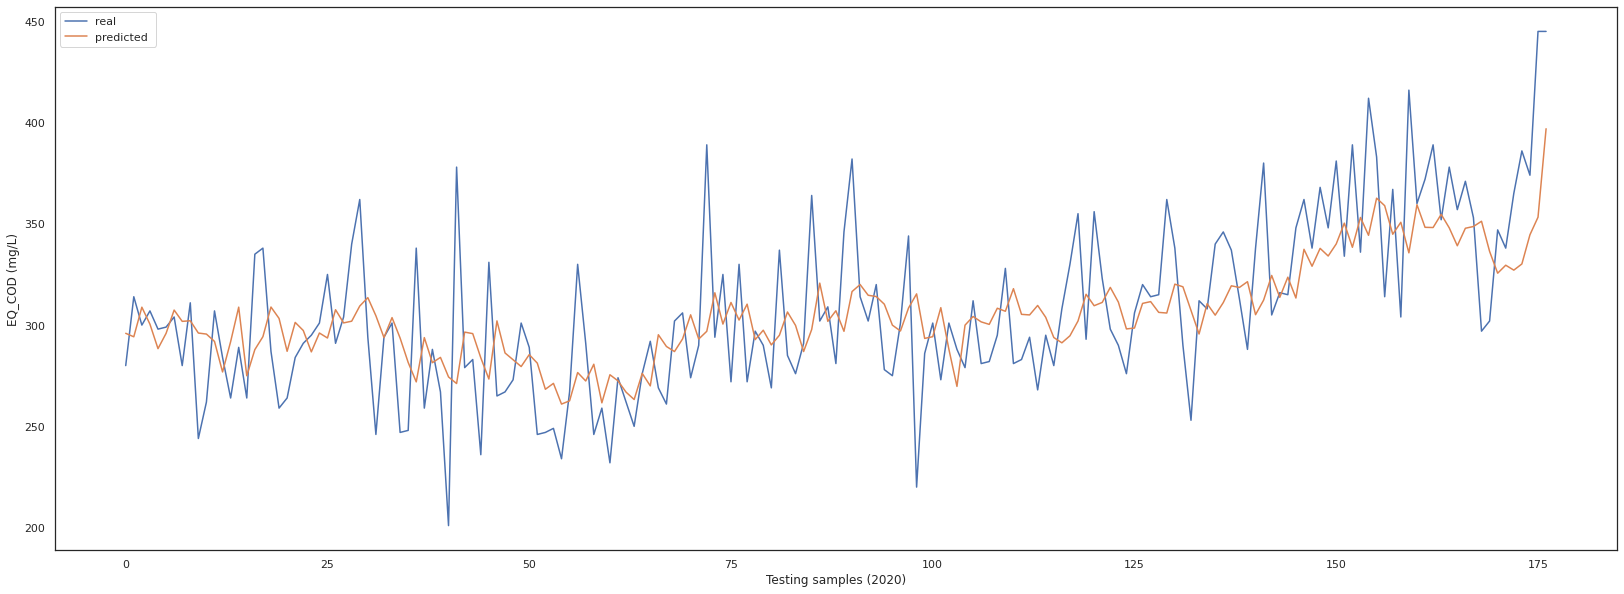

(177,)

In [49]:
# cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[2:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

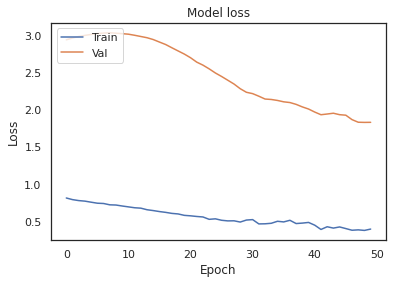

*** LSTM estimation ***
MAPE:  11.510458470228912
R2:  0.4259492412106449
RMSE:  32.36768655691422


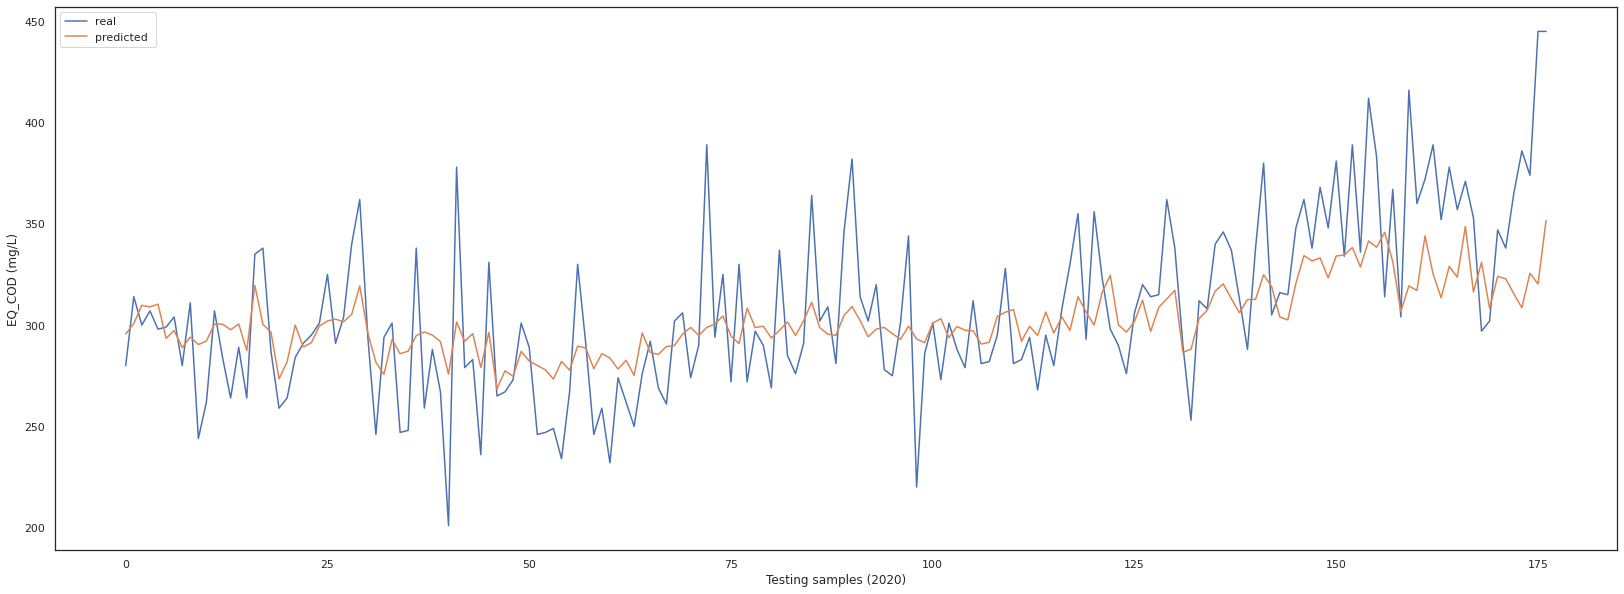

(177, 1)

In [50]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=7)
app2.supervised
app2.training()
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  8.194772226804679
R2:  0.39876355262356
RMSE:  33.12524980883378


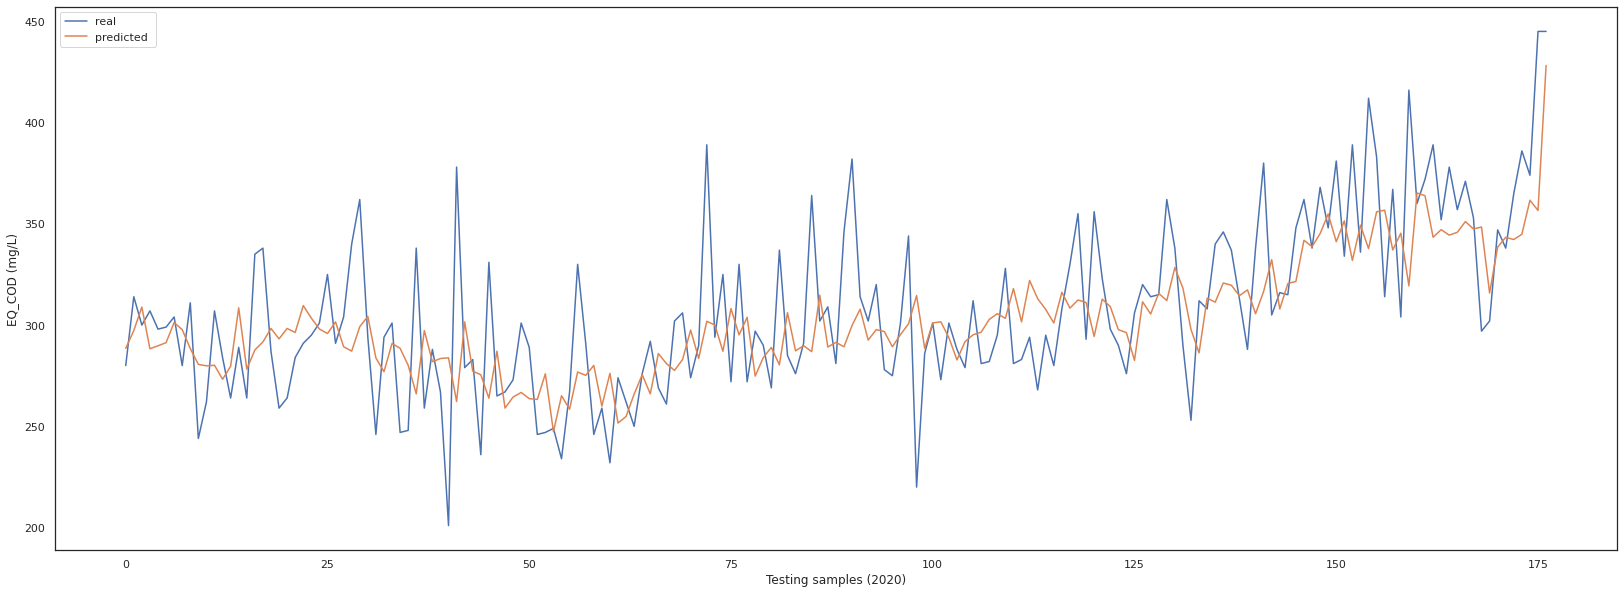

(177,)

In [51]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

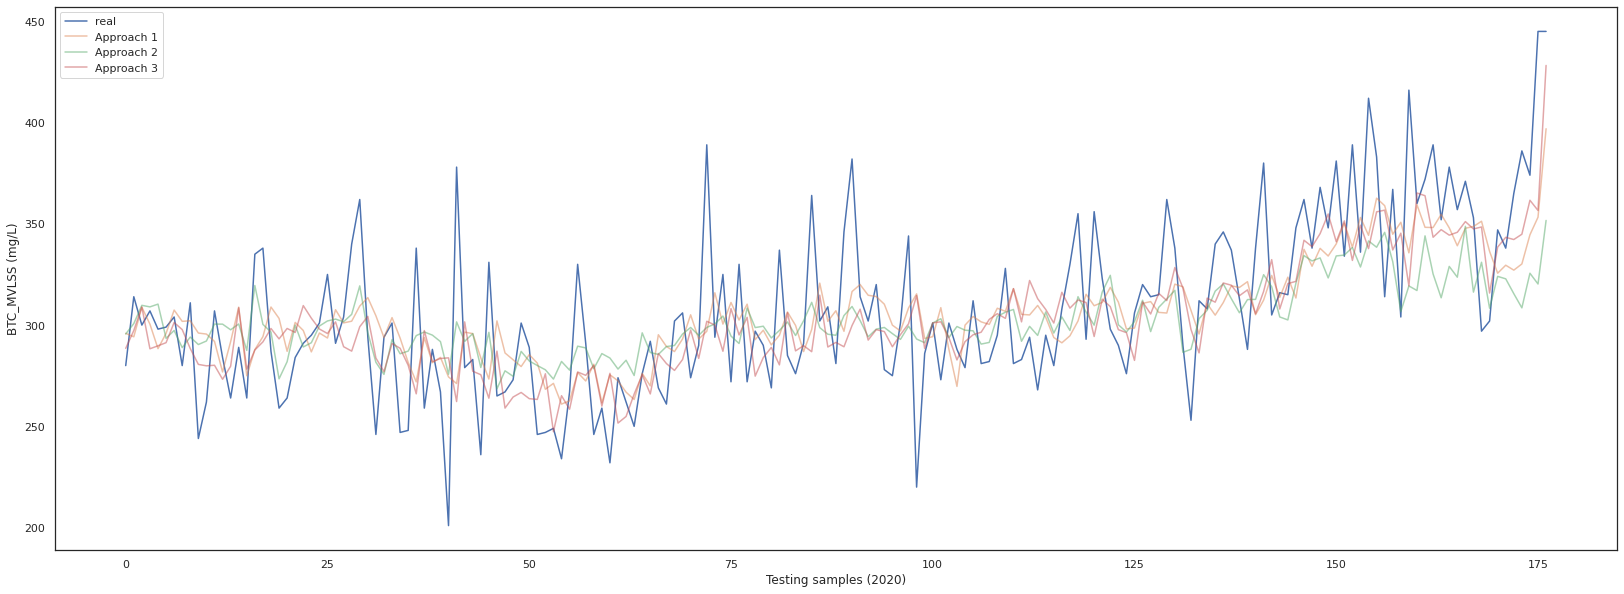

In [52]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [53]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0       880.054115
1       892.257896
2       927.486007
3       897.744653
4       888.493455
          ...     
172     984.881520
173     983.547374
174    1031.812955
175    1030.150364
176    1176.804654
Length: 177, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  8.176694285212276
R2:  0.4130144434238041
RMSE:  32.7303176124911


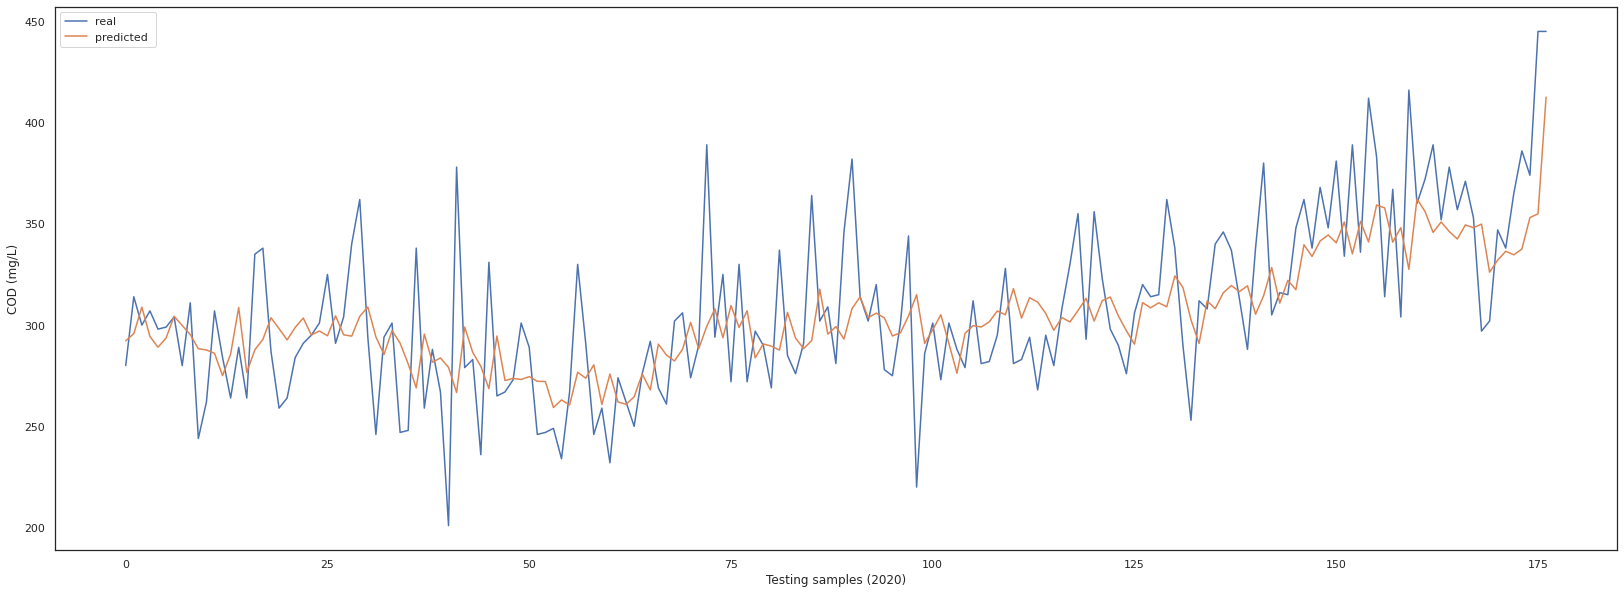

In [54]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  7.924314253032586
R2:  0.44310808186016615
RMSE:  31.880268452267092


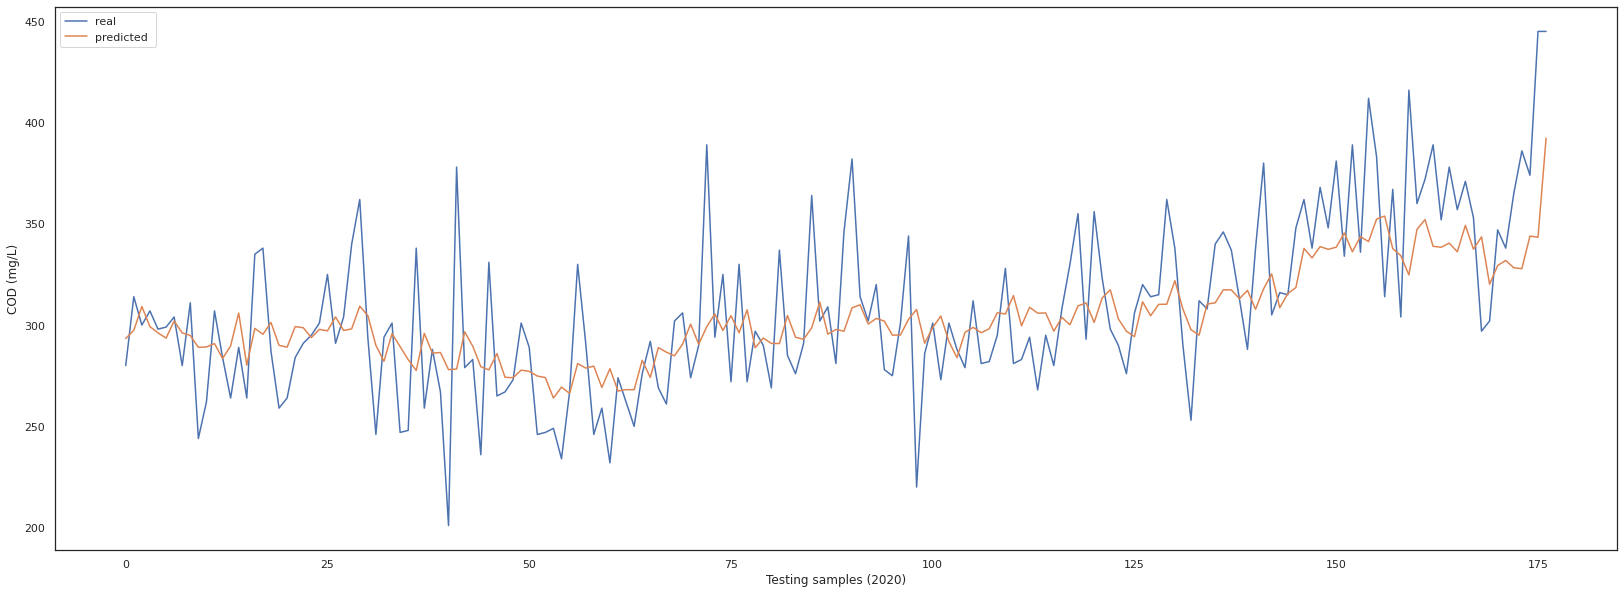

In [55]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

Epoch 1/50
5/5 [==============================] - 0s 36ms/step - loss: 1.3534 - MAPE: 211.6850 - val_loss: 13.2655 - val_MAPE: 280.5591
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 1.3156 - MAPE: 209.6582 - val_loss: 12.8842 - val_MAPE: 275.2191
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 1.2776 - MAPE: 206.5143 - val_loss: 12.5137 - val_MAPE: 269.9473
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 1.2467 - MAPE: 203.3303 - val_loss: 12.1416 - val_MAPE: 264.5372
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.2109 - MAPE: 201.1036 - val_loss: 11.7956 - val_MAPE: 259.4406
Epoch 6/50
5/5 [==============================] - 0s 8ms/step - loss: 1.1746 - MAPE: 197.3890 - val_loss: 11.4836 - val_MAPE: 254.7899
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 1.1500 - MAPE: 195.4604 - val_loss: 11.1571 - val_MAPE: 249.8434
Epoch 8/50
5/5 [==============================] - 0s 7

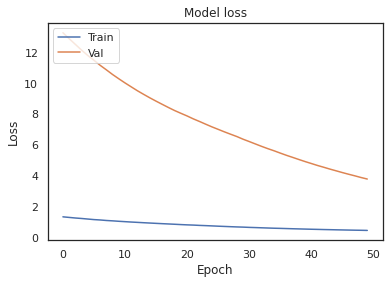

In [56]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[10.47958   10.960801  13.066283  13.073479  13.703157  10.590389
 10.635797  11.011635  10.481644  10.916267  10.693661  10.904776
 10.682813  10.548065  11.35171   12.802196  15.388997  10.9336605
 10.573904  15.511638  13.859679  11.01318   11.211226  11.280933
 10.768618  11.268233  12.009786  11.296197  12.050138  13.943726
 10.600803  12.370477  15.374197  10.513032  12.023732  12.422675
 10.70611   10.481931  10.590068  11.159654  17.592066  10.825442
 10.771826  10.478667  14.99441   10.503644  17.746752  15.198994
 16.82586   12.487107  13.487066  14.7016735 17.189568  18.52527
 16.033056  17.660654  12.071776  12.590976  15.632844  14.298569
 14.006266  16.227543  15.005736  18.926704  10.530123  13.416743
 11.9835825 11.377567  11.37585   10.478496  10.8632145 10.488158
 10.646877  11.171043  11.848283  10.49499   10.6904745 12.971358
 10.557209  10.784157  10.664452  10.527851  11.535461  10.478409
 11.135985  13.611298  1

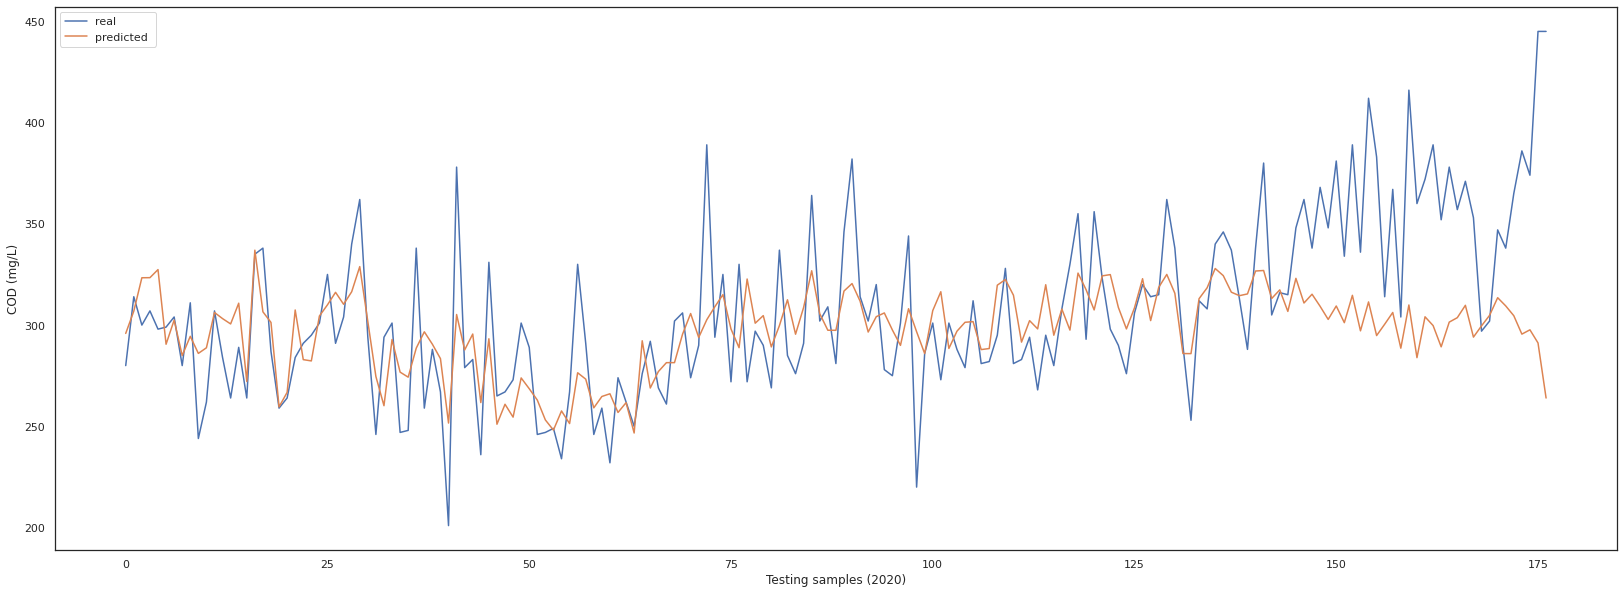

In [57]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


Epoch 1/50
5/5 [==============================] - 0s 37ms/step - loss: 1.0907 - MAPE: 254.4328 - val_loss: 3.7952 - val_MAPE: 108.7115
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.0222 - MAPE: 239.7041 - val_loss: 3.7171 - val_MAPE: 106.3452
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.9696 - MAPE: 229.3179 - val_loss: 3.6413 - val_MAPE: 104.0254
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.9178 - MAPE: 217.8011 - val_loss: 3.5632 - val_MAPE: 101.6239
Epoch 5/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8732 - MAPE: 205.8942 - val_loss: 3.4921 - val_MAPE: 100.3421
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.8355 - MAPE: 195.5918 - val_loss: 3.4287 - val_MAPE: 99.2230
Epoch 7/50
5/5 [==============================] - 0s 9ms/step - loss: 0.8077 - MAPE: 186.2489 - val_loss: 3.3623 - val_MAPE: 98.5916
Epoch 8/50
5/5 [==============================] - 0s 6ms/step -

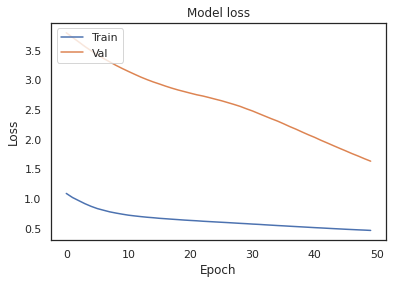

In [58]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[10.481544  10.649971  12.013494  12.477368  12.21834   10.486059
 11.055194  10.478826  10.477262  10.6057005 11.27489   10.486952
 10.521142  10.480851  10.711382  11.46759   12.111879  11.072378
 11.192136  13.247339  12.973647  10.516285  10.61369   10.5302925
 10.907825  11.214094  11.504318  10.987646  11.754553  11.737807
 10.749665  11.856465  15.344006  10.480603  10.923329  12.492394
 11.721494  10.674318  10.892124  10.638092  14.955243  12.387573
 10.47935   10.527926  13.521051  11.752606  14.0977745 16.133976
 16.492022  12.432431  13.174129  14.1853075 16.141392  19.82234
 15.615526  17.794615  11.684459  10.859876  13.147357  14.664242
 13.258718  17.881697  14.769198  16.866438  11.179071  12.638989
 11.165558  11.147799  11.341716  10.483701  11.219367  10.508661
 10.736956  10.590785  11.355076  11.170518  10.562614  11.607122
 10.482275  10.633724  10.477073  10.481301  11.384453  10.480447
 10.572965  12.572633  1

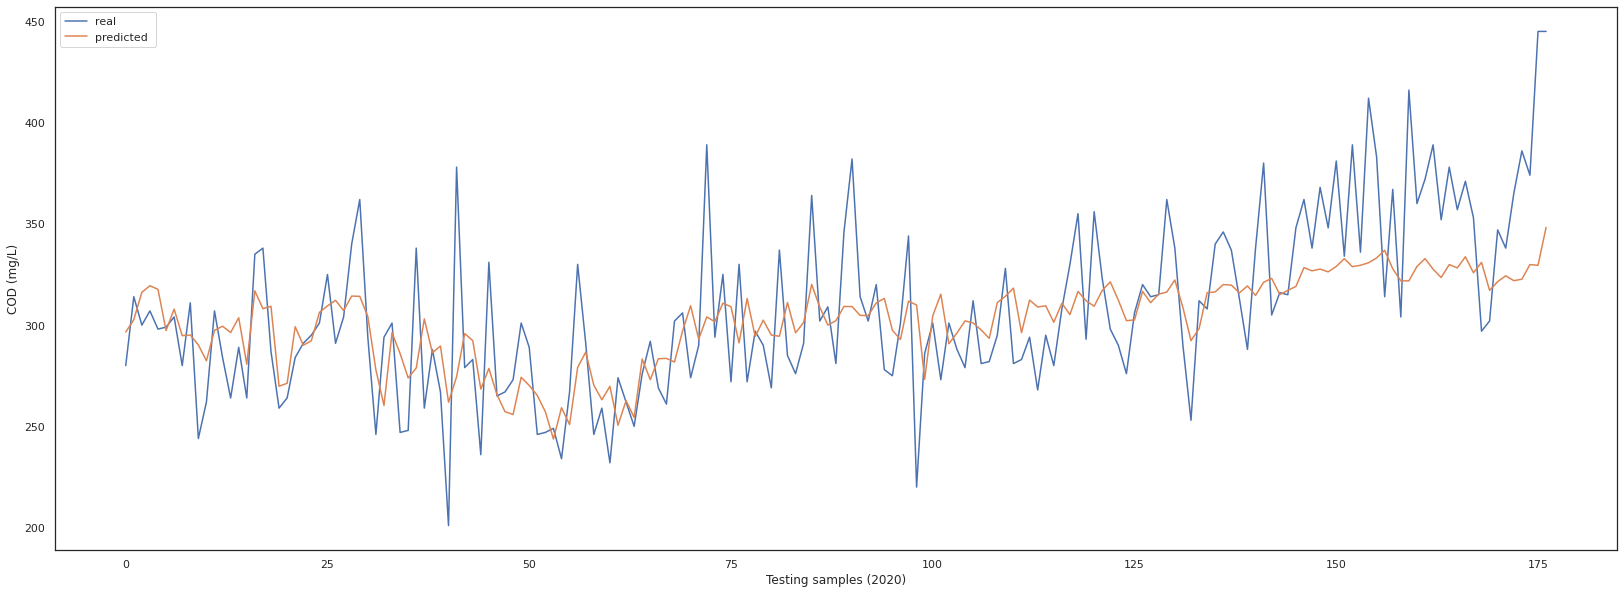

In [59]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

     0  1  2
0    0  0  1
1    0  1  0
2    1  0  0
3    0  1  0
4    0  0  1
..  .. .. ..
172  0  0  1
173  0  0  1
174  0  0  1
175  0  0  1
176  0  0  1

[177 rows x 3 columns]
(177, 3)
(177, 4)
Epoch 1/50
5/5 [==============================] - 1s 45ms/step - loss: 1.0940 - accuracy: 0.3522 - val_loss: 1.2906 - val_accuracy: 0.1111
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.0891 - accuracy: 0.3585 - val_loss: 1.2897 - val_accuracy: 0.1667
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 1.0849 - accuracy: 0.3648 - val_loss: 1.2952 - val_accuracy: 0.1111
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.0812 - accuracy: 0.3836 - val_loss: 1.2984 - val_accuracy: 0.1111
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.0769 - accuracy: 0.4151 - val_loss: 1.2959 - val_accuracy: 0.1111
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 1.0735 - accuracy: 0.4214 - val_loss: 1.3

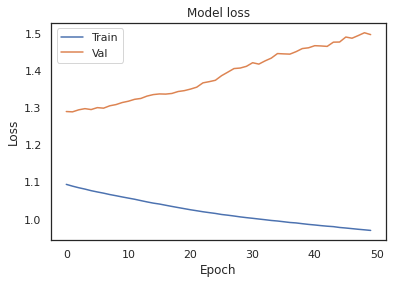

In [60]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

       EQ_COD    model1    model2    model3
0   -0.716060 -0.424558 -0.416571 -0.516418
1   -0.643993 -0.498220 -0.102959 -0.193633
2    0.172772  0.128104  0.446746  0.232867
3   -0.163543 -0.230729  0.399871 -0.524417
4    0.004614 -0.748967  0.483309 -0.470288
..        ...       ...       ...       ...
172  0.749312  0.912264  0.797957  1.458504
173  1.397919  1.043069  0.370748  1.554744
174  1.902392  1.660290  1.413290  2.171286
175  1.614122  2.032593  1.089222  1.986156
176  3.319719  3.904525  3.003282  4.618085

[177 rows x 4 columns]      0  1  2
0    0  0  1
1    0  1  0
2    1  0  0
3    0  1  0
4    0  0  1
..  .. .. ..
172  0  0  1
173  0  0  1
174  0  0  1
175  0  0  1
176  0  0  1

[177 rows x 3 columns]
6/6 [==============================] - 0s 2ms/step - loss: 1.0222 - accuracy: 0.4689
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(7.7751176519677765, shape=(), dtype=float64)
MAPEsci:  2435.9043393563516
MAPE:  7.775117651967777
R2:  0.4332572640066148
RMSE:  32

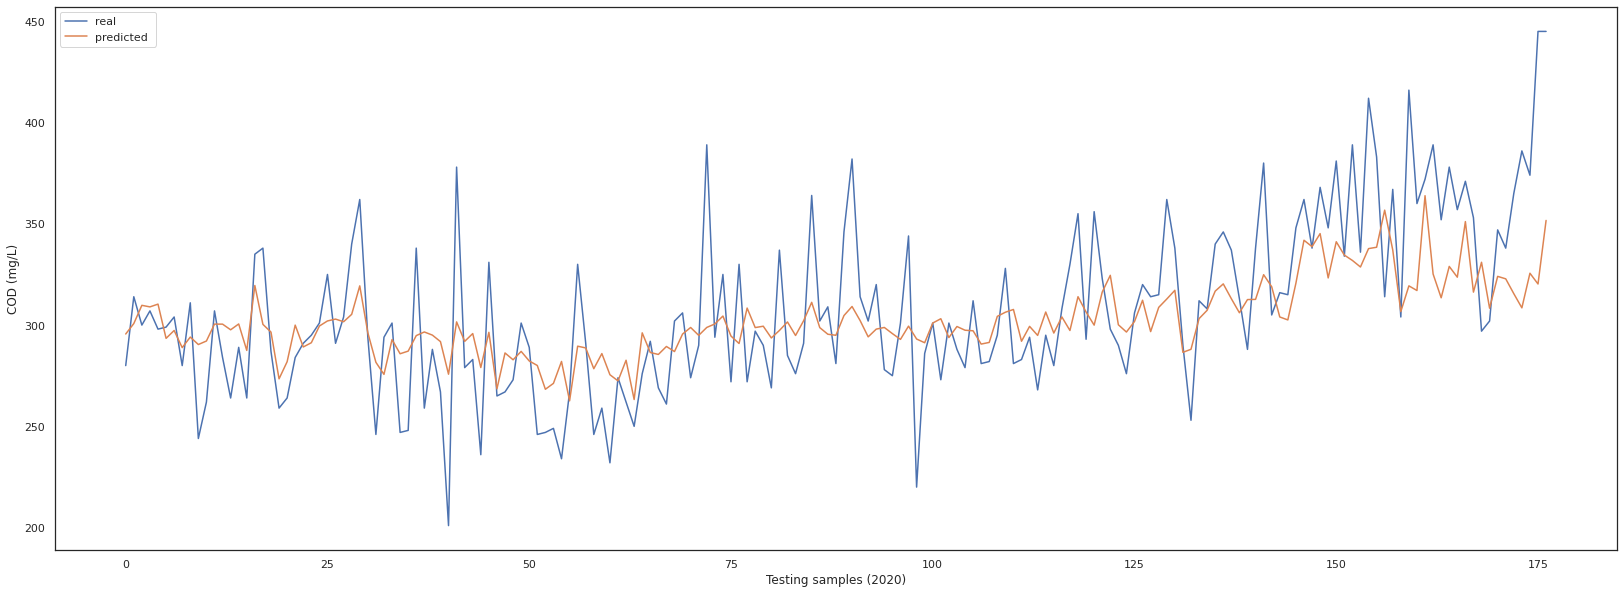

In [61]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [62]:
ensemble_model3.selection.to_list().count(1)

156

### Ensemble 4

In [63]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [64]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  8.128418808285769
R2:  0.07387755799508688
RMSE:  38.613506183748534


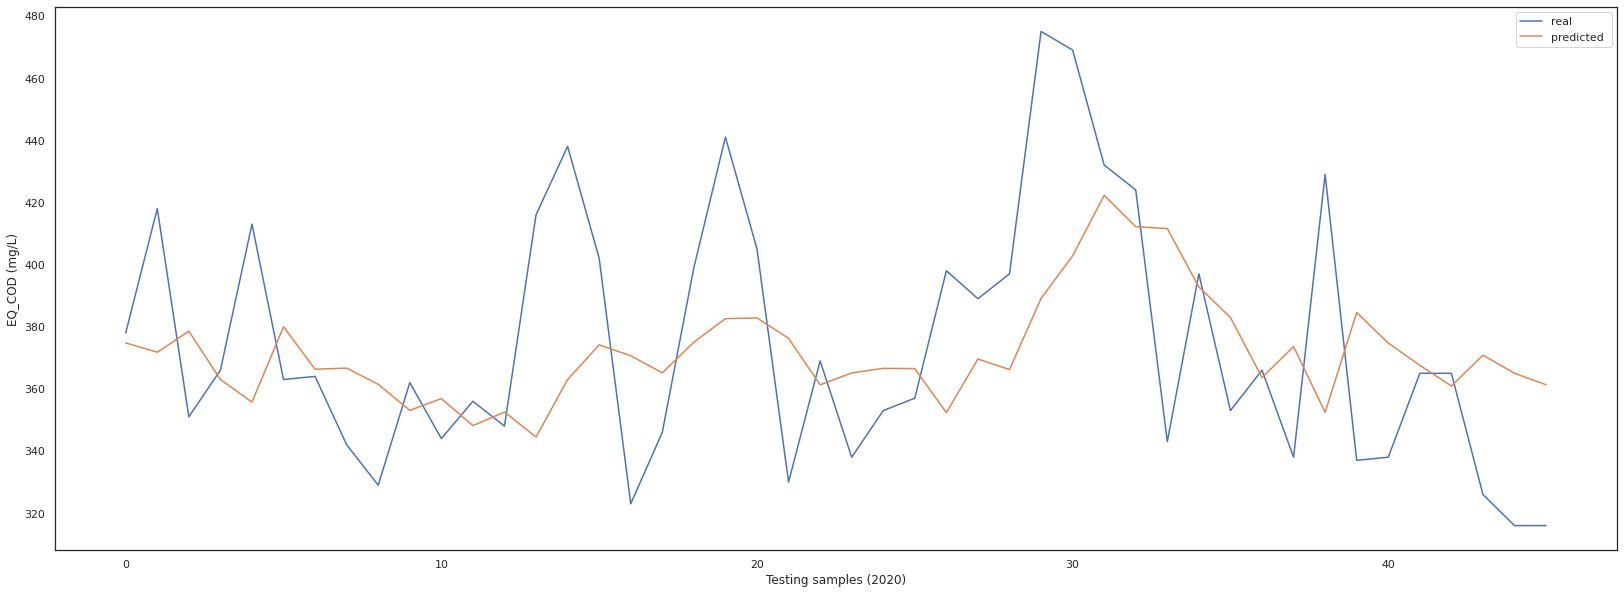

(46,)

In [65]:
app1.testing(dataset.iloc[-(cut_off + 5):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  11.649754411002572
R2:  -1.126391072870816
RMSE:  58.509529295605844


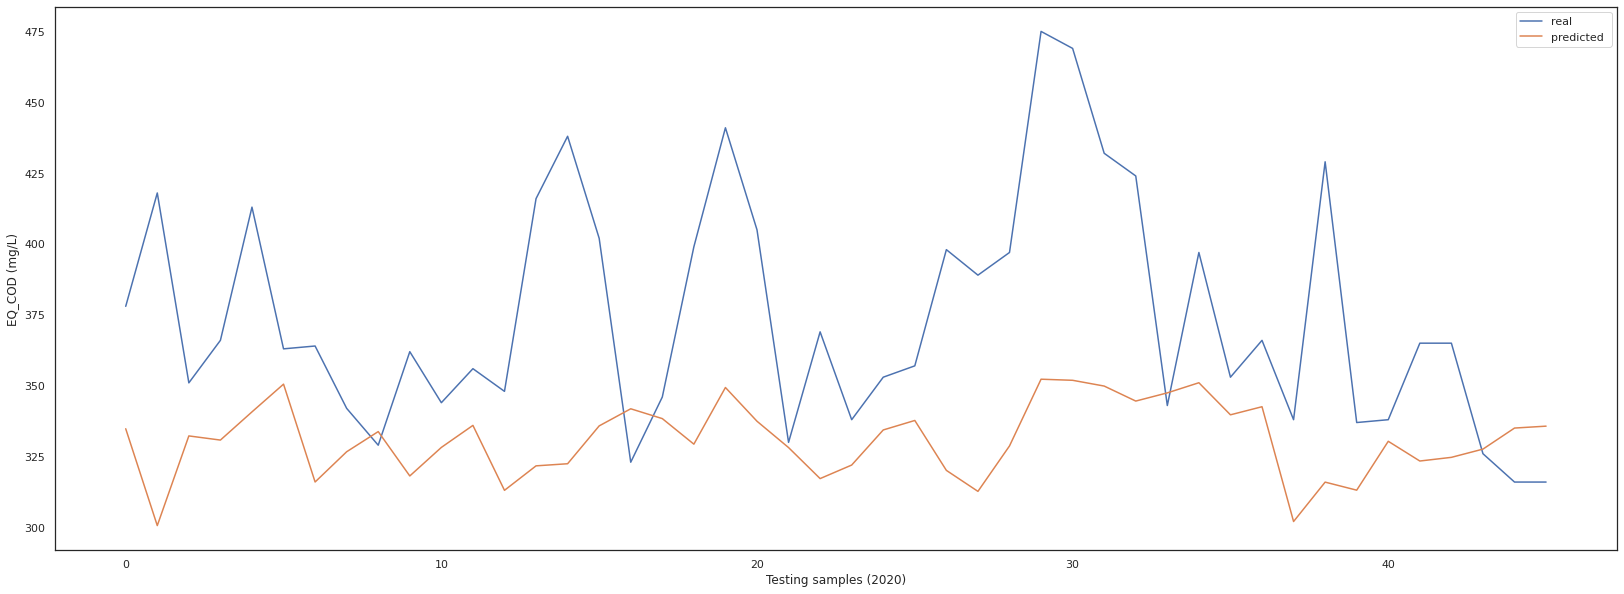

(46, 1)

In [66]:
app2.testing(dataset.iloc[-(cut_off + 7):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  7.898610307257119
R2:  0.17318886444846404
RMSE:  36.4844826764427


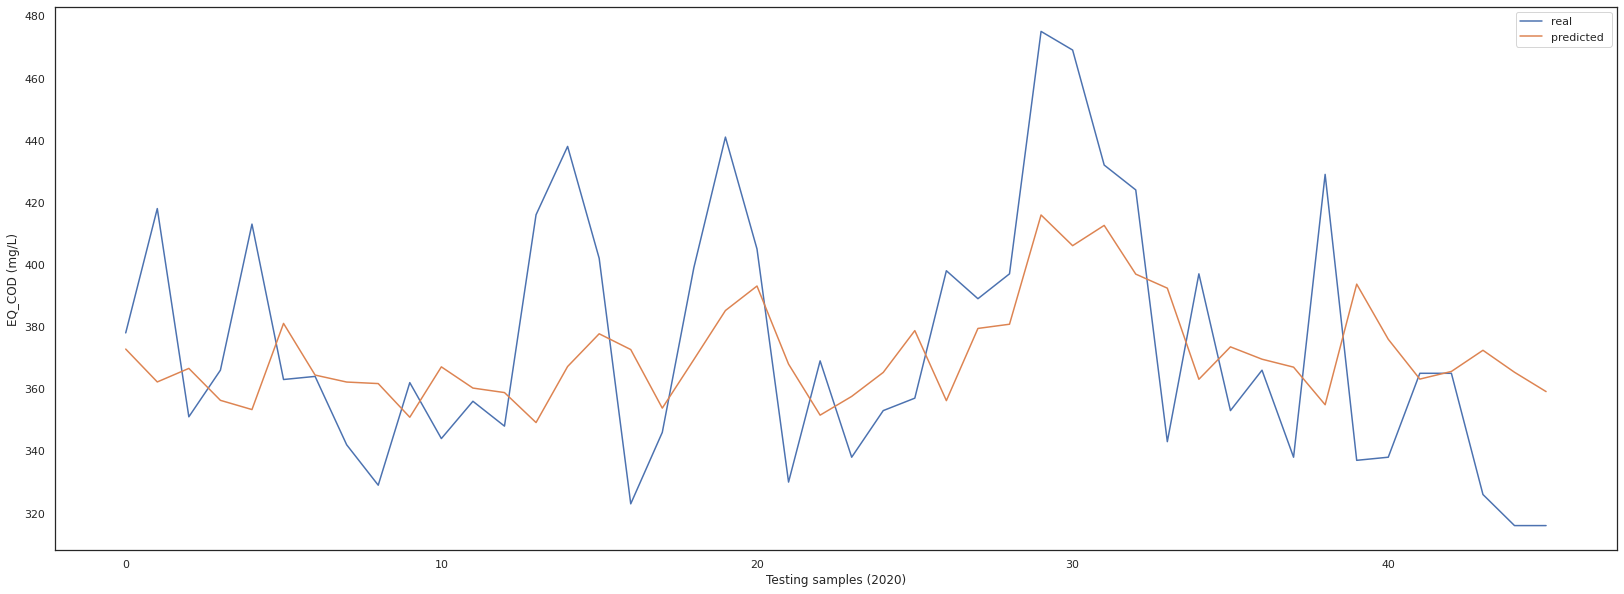

(46,)

In [67]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  8.233329856873272


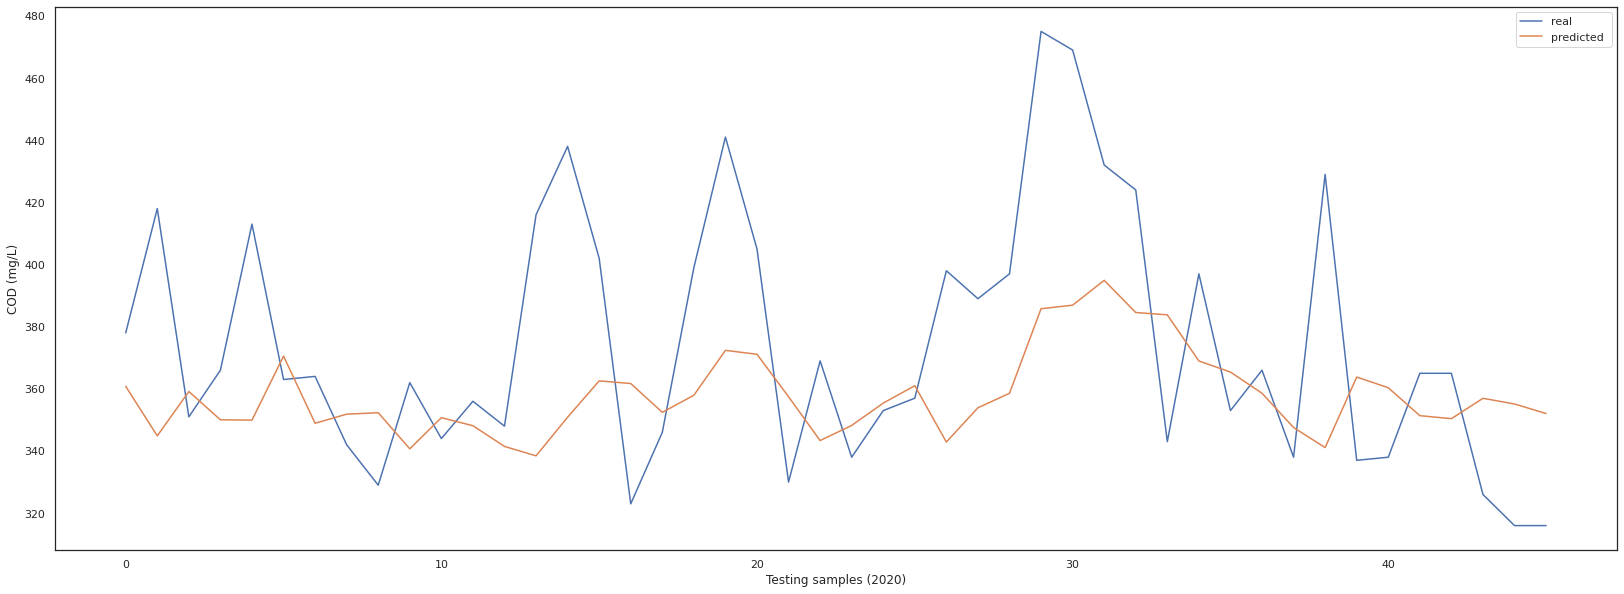

In [68]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[23.887178 25.60109  24.417439 21.492872 18.826632 23.140747 24.515453
 23.004318 21.19916  21.265465 21.569939 18.71837  22.37551  19.321825
 23.310255 23.971891 22.286388 20.65836  24.43046  23.978952 26.115194
 24.692396 22.729425 23.085875 22.16548  22.579983 21.2338   26.709
 23.859634 26.61014  28.177994 31.945208 30.044607 29.265678 23.925745
 24.567938 20.880148 26.038483 21.718737 29.528702 24.675133 23.641085
 22.580042 24.19807  21.829319 20.75605 ], shape=(46,), dtype=float32)
MAPEsci:  9194.528330927309
MAPE:  23.72882962701956
R2:  -5.470759508461838
RMSE:  102.06636867635258


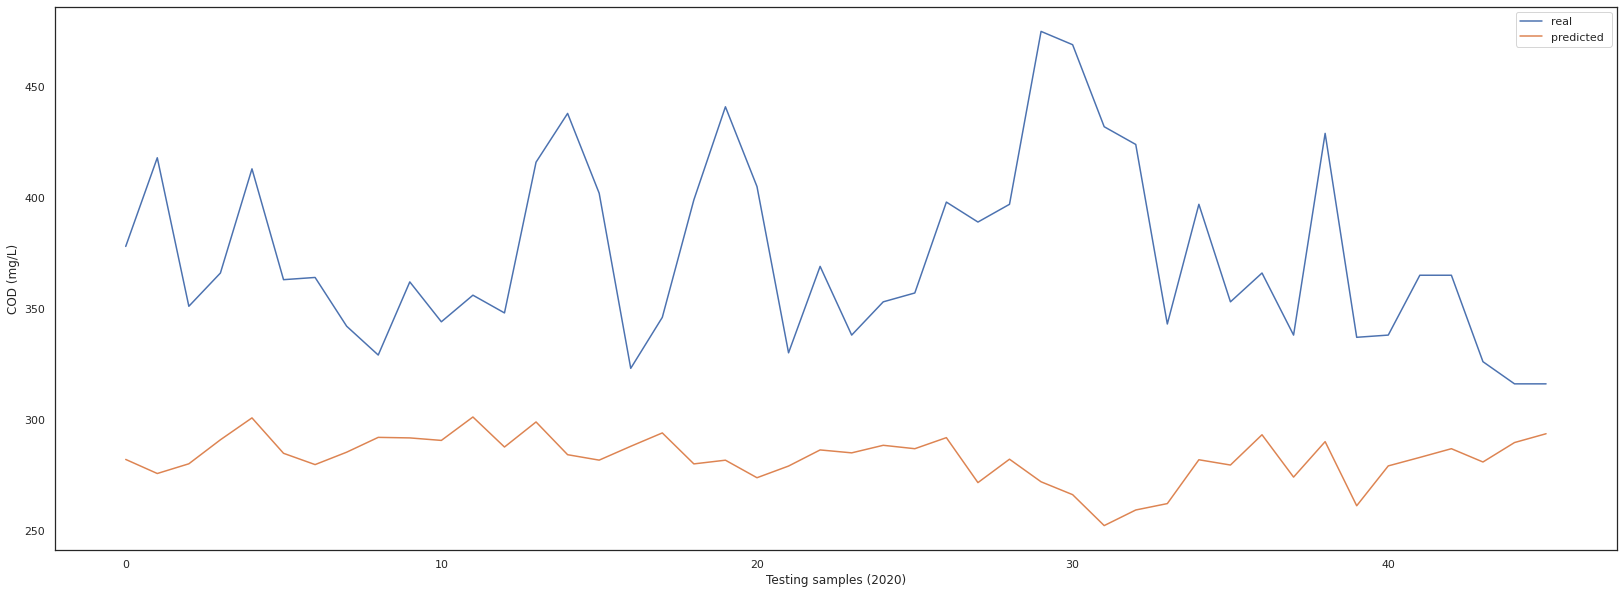

In [69]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[10.585769  13.078526  10.948396  10.884834  10.613637   9.210946
 11.5106125 10.96282   10.894857  11.951039  11.116295  11.355333
 11.917662  11.998396  11.2461195 10.116349   9.778433  10.726917
 10.471172   9.257498   9.464842  10.99555   11.913961  11.558263
 10.710158  10.499466  11.616763  11.138107  10.490691   9.122791
  8.844881   8.871853   9.317707   9.32633    9.7476635  9.99021
 10.408564  12.552175  11.98853   10.758643  10.562992  11.056361
 11.03496   10.536222  10.872414  11.077833 ], shape=(46,), dtype=float32)
MAPE:  10.719207315494907
R2:  -0.920998872161287
RMSE:  55.612009597450594


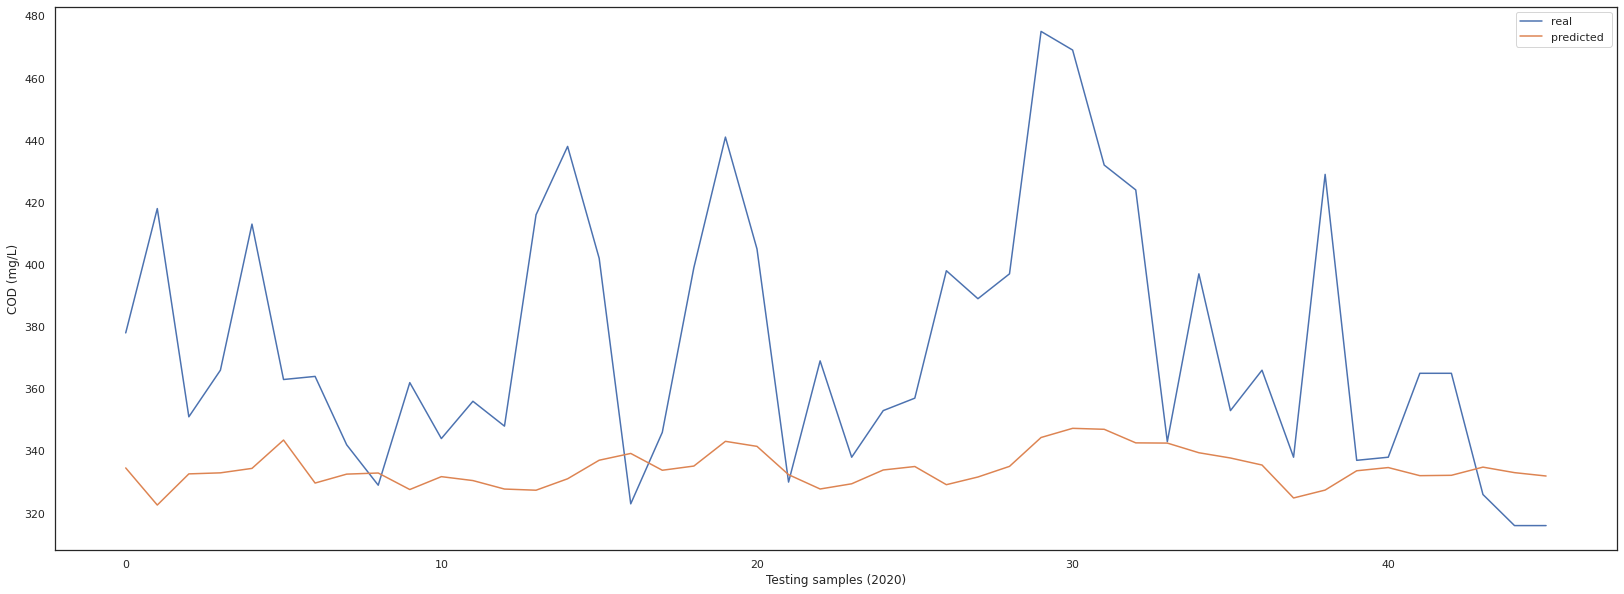

In [70]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

      EQ_COD    model1    model2    model3
0   0.244839  2.954650  1.975023  2.581530
1   1.710212  2.825748 -0.109135  2.192898
2   2.671112  3.116656  1.820580  2.352975
3   1.061604  2.449461  1.731236  1.975432
4   1.421942  2.137880  2.337778  1.866115
5   2.550999  3.177208  2.934929  2.885081
6   1.349874  2.591113  0.829202  2.274242
7   1.373897  2.607160  1.480048  2.191686
8   0.845402  2.383110  1.913778  2.173558
9   0.533109  2.024116  0.959054  1.775382
10  1.325852  2.186363  1.573225  2.371228
11  0.893447  1.813375  2.047131  2.120427
12  1.181717  2.001876  0.649836  2.067146
13  0.989537  1.655183  1.176496  1.712487
14  2.623067  2.448562  1.221938  2.375368
15  3.151562  2.927348  2.036368  2.762423
16  2.286752  2.777685  2.404562  2.575891
17  0.388974  2.541756  2.193364  1.883364
18  0.941492  2.964333  1.643288  2.457859
19  2.214684  3.288915  2.862540  3.037437
20  3.223629  3.298657  2.136628  3.327293
21  2.358819  3.017756  1.569849  2.403908
22  0.55713

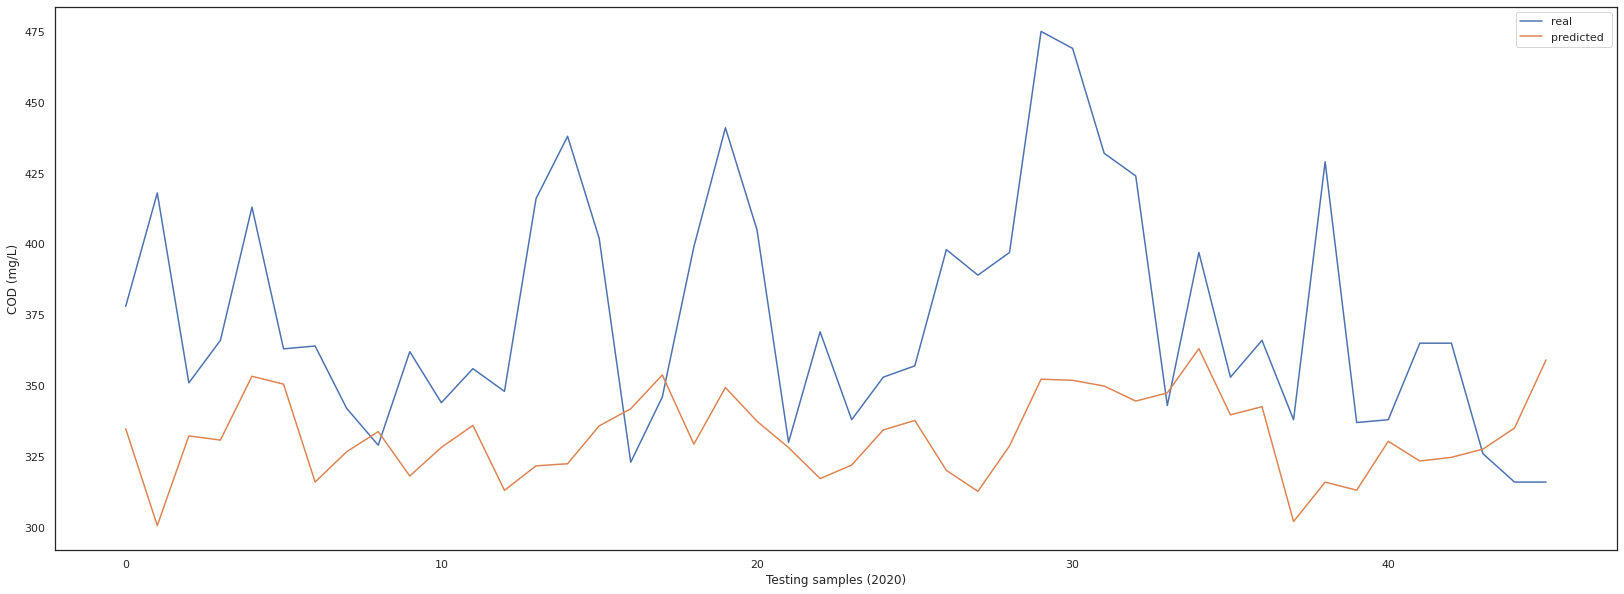

In [71]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [72]:
ensemble_model3.selection.to_list().count(3)

0

# D_COD_ON

In [79]:
active_target = "D_COD_ON"
# dataset = dataset1.copy()
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        230 non-null    object 
 1   Flow_to_EQ  230 non-null    object 
 2   Flow_efl    230 non-null    float64
 3   BT_C_MLSS   230 non-null    float64
 4   BT_C_MVLSS  230 non-null    float64
 5   BT_N_MLSS   230 non-null    float64
 6   BT_N_MVLSS  230 non-null    float64
 7   D_SS        230 non-null    float64
 8   EQ_N        230 non-null    float64
 9   BT_C_N      230 non-null    float64
 10  BT_N_N      230 non-null    float64
 11  D_N         230 non-null    float64
 12  OxT_PH_PM   230 non-null    float64
 13  EQ_PH       230 non-null    float64
 14  BT_N_PH     230 non-null    float64
 15  D_PH        230 non-null    float64
 16  BT_N_DO     230 non-null    float64
 17  BT_C_DO     230 non-null    float64
 18  Clari_DO    230 non-null    float64
 19  F/M         230 non-null    f

## Approach 1

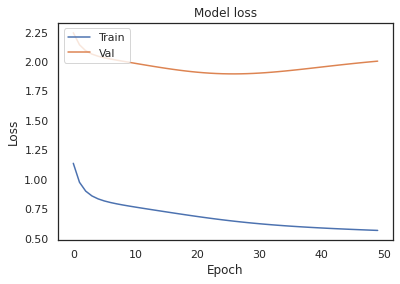

*** ANN estimation ***
MAPE:  11.598506475092277
R2:  0.42273459900190014
RMSE:  18.111560597869296


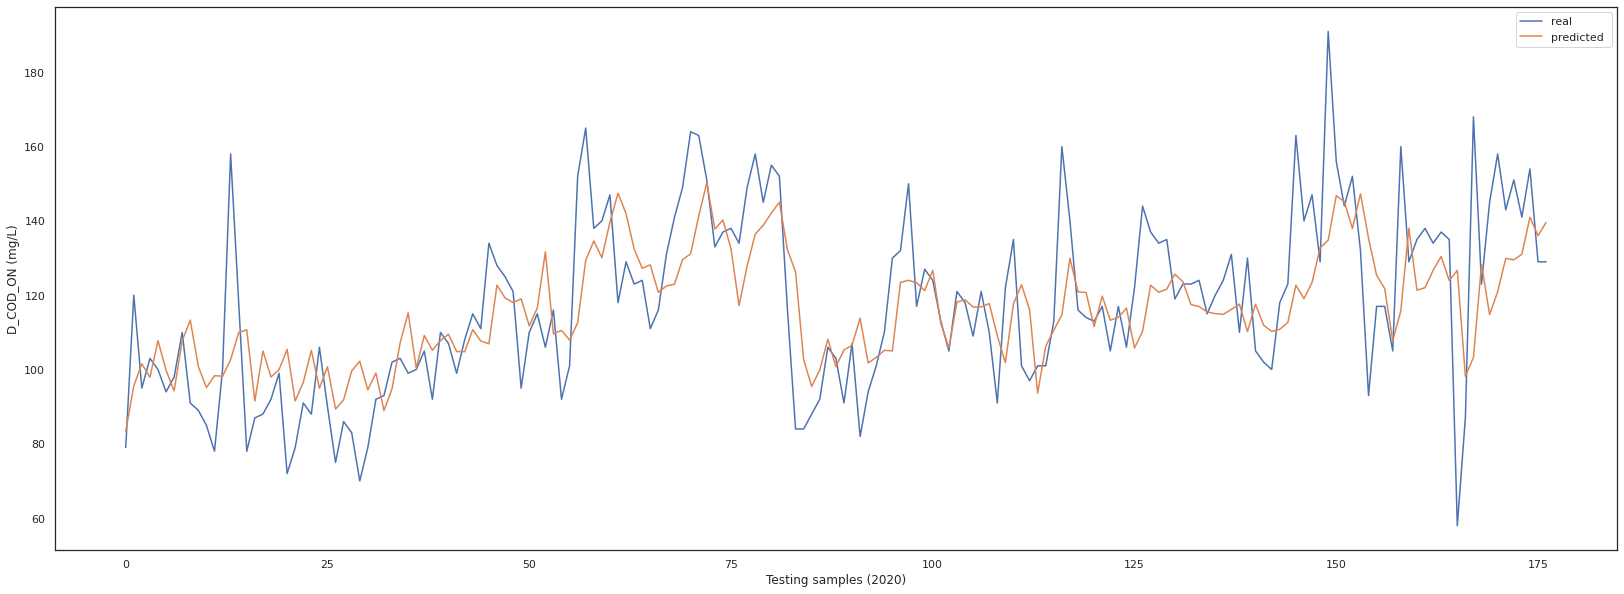

(177,)

In [80]:
# cut_off = 68
app1 = approach1(dataset.iloc[:-cut_off], active_target)
# app1.tune()
# print(app1.best_tuned)
# with open('EQ_COD1.pickle', 'wb') as handle:
#   pickle.dump(app1.best_tuned, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('EQ_COD_tuning_1.pickle', 'wb') as handle:
#   pickle.dump(app1.tune_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
app1.training()
app1.testing(dataset.iloc[2:-cut_off])
# app1.testing(dataset.iloc[-142:])
app1.full_prediction.shape

## Approach 2

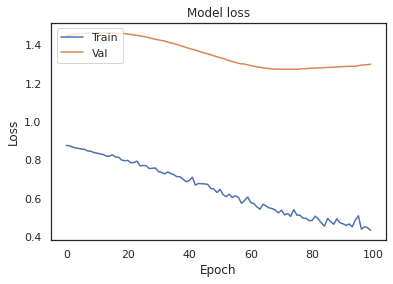

*** LSTM estimation ***
MAPE:  19.91792641573249
R2:  0.4448839184925114
RMSE:  17.76069733961212


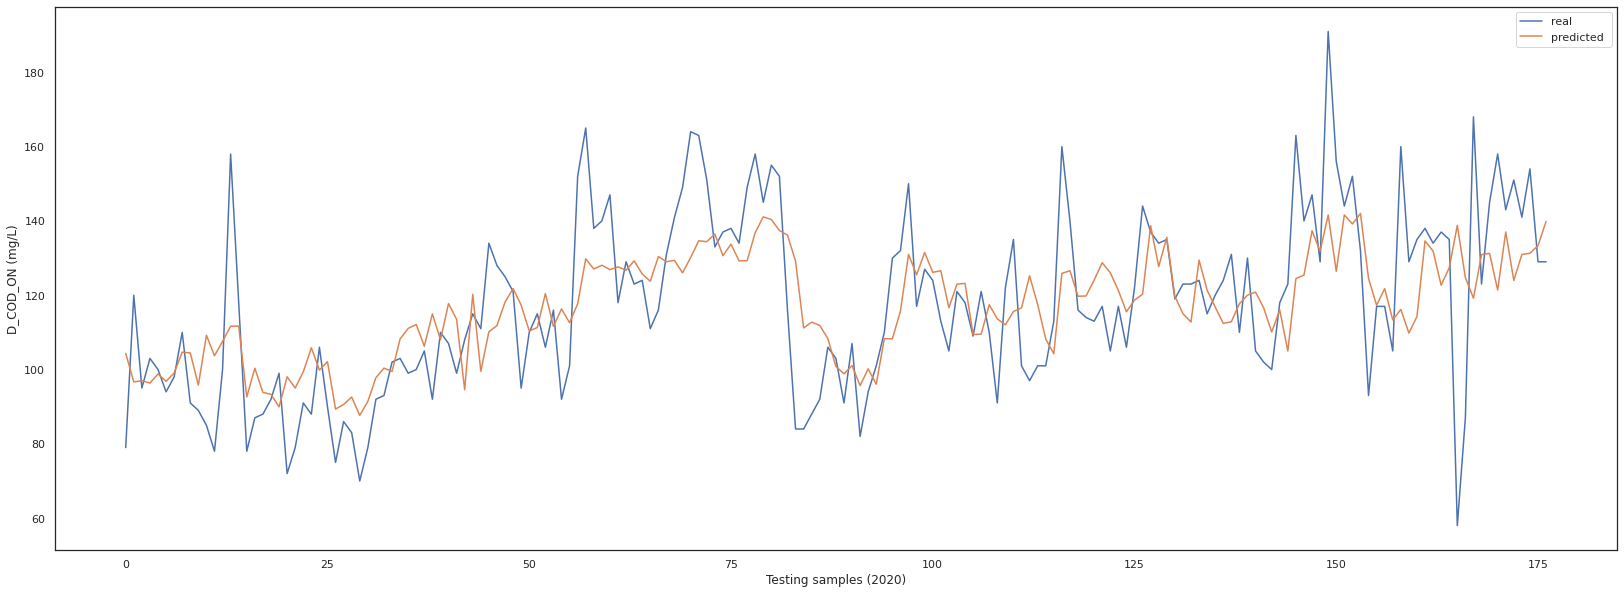

(177, 1)

In [82]:
app2 = approach2(dataset.iloc[:-cut_off], active_target)
app2.series_to_supervised(n_in=7)
app2.supervised
app2.training(max_epochs=100)
# app2.testing(dataset.iloc[-137:])
app2.testing(dataset.iloc[:-cut_off])
app2.full_prediction.shape

## Approach 3

*** Delta estimation ***
MAPE:  10.985756198959638
R2:  0.4776559428140238
RMSE:  17.22845917399711


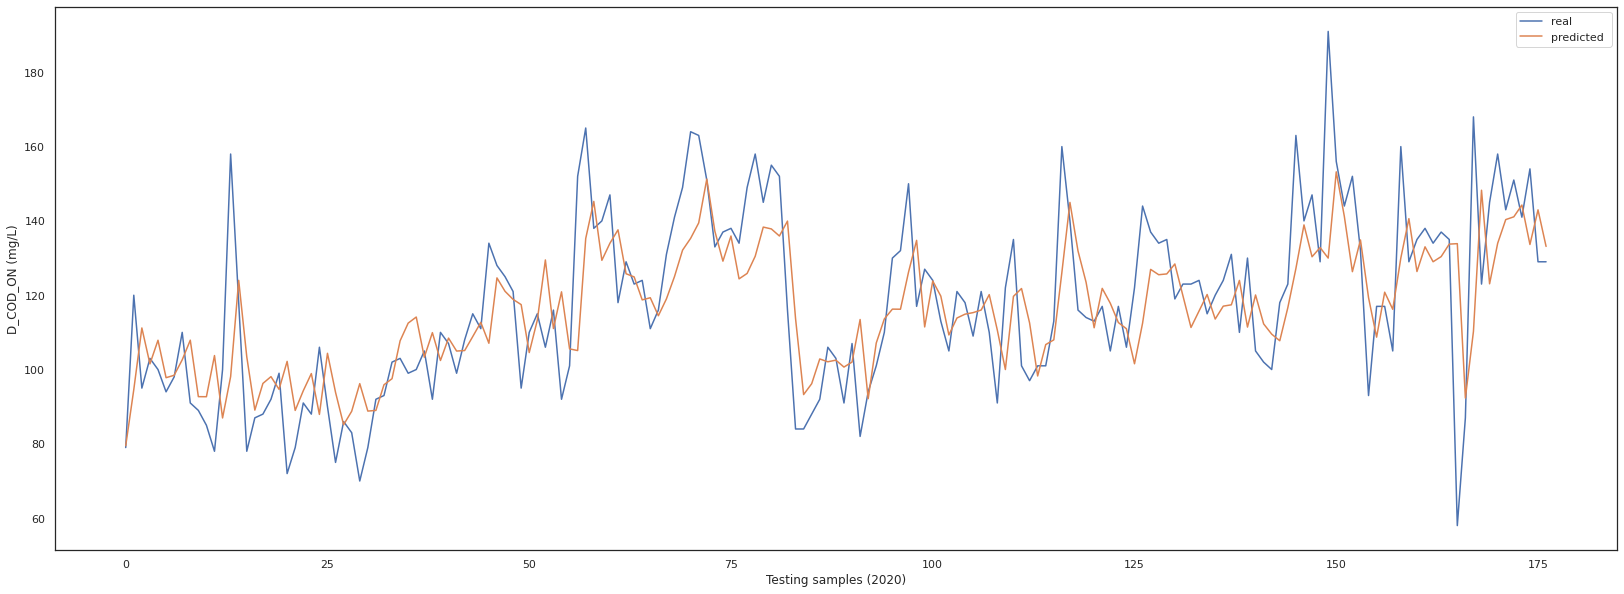

(177,)

In [83]:
app3 = approach3(dataset.iloc[:-cut_off], active_target)
app3.training()
app3.testing(dataset.iloc[7:-cut_off])
# app3.testing(dataset.iloc[-135:])
app3.full_prediction.shape

## Approaches

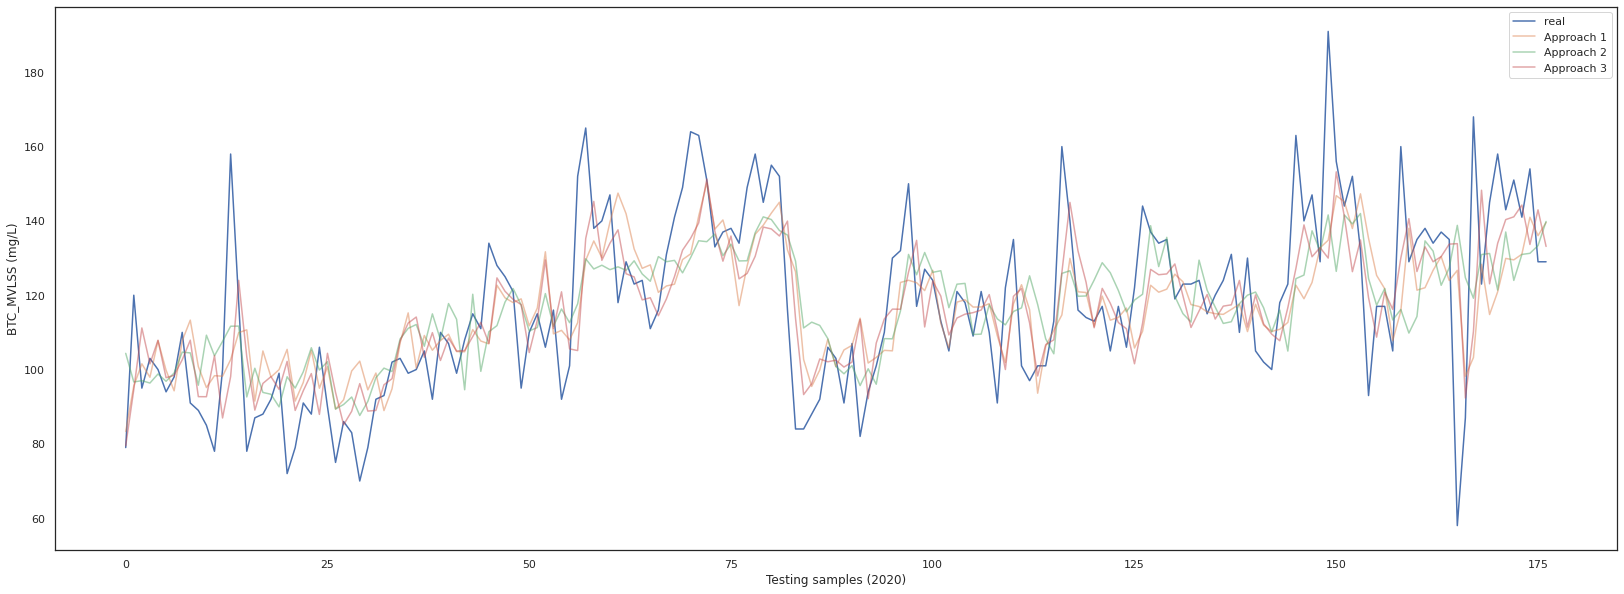

In [84]:
plt.figure(figsize=(28,10))
plt.plot(app1.Y_test.values, label = 'real ')
plt.plot(app1.full_prediction,'-', alpha= 0.5, label = 'Approach 1')
plt.plot(app2.full_prediction['Prediction'], alpha= 0.5, label = 'Approach 2')
plt.plot(app3.full_prediction, alpha= 0.5, label = 'Approach 3')
plt.ylabel('BTC_MVLSS (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

## Ensemble

In [85]:
app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction

0      267.188340
1      286.853147
2      309.733731
3      295.808090
4      314.465728
          ...    
172    394.598337
173    406.276892
174    405.925682
175    412.368019
176    412.558167
Length: 177, dtype: float64

### Ensemble AVG

*** Ensemble estimation ***
MAPE:  10.985613944940571
R2:  0.4706431210560098
RMSE:  17.3437254322897


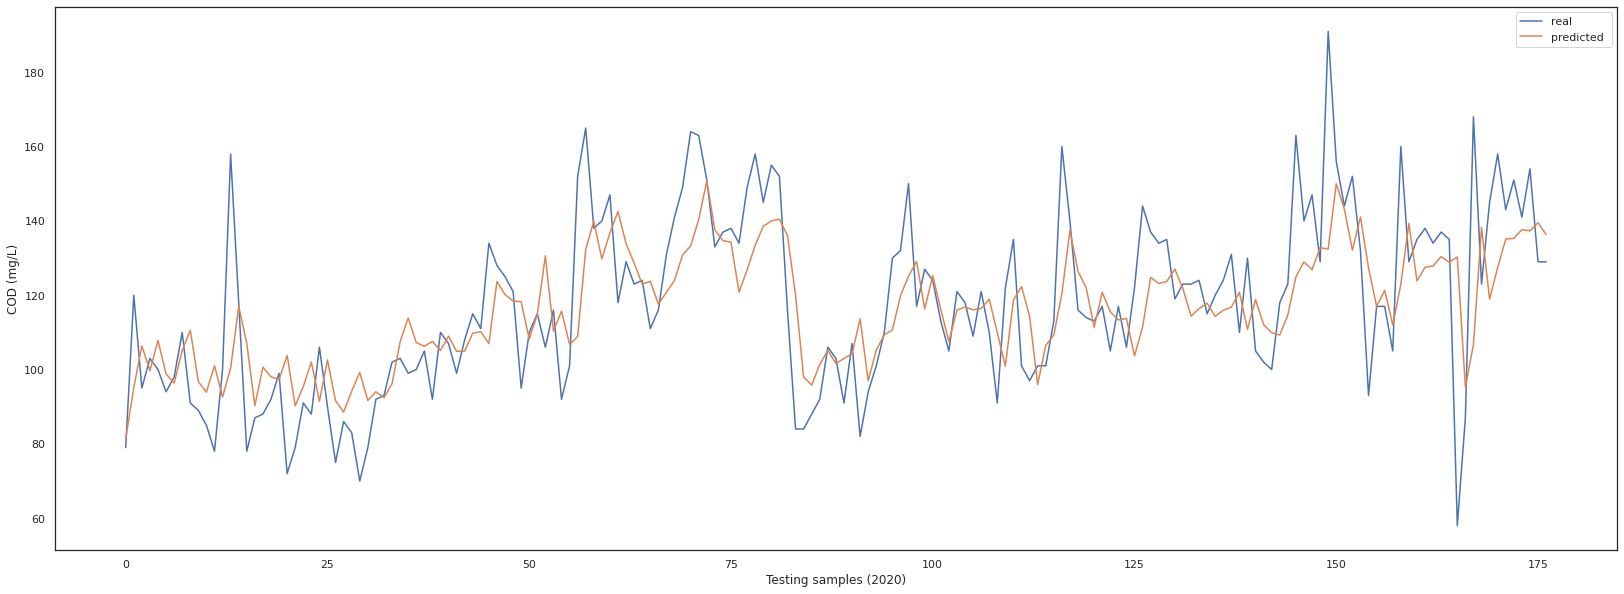

In [86]:
ensemble = (app1.full_prediction + app3.full_prediction)/2
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** Ensemble estimation ***
MAPE:  11.048439623092113
R2:  0.4895189095034105
RMSE:  17.03169764780717


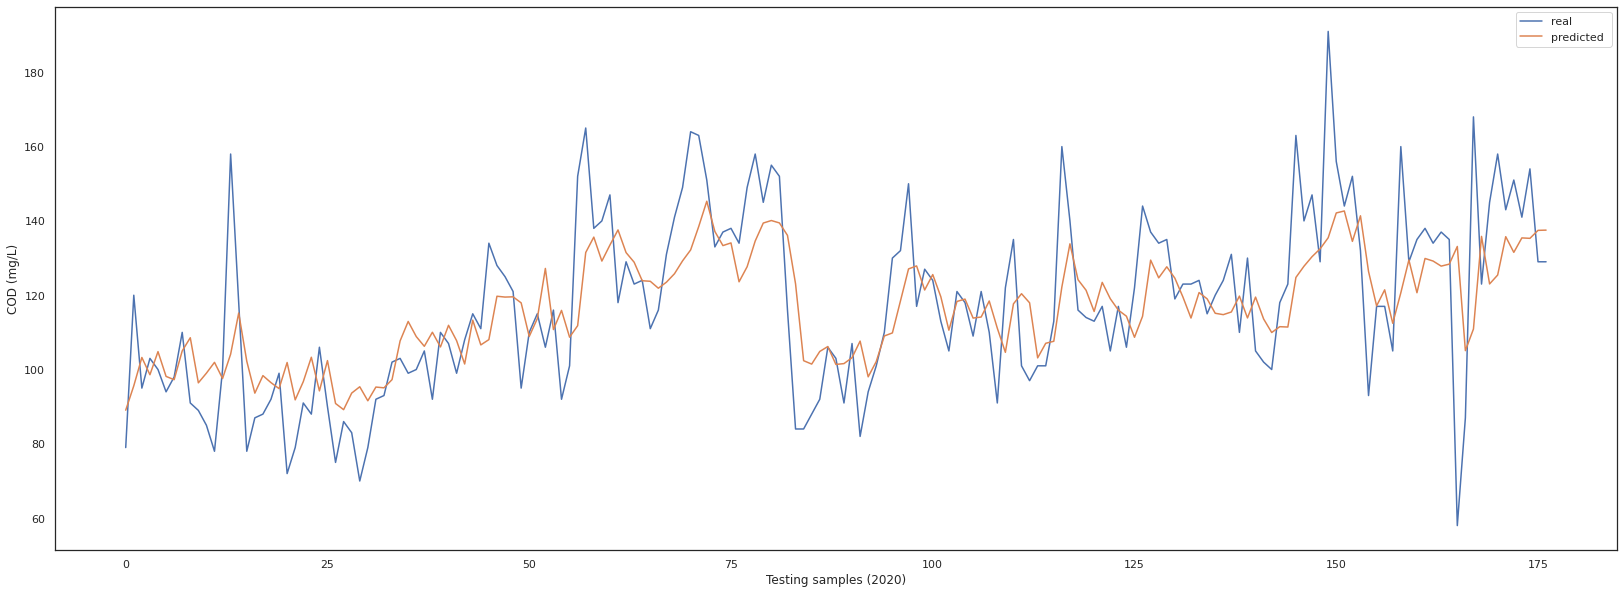

In [87]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble))
print ('R2: ',r2_score(app2.Y_test.values, ensemble))
print ('RMSE: ',mean_squared_error(app2.Y_test.values, ensemble, squared=False))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

### Ensemble 1 - Model Fusion

Epoch 1/50
5/5 [==============================] - 0s 35ms/step - loss: 0.8247 - MAPE: 149.1860 - val_loss: 1.4781 - val_MAPE: 92.9165
Epoch 2/50
5/5 [==============================] - 0s 8ms/step - loss: 0.7961 - MAPE: 149.8823 - val_loss: 1.4737 - val_MAPE: 91.9537
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7720 - MAPE: 151.0305 - val_loss: 1.4690 - val_MAPE: 90.9786
Epoch 4/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7525 - MAPE: 151.9865 - val_loss: 1.4622 - val_MAPE: 89.9095
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 0.7341 - MAPE: 153.3980 - val_loss: 1.4539 - val_MAPE: 88.7957
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 0.7209 - MAPE: 154.4812 - val_loss: 1.4449 - val_MAPE: 87.6689
Epoch 7/50
5/5 [==============================] - 0s 8ms/step - loss: 0.7068 - MAPE: 155.0589 - val_loss: 1.4355 - val_MAPE: 86.5451
Epoch 8/50
5/5 [==============================] - 0s 6ms/step - loss

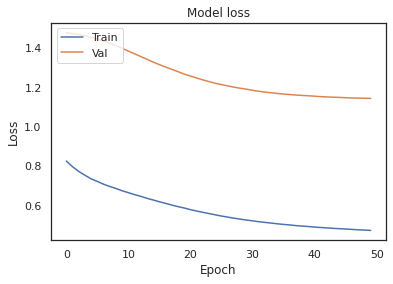

In [88]:
ensemble_model = Ensemble(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[31.20682  23.481329 19.845673 21.865242 17.447691 21.075401 23.562706
 17.540287 17.196848 21.014732 21.458523 20.463388 20.604637 18.161566
 17.190681 17.089994 25.603163 18.93098  22.562626 22.282488 18.550318
 26.865053 22.41373  18.030796 23.55661  19.710102 29.544508 27.968231
 22.272226 20.248451 25.65758  21.633862 26.924873 23.206861 17.375895
 17.462713 17.77753  17.282398 17.218796 17.365423 17.14041  17.475739
 18.47863  17.2715   17.357143 17.332142 21.391062 19.296343 18.970358
 19.050913 17.095953 17.878525 25.255596 17.102232 17.424545 17.19781
 17.250694 22.872538 27.53173  22.901035 29.228252 34.938915 29.618763
 23.354408 21.009912 21.756977 19.347076 19.86353  20.146242 23.324772
 23.653595 29.16367  37.27923  26.235584 28.021557 23.742004 19.53549
 21.336557 24.529367 25.958809 28.044271 30.404455 23.542772 20.07945
 18.297464 20.657482 18.83298  17.318436 19.940094 18.5901   18.030634
 17.447453 20.012526 19.3309

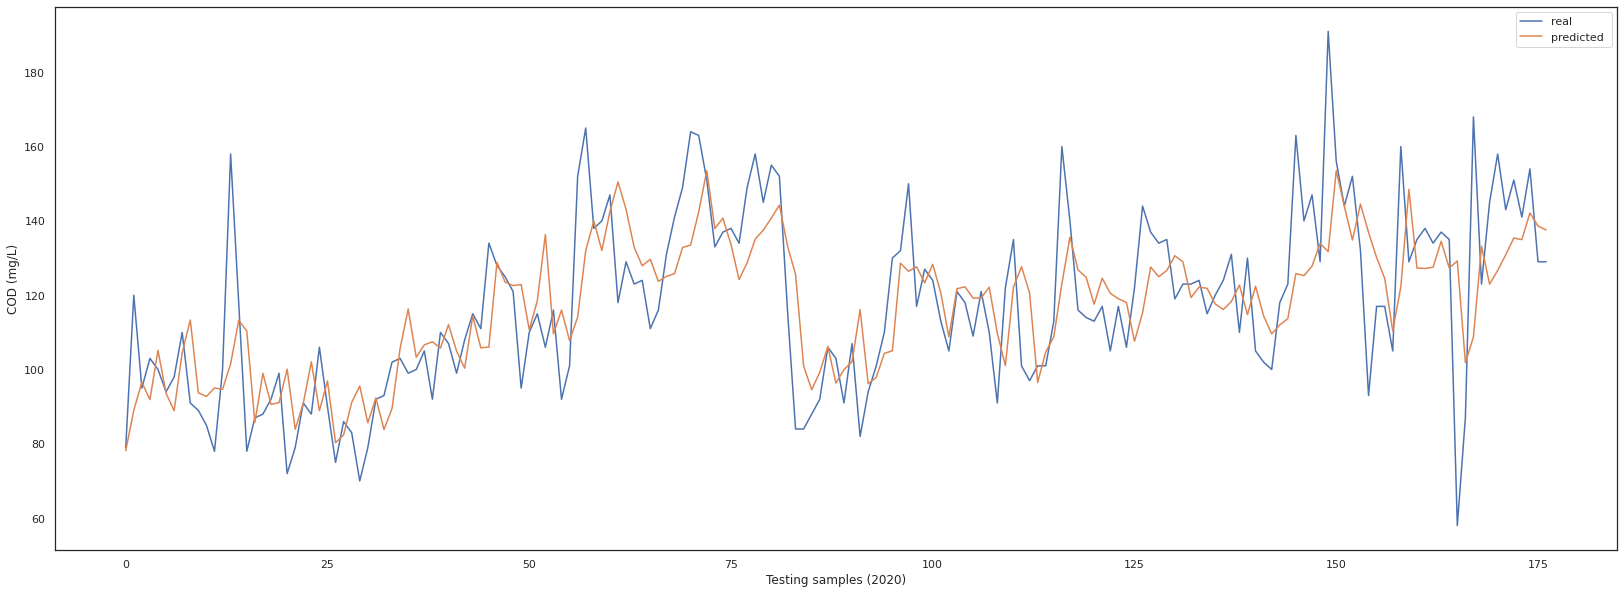

In [89]:
ensemble_model.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 2 - Model Fusion + Exo


Epoch 1/50
5/5 [==============================] - 0s 36ms/step - loss: 1.3678 - MAPE: 289.4927 - val_loss: 1.4848 - val_MAPE: 93.1616
Epoch 2/50
5/5 [==============================] - 0s 6ms/step - loss: 1.2931 - MAPE: 277.9491 - val_loss: 1.4636 - val_MAPE: 90.0703
Epoch 3/50
5/5 [==============================] - 0s 6ms/step - loss: 1.2254 - MAPE: 269.3208 - val_loss: 1.4463 - val_MAPE: 87.7794
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1627 - MAPE: 260.1275 - val_loss: 1.4325 - val_MAPE: 85.6930
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1049 - MAPE: 252.8006 - val_loss: 1.4251 - val_MAPE: 84.0213
Epoch 6/50
5/5 [==============================] - 0s 13ms/step - loss: 1.0539 - MAPE: 245.5255 - val_loss: 1.4219 - val_MAPE: 82.6829
Epoch 7/50
5/5 [==============================] - 0s 7ms/step - loss: 1.0054 - MAPE: 240.0514 - val_loss: 1.4199 - val_MAPE: 81.4667
Epoch 8/50
5/5 [==============================] - 0s 6ms/step - los

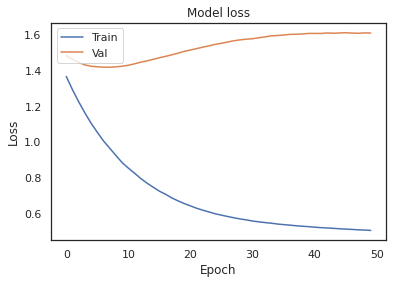

In [90]:
ensemble_model2 = Ensemble2(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model2.training()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[32.50384  22.254805 17.096495 18.989109 17.085024 17.392282 20.774551
 17.283054 17.695263 17.419098 22.683685 23.68377  21.993063 18.419147
 19.86554  20.77573  24.856562 17.226631 18.98655  17.234198 17.155209
 24.98701  22.43083  18.250961 19.622591 17.786722 20.734064 21.13918
 17.419123 17.359158 22.147354 19.388494 24.095081 20.631294 17.78809
 17.110216 22.915138 17.180502 18.997028 18.144545 17.41391  18.00222
 17.175322 17.462921 17.179554 17.236502 18.567526 18.15869  18.617702
 17.51948  17.422338 17.287777 20.790203 17.536192 17.286612 19.44474
 17.362104 26.720789 31.080082 23.728367 26.849064 31.01903  24.1023
 22.864819 19.750017 19.657942 18.630617 19.959536 21.89246  23.898895
 26.964935 33.802    40.020557 31.569893 26.29384  27.59491  22.780893
 22.59152  29.173967 34.655483 33.745773 33.81712  30.945593 19.199856
 20.60218  26.545816 23.908695 18.041048 17.472883 17.09866  17.677113
 19.009342 18.785883 18.131313 

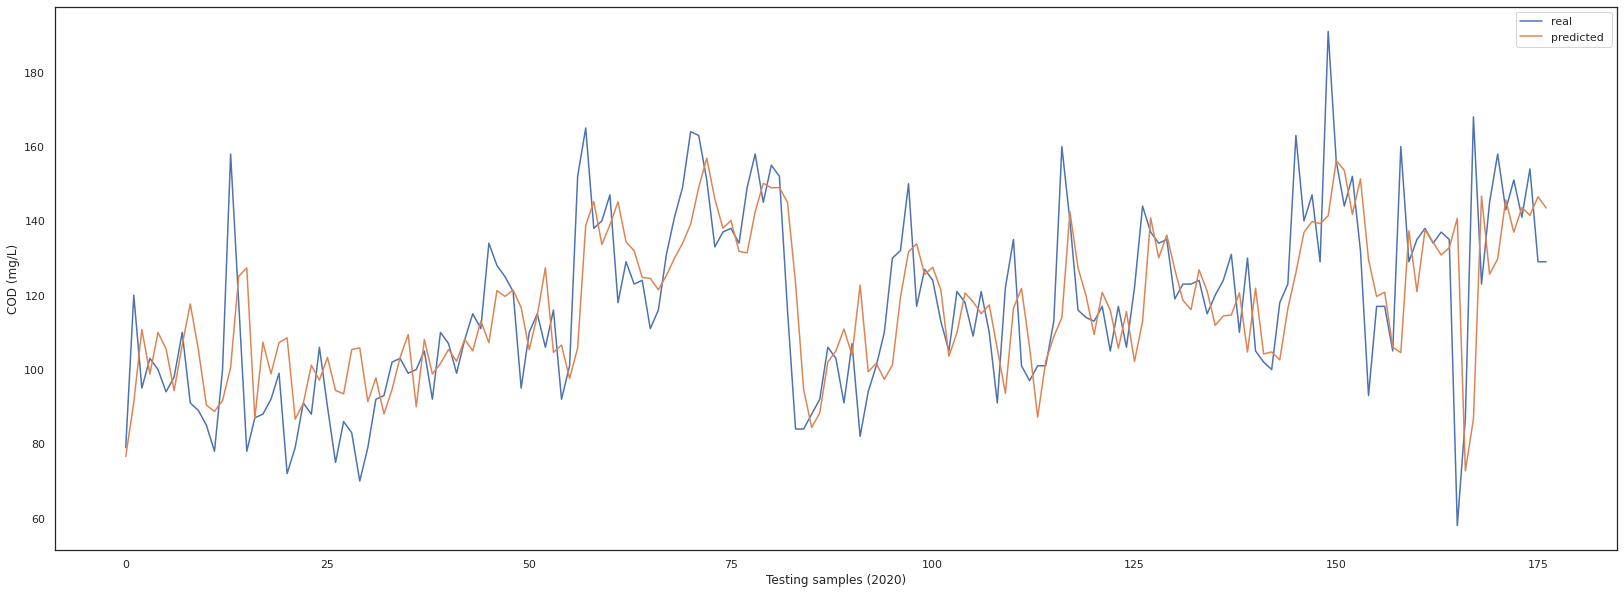

In [91]:
ensemble_model2.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

### Ensemble 3 - Model Selection

     0  1  2
0    0  0  1
1    0  1  0
2    0  1  0
3    0  0  1
4    0  1  0
..  .. .. ..
172  0  0  1
173  0  0  1
174  1  0  0
175  0  1  0
176  0  0  1

[177 rows x 3 columns]
(177, 3)
(177, 4)
Epoch 1/50
5/5 [==============================] - 1s 43ms/step - loss: 1.1296 - accuracy: 0.3522 - val_loss: 1.0898 - val_accuracy: 0.3333
Epoch 2/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1229 - accuracy: 0.3585 - val_loss: 1.0834 - val_accuracy: 0.3333
Epoch 3/50
5/5 [==============================] - 0s 8ms/step - loss: 1.1155 - accuracy: 0.3648 - val_loss: 1.0791 - val_accuracy: 0.3889
Epoch 4/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1111 - accuracy: 0.3333 - val_loss: 1.0748 - val_accuracy: 0.3333
Epoch 5/50
5/5 [==============================] - 0s 7ms/step - loss: 1.1059 - accuracy: 0.3522 - val_loss: 1.0720 - val_accuracy: 0.3333
Epoch 6/50
5/5 [==============================] - 0s 6ms/step - loss: 1.1021 - accuracy: 0.3333 - val_loss: 1.0

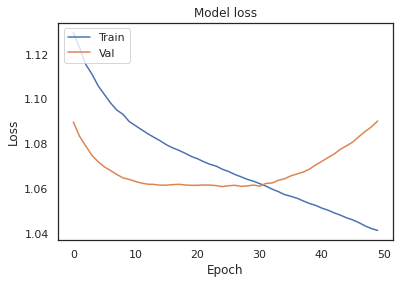

In [92]:
ensemble_model3 = Ensemble3(dataset.iloc[:-cut_off], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
ensemble_model3.training()

     D_COD_ON    model1    model2    model3
0   -1.950105 -2.305066 -0.937943 -2.358468
1   -1.577487 -1.442757 -1.509802 -1.386255
2    0.119996 -1.024651 -1.483732 -0.319112
3   -0.915055 -1.278946 -1.531581 -0.941049
4   -0.583839 -0.585365 -1.350316 -0.531878
..        ...       ...       ...       ...
172  1.072242  0.944327  0.519557  1.604762
173  1.403458  1.050857  1.038719  1.808885
174  0.989438  1.751728  1.061285  1.126002
175  1.527664  1.403118  1.215529  1.725517
176  0.492614  1.651924  1.697863  1.092402

[177 rows x 4 columns]      0  1  2
0    0  0  1
1    0  1  0
2    0  1  0
3    0  0  1
4    0  1  0
..  .. .. ..
172  0  0  1
173  0  0  1
174  1  0  0
175  0  1  0
176  0  0  1

[177 rows x 3 columns]
6/6 [==============================] - 0s 2ms/step - loss: 1.0451 - accuracy: 0.4689
*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(11.08626614776844, shape=(), dtype=float64)
MAPEsci:  1236.7032429877806
MAPE:  11.086266147768448
R2:  0.49130723818687105
RMSE:  1

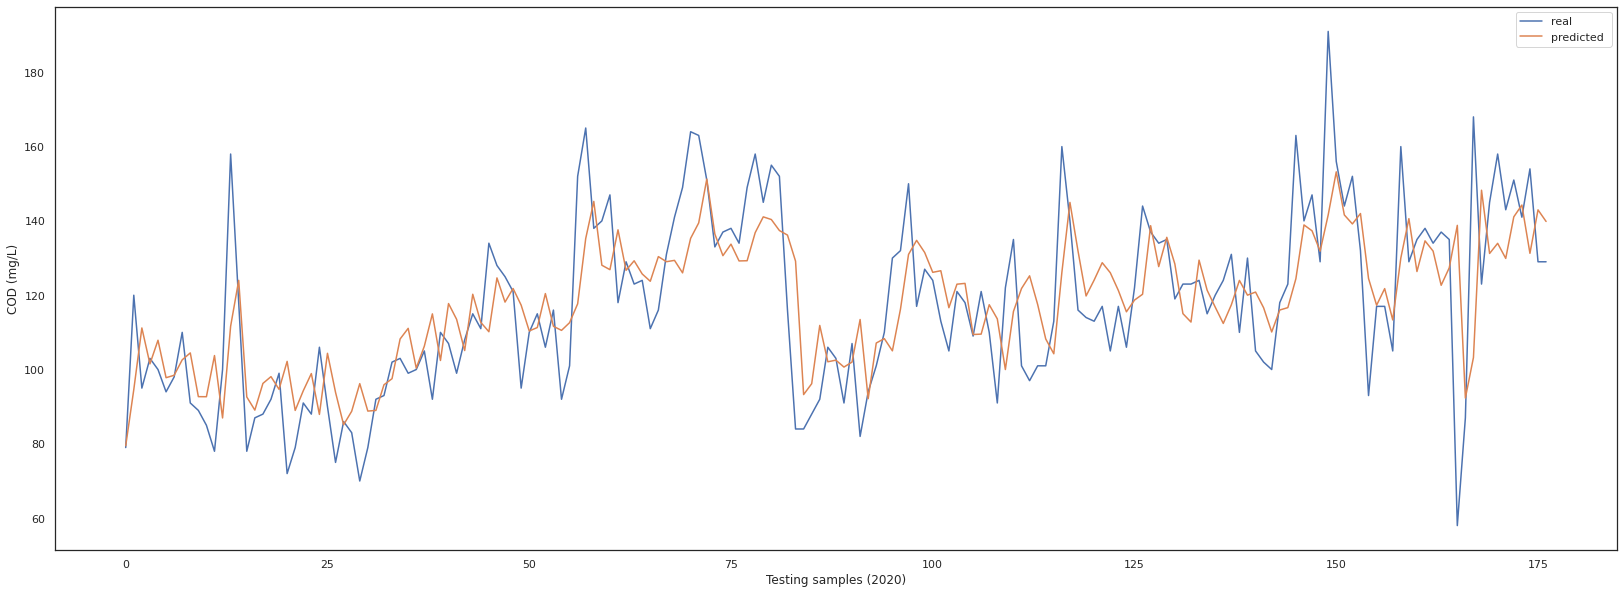

In [93]:
ensemble_model3.testing(dataset.iloc[:-cut_off], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [94]:
ensemble_model3.selection.to_list().count(1)

100

### Ensemble 4

In [95]:
class Ensemble4:
  def __init__(self, df, goal, model1, model2, model3):
    self.df = df.iloc[-len(model1):]
    self.goal = goal
    self.df = self.df.reset_index(drop=True)

    self.df['model1'] = model1
    self.df['model2'] = model2
    self.df['model3'] = model3
 
    self.df['target'] = self.df[self.goal].shift(-1).fillna(method='ffill')
    self.X = self.df[['model1', 'model2', 'model3']]

    model1 = abs(self.df['model1'] - self.df['target'])
    model2 = abs(self.df['model2'] - self.df['target'])
    model3 = abs(self.df['model3'] - self.df['target'])

    temp = pd.concat([model1, model2, model3], axis=1)
    temp = temp.idxmin(axis=1)  
    self.Y = pd.get_dummies(temp)

    # self.Y = self.df['target']
    # print(self.X)

    self.x_mean = self.X.mean()
    self.x_std = self.X.std()
    # self.y_mean = self.Y.mean()
    # self.y_std = self.Y.std()
    # print(self.x_mean, self.y_mean)

    self.X_train = (self.X - self.x_mean)/self.x_std
    self.Y_train = self.Y
    # self.Y_train = (self.Y - self.y_mean)/self.y_std
    # print(self.X_test, self.Y_train)
    print(self.Y_train)

  def pearson_corr(self):
    pearson = self.df.corr(method='pearson')
    fig = plt.figure(figsize=(30,10))
    fig.suptitle('Pearson Correlation', fontsize=16)
    sns.heatmap(pearson,vmax=1, cmap="bwr", linewidths=0.1, annot=True)
    plt.show()

  def training(self, neurons = 8, max_epochs = 50):
    from sklearn.svm import SVR
    self.model = SVR(kernel='rbf', C=10, gamma=0.001, epsilon=0.2)
    self.model = self.model.fit(self.X_train.values, self.Y_train.values)
  

  def testing(self, df_test, model1, model2, model3):
    self.df_test = df_test.iloc[-len(model1):]
    self.df_test = self.df_test.reset_index(drop=True)

    self.df_test['model1'] = model1
    self.df_test['model2'] = model2
    self.df_test['model3'] = model3

    self.df_test['target'] = self.df_test[self.goal].shift(-1).fillna(method='ffill')

    self.Xt = self.df_test[[self.goal, 'model1', 'model2', 'model3']]
    self.Y_test = self.df_test['target']
    # print(self.Xt)

    self.X_test = (self.Xt - self.x_mean)/self.x_std
    # print(self.X_test, self.Y_train)

    self.prediction = pd.DataFrame(self.model.predict(self.X_test), columns=['Prediction'])

    self.full_prediction = self.prediction*self.y_std + self.y_mean


    print('*** ANN Ensemble estimation ***')
    print ('MAPEtf: ',tf.keras.losses.mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('MAPEsci: ',mean_absolute_error(self.Y_test.values, self.full_prediction.values)*100)
    print ('MAPE: ',mean_absolute_percentage_error(self.Y_test.values, self.full_prediction.values))
    print ('R2: ',r2_score(self.Y_test.values, self.full_prediction))
    print ('RMSE: ',mean_squared_error(self.Y_test.values, self.full_prediction, squared=False))

    # plot baseline and predictions
    plt.figure(figsize=(28,10))
    plt.plot(self.Y_test.values, label = 'real ')
    plt.plot(self.full_prediction.values, label = 'predicted ')
    plt.ylabel('COD (mg/L)')
    plt.xlabel('Testing samples (2020)')
    plt.legend()
    plt.show()

In [96]:
# ensemble_model4 = Ensemble4(dataset.iloc[:-135], active_target, app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)
# ensemble_model4.training()

## Testing


*** ANN estimation ***
MAPE:  12.756774596434372
R2:  -1.2542148792463905
RMSE:  25.08935343693259


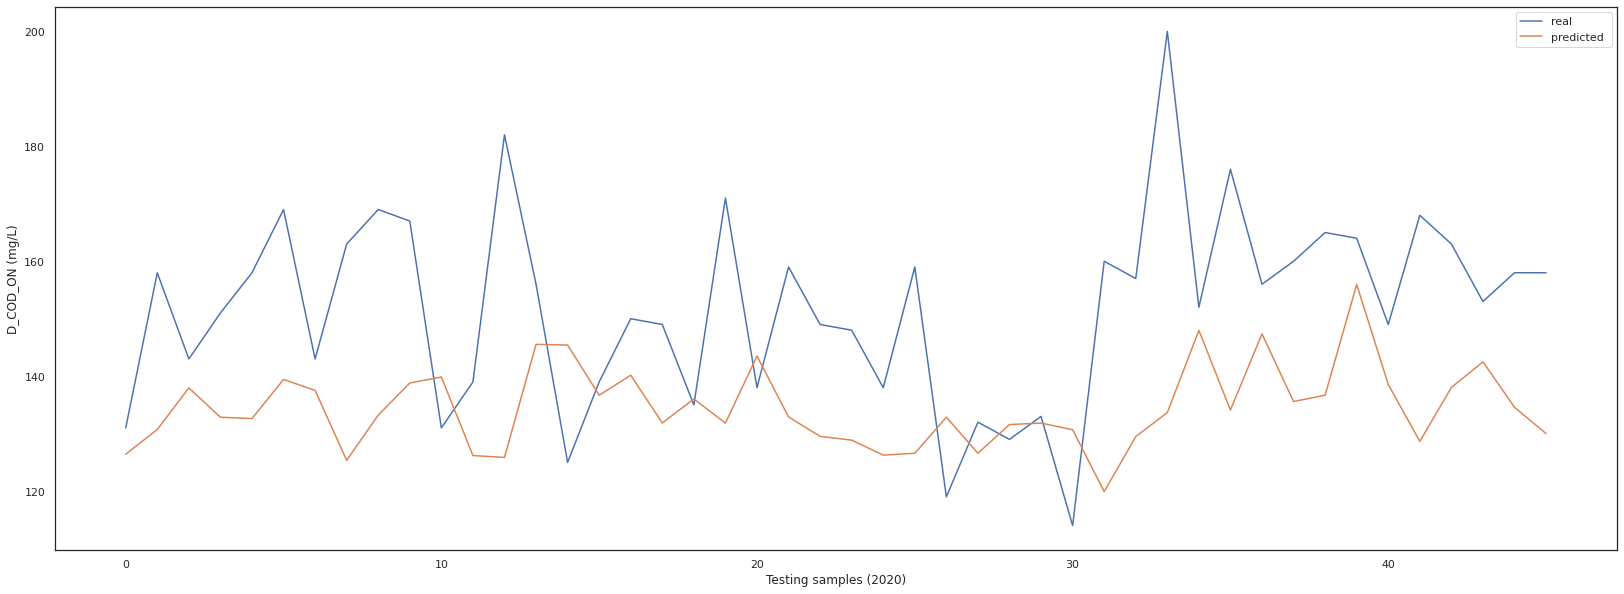

(46,)

In [97]:
app1.testing(dataset.iloc[-(cut_off + 5):])
app1.full_prediction.shape

*** LSTM estimation ***
MAPE:  18.202411847180073
R2:  -2.9546808591515186
RMSE:  33.2313155573865


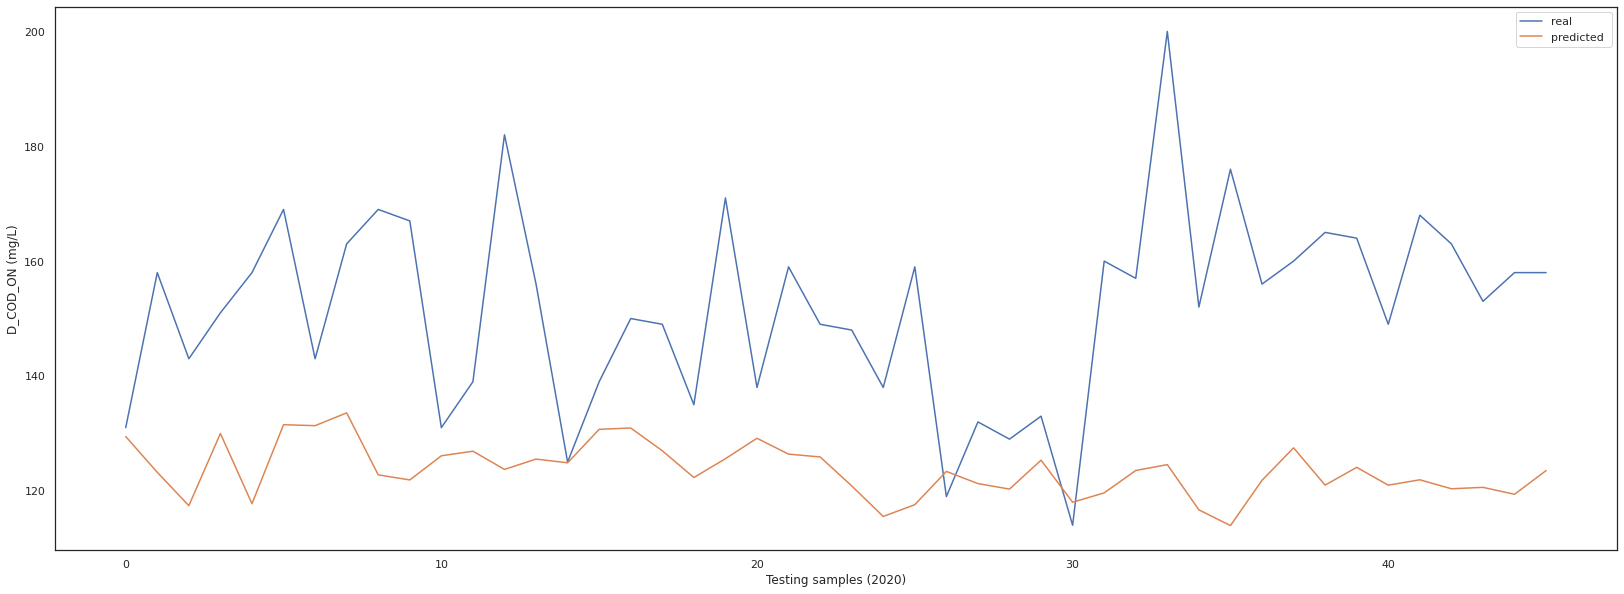

(46, 1)

In [98]:
app2.testing(dataset.iloc[-(cut_off + 7):])
app2.full_prediction.shape

*** Delta estimation ***
MAPE:  10.563305040965583
R2:  -0.4915299446832424
RMSE:  20.408345684769557


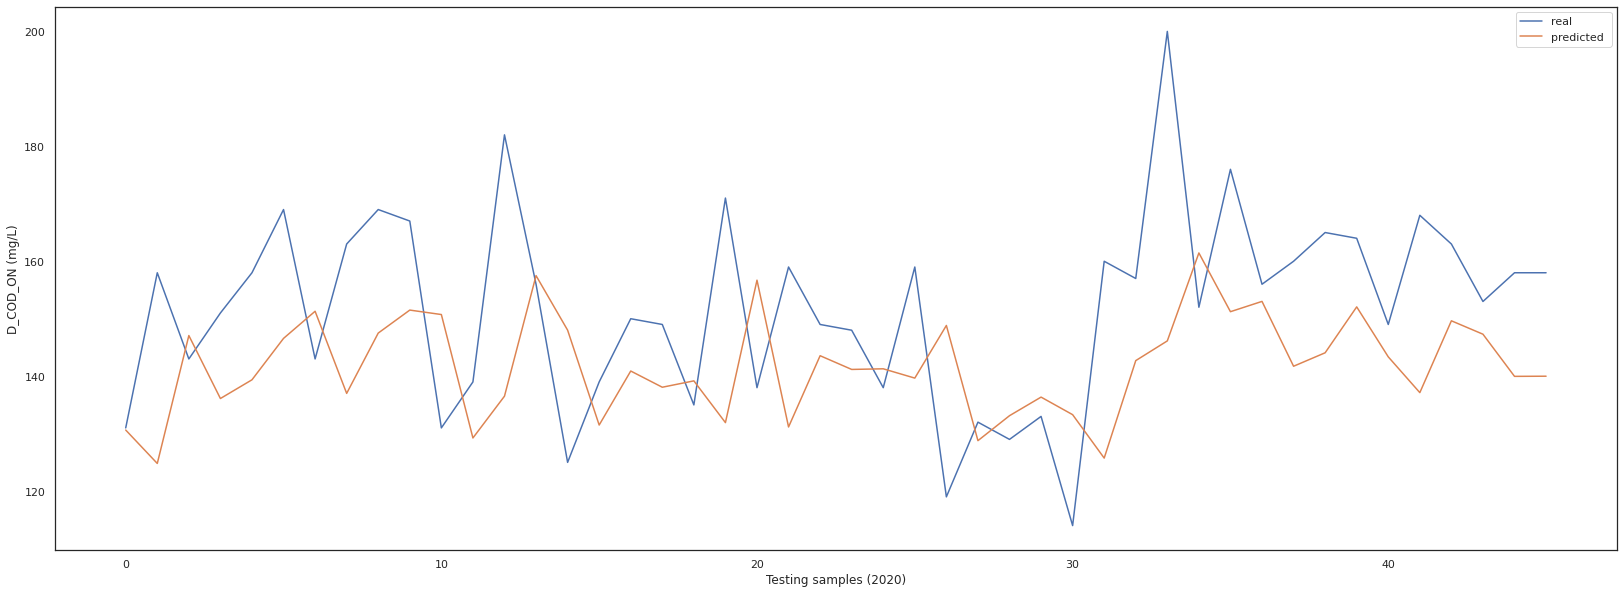

(46,)

In [99]:
app3.testing(dataset.iloc[-cut_off:])
app3.full_prediction.shape

*** Ensemble estimation ***
MAPE:  13.159650546802318


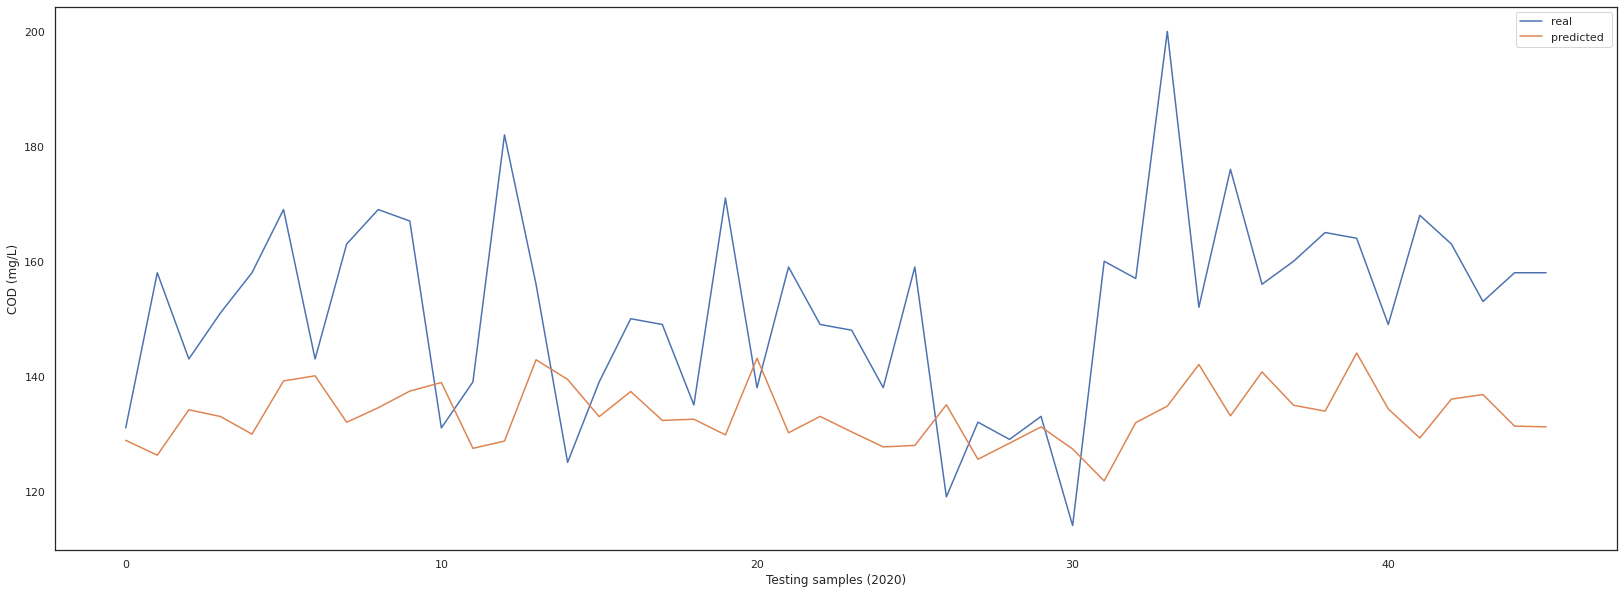

In [100]:
ensemble = (app1.full_prediction + app2.full_prediction['Prediction'] + app3.full_prediction)/3
print('*** Ensemble estimation ***')
print ('MAPE: ',mean_absolute_percentage_error(app2.Y_test.values, ensemble.values))
#print ('R2: ',r2_score(app2.Y_test.values, ensemble.values))
# plot baseline and predictions
plt.figure(figsize=(28,10))
plt.plot(app2.Y_test.values, label = 'real ')
plt.plot(ensemble.values, label = 'predicted ')
plt.ylabel('COD (mg/L)')
plt.xlabel('Testing samples (2020)')
plt.legend()
plt.show()

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[15.477369  12.978729   9.34852   12.232898  10.694877  10.009052
 10.169206  15.520145  10.589981   9.328499   9.447713  15.247275
 14.00726    9.028233   8.965003  11.358402  10.056029  12.03588
 10.330726  12.320261   8.987026  12.118078  12.281835  12.032398
 12.221746  12.512538  10.658541  14.019096  11.629139  11.956663
 11.625745  17.537592  12.05373   10.708852   9.959182   9.6172085
  9.155086  10.743205   9.88928   11.036226   9.6068945 12.561925
  9.427924   8.982341  10.367222  12.074847 ], shape=(46,), dtype=float32)
MAPEsci:  1696.251628709876
MAPE:  11.367616889297995
R2:  -0.6691228437273122
RMSE:  21.589170886706665


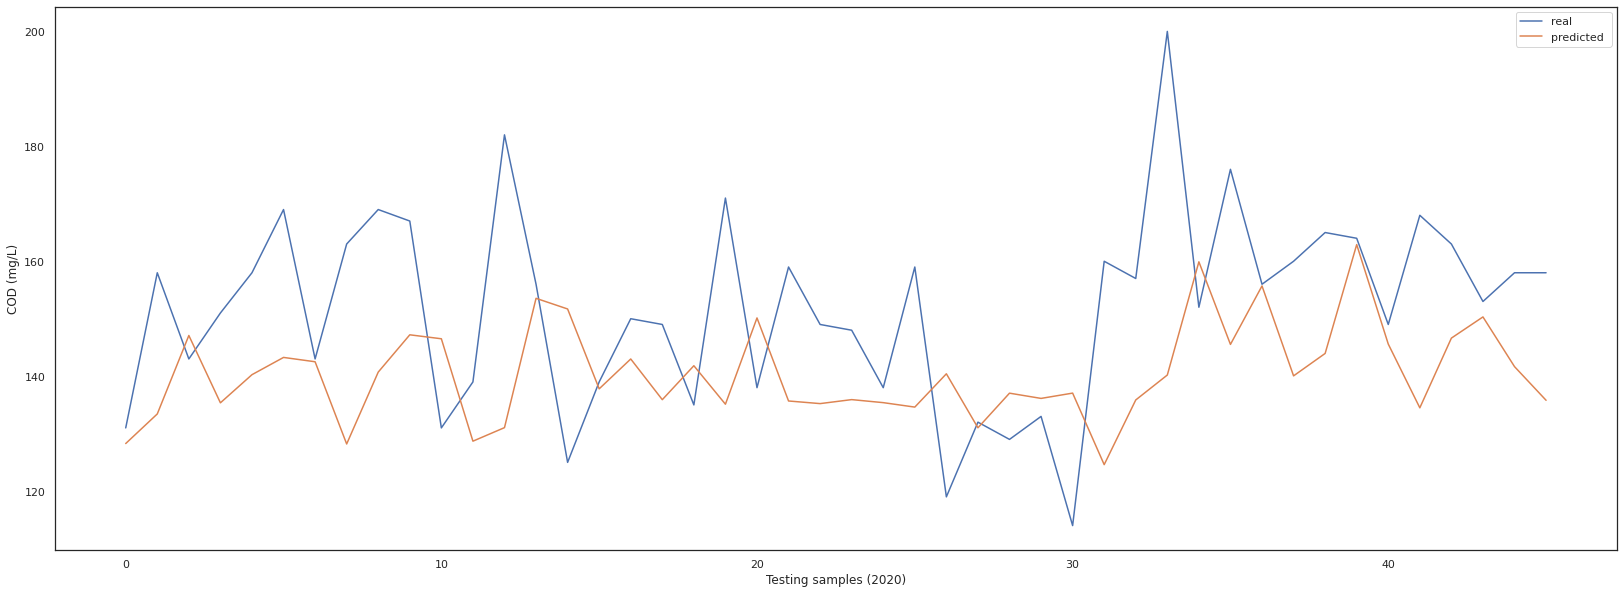

In [101]:
ensemble_model.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

*** ANN Ensemble estimation ***
MAPEtf:  tf.Tensor(
[12.2832155 15.336127  10.408659  10.950656  12.25162    9.068565
  8.964857  11.05554   10.024987   9.319451   9.035255  14.243574
 13.138569   9.166927   9.156471  11.838904   9.922603  10.977973
 11.13181   12.899366   9.125119  12.551315  10.467286  12.012572
 13.481656  13.896932   9.992741  16.783098  14.035441  12.5409975
 14.670925  21.929787  10.809469  10.0911665  9.406667  10.983679
  8.97777   10.047637  10.377317   9.136977  10.123353  12.466324
  9.66689    9.58763   11.494094  11.131303 ], shape=(46,), dtype=float32)
MAPE:  11.455723607552635
R2:  -0.6640189439906163
RMSE:  21.556137569857274


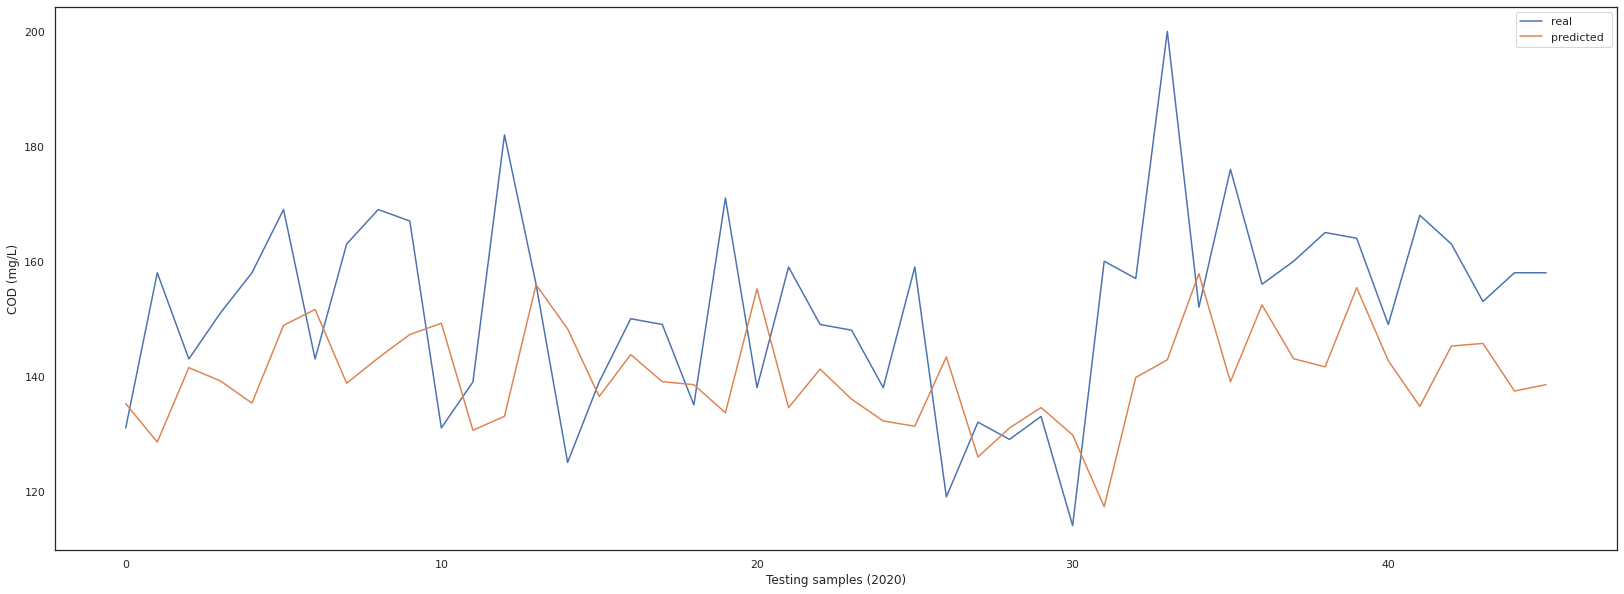

In [102]:
ensemble_model2.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

    D_COD_ON    model1    model2    model3
0   1.362056  0.726930  0.925814  0.931285
1   0.575418  1.029044  0.463225  0.557205
2   1.693272  1.538052  0.031727  1.989355
3   1.072242  1.179094  0.965303  1.284274
4   1.403458  1.162758  0.057349  1.493795
5   1.693272  1.641513  1.078764  1.957413
6   2.148695  1.508934  1.066135  2.261114
7   1.072242  0.651232  1.231695  1.341623
8   1.900282  1.205482  0.430427  2.016843
9   2.148695  1.598523  0.364506  2.274291
10  2.065891  1.672149  0.676772  2.224414
11  0.575418  0.710203  0.736239  0.842588
12  0.906634  0.687205  0.500705  1.310469
13  2.686921  2.071488  0.634327  2.660107
14  1.610468  2.063159  0.585986  2.049418
15  0.327006  1.448588  1.018947  0.987385
16  0.906634  1.693385  1.036040  1.592047
17  1.362056  1.108811  0.741739  1.410546
18  1.320654  1.402409  0.395935  1.481875
19  0.741026  1.108015  0.639106  1.014403
20  2.231499  1.929307  0.903341  2.609133
21  0.865232  1.182360  0.698151  0.965756
22  1.73467

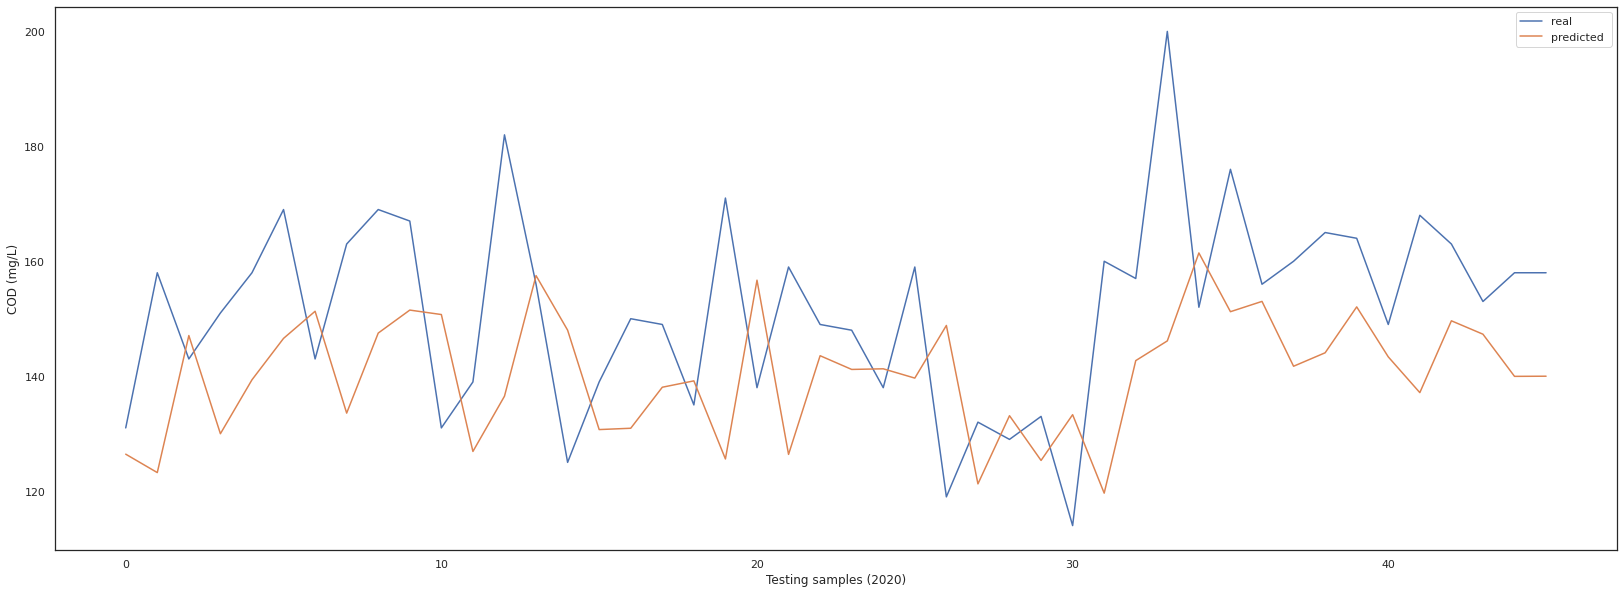

In [103]:
ensemble_model3.testing(dataset.iloc[-142:], app1.full_prediction, app2.full_prediction['Prediction'], app3.full_prediction)

In [104]:
ensemble_model3.selection.to_list().count(3)

0